In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import itertools
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
from itertools import cycle
plt.style.use('seaborn-v0_8-whitegrid')

In [40]:
data_frame = pd.read_csv('./dataset/adult.data.txt', sep=",\s+", engine='python', header=None)
data_frame.columns = [
    "age", "work_class", "final_weight", "education", "education_num", "marital_status", 
    "occupation", "relationship", "race", "gender", "capital_gain", "capital_loss", 
    "hours_per_week", "native_country", "salary_range"
]

# Filter out rows with '?' in any column.
data_frame = data_frame[~(data_frame == '?').any(axis=1)]

# Create subsets for the two salary ranges and reset index to avoid duplicate indices.
subset_below_50K = data_frame[data_frame["salary_range"] == "<=50K"].sample(n=7841, random_state=1).reset_index(drop=True)
subset_above_50K = data_frame[data_frame["salary_range"] == ">50K"].reset_index(drop=True)

# Concatenate the two subsets and create a binary class column.
data_frame = pd.concat([subset_above_50K, subset_below_50K])
data_frame['binary_class'] = (data_frame["salary_range"] == ">50K").astype(int)

print(data_frame.isnull().sum())  # This will print the count of null values for each column.

age               0
work_class        0
final_weight      0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
gender            0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
salary_range      0
binary_class      0
dtype: int64


In [41]:
def plot_scatter(columns):
    plt.close()
    num_pairs = len(columns) * (len(columns) - 1) // 2
    figure, axes = plt.subplots(nrows=num_pairs, ncols=2, figsize=(10, num_pairs * 5))
    figure.subplots_adjust(hspace=0.5)

    pair_index = 0
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            x_below = subset_below_50K[columns[i]]
            y_below = subset_below_50K[columns[j]]
            axes[pair_index, 0].scatter(x_below, y_below)
            axes[pair_index, 0].set_title(f"<=50K: {columns[i]} vs {columns[j]}")
            axes[pair_index, 0].set_xlabel(columns[i])
            axes[pair_index, 0].set_ylabel(columns[j])

            x_above = subset_above_50K[columns[i]]
            y_above = subset_above_50K[columns[j]]
            axes[pair_index, 1].scatter(x_above, y_above)
            axes[pair_index, 1].set_title(f">50K: {columns[i]} vs {columns[j]}")
            axes[pair_index, 1].set_xlabel(columns[i])
            axes[pair_index, 1].set_ylabel(columns[j])

            pair_index += 1  # Increment the pair_index for the next pair of columns

    plt.show()

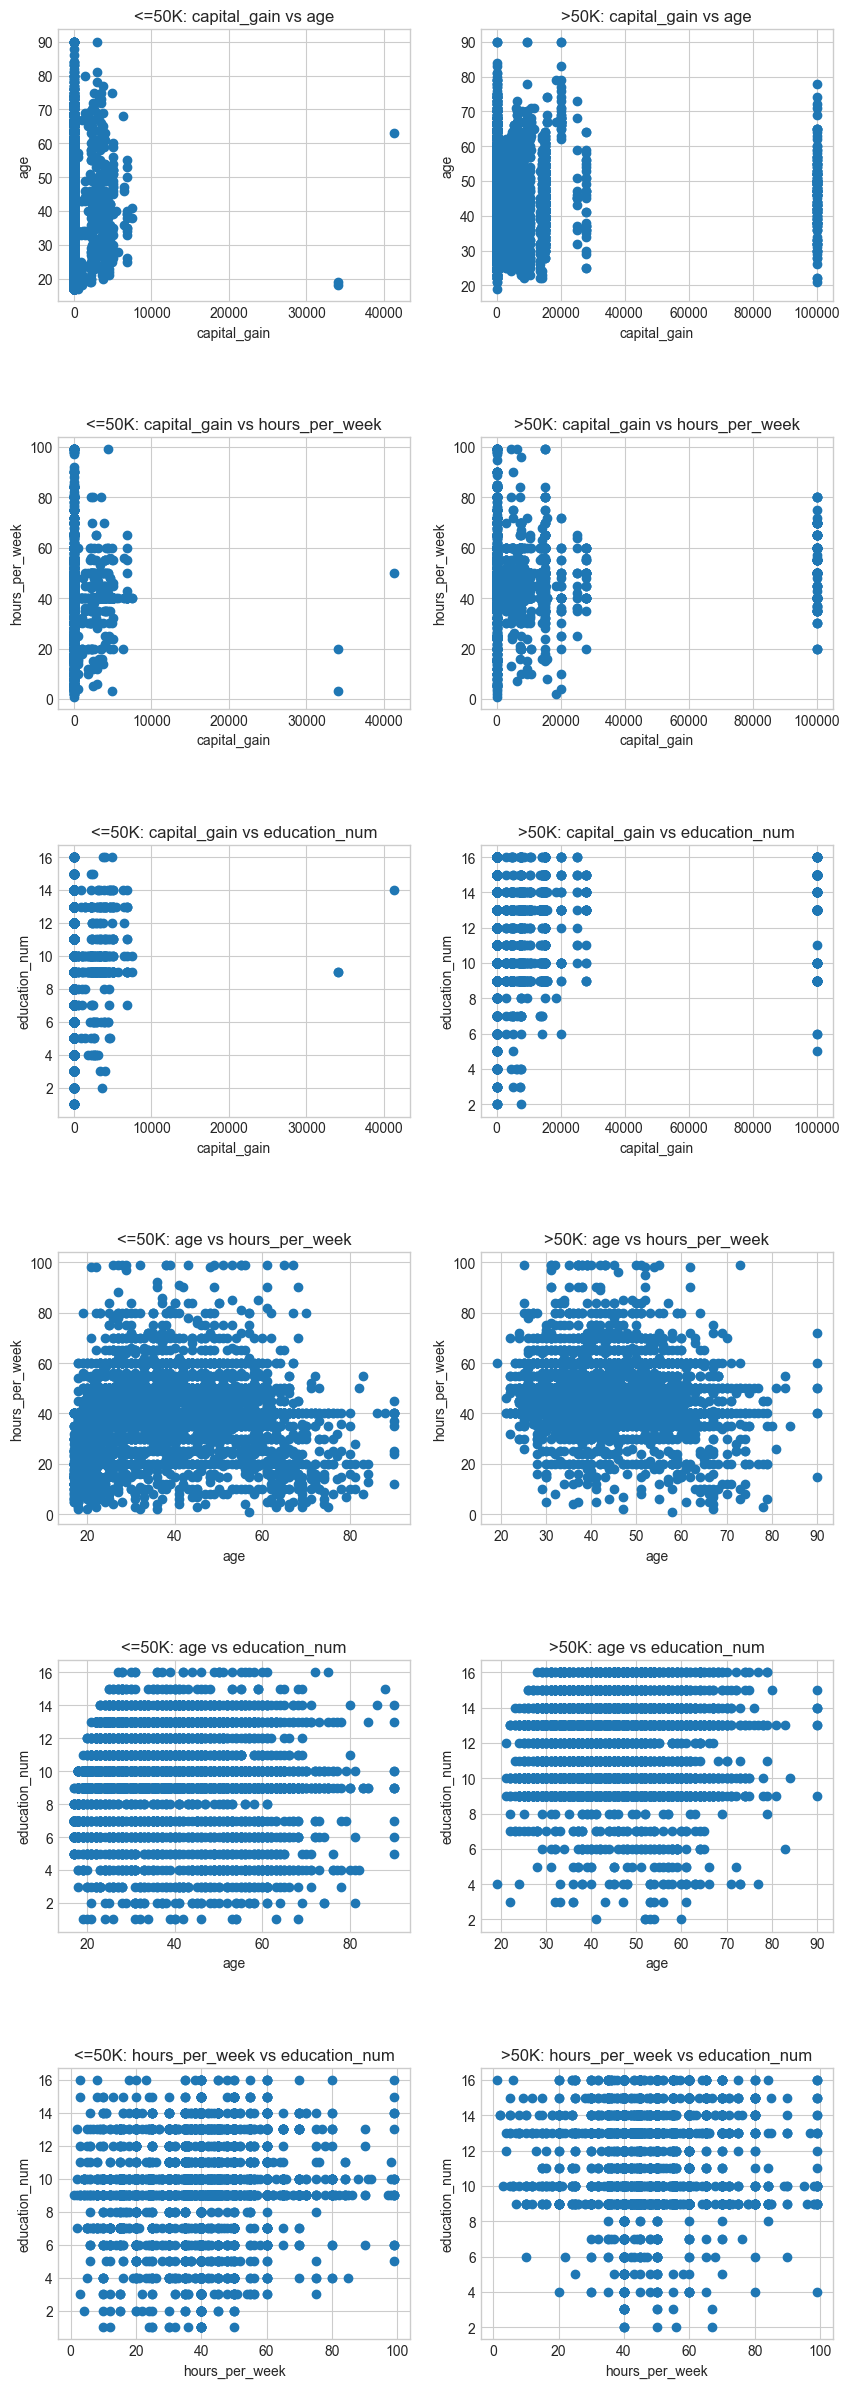

In [42]:
plot_scatter(['capital_gain', 'age', 'hours_per_week', 'education_num'])

In [43]:
def plot_scatter_diff(columns):
    plt.close()
    num_plots = len(columns) * (len(columns) - 1) // 2  # Calculate combinations
    figure, axes = plt.subplots(nrows=num_plots, ncols=2, figsize=(10, 5 * num_plots))
    figure.subplots_adjust(hspace=0.5)

    # Define the color mapping for the 'salary_range' column
    color_mapping = {'<=50K': 'purple', '>50K': 'yellow'}
    colors = data_frame['salary_range'].map(color_mapping)

    plot_idx = 0  # Index to track the subplot position
    for (column1, column2) in itertools.combinations(columns, 2):
        axis1 = axes[plot_idx, 0]
        axis2 = axes[plot_idx, 1]

        # Plot for <=50K
        axis1.scatter(data_frame[data_frame['salary_range'] == '<=50K'][column1], data_frame[data_frame['salary_range'] == '<=50K'][column2], c='purple', alpha=0.5)
        axis1.set_title(f"{column1} vs {column2} (<=50K)")
        axis1.set_xlabel(column1)
        axis1.set_ylabel(column2)

        # Plot for >50K
        axis2.scatter(data_frame[data_frame['salary_range'] == '>50K'][column1], data_frame[data_frame['salary_range'] == '>50K'][column2], c='yellow', alpha=0.5)
        axis2.set_title(f"{column1} vs {column2} (>50K)")
        axis2.set_xlabel(column1)
        axis2.set_ylabel(column2)

        plot_idx += 1

    # Create a legend for the colors
    legend_labels = {'<=50K': 'purple', '>50K': 'yellow'}
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key, markerfacecolor=color, markersize=10)
                       for key, color in legend_labels.items()]
    
    # Add the legend to the figure
    figure.legend(handles=legend_elements, loc='upper right', title='Salary Range')

    plt.tight_layout()
    plt.show()

In [44]:
plot_scatter_diff(['capital_gain', 'age', 'hours_per_week', 'education_num'])

In [45]:
def plot_scatter_matrix(columns):
    salary_ranges = {
        "<=50K": subset_below_50K,
        ">50K": subset_above_50K
    }
    
    for salary_range, subset in salary_ranges.items():
        plt.figure(figsize=(15, 11))
        scatter_matrix = pd.plotting.scatter_matrix(subset[columns], alpha=0.5, figsize=(15, 11))
        plt.suptitle(f"Scatter matrix for Salary {salary_range}")
        plt.show()

<Figure size 1500x1100 with 0 Axes>

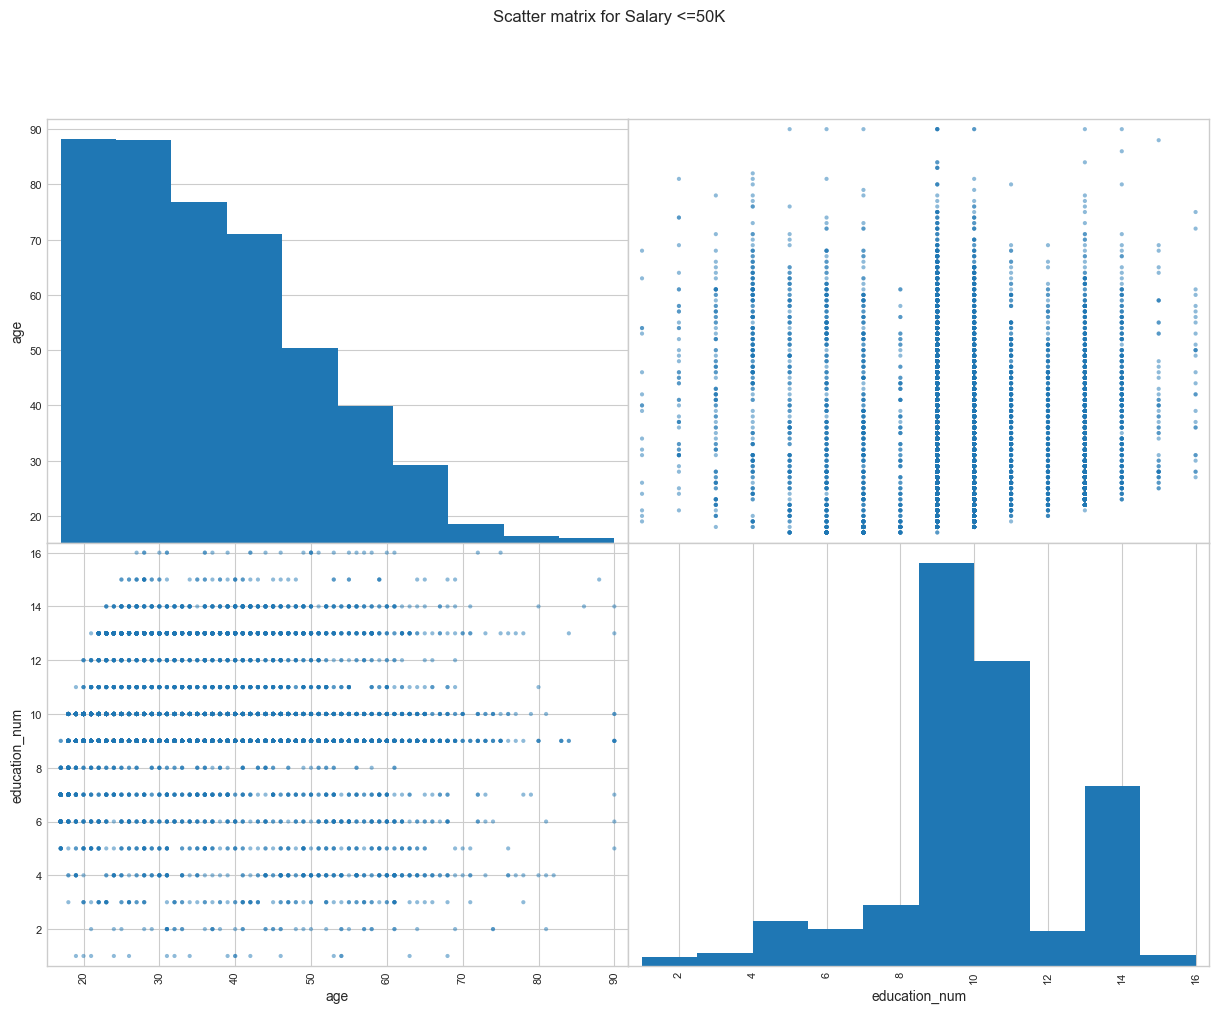

<Figure size 1500x1100 with 0 Axes>

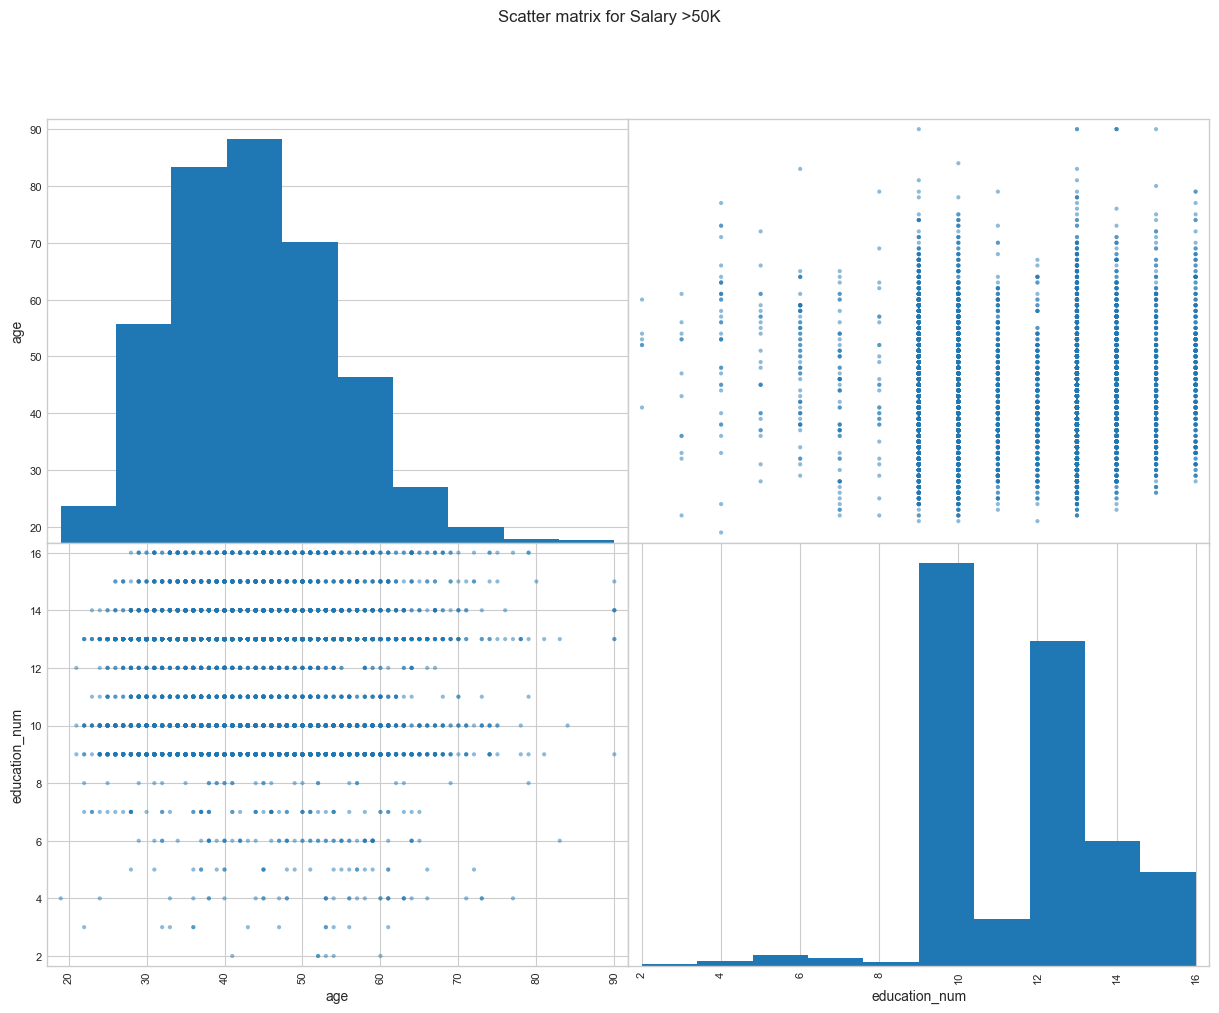

In [46]:
plot_scatter_matrix(['age', 'education_num'])

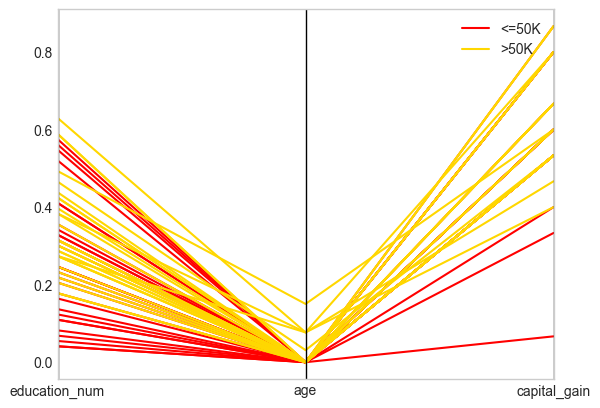

In [47]:
scaled_frame = data_frame[['education_num', 'age', 'capital_gain', 'binary_class']].copy()
scaled_array = MinMaxScaler().fit_transform(scaled_frame.values)
scaled_frame = pd.DataFrame(scaled_array)
data_frame.index = scaled_frame.index
scaled_frame['salary_range'] = data_frame['salary_range']
scaled_frame.columns = ['capital_gain', 'education_num', 'age', 'binary_class', 'salary_range']
subset_below_50K_scaled = scaled_frame[scaled_frame["binary_class"] == 0.0].sample(n=30)
subset_above_50K_scaled = scaled_frame[scaled_frame["binary_class"] == 1.0].sample(n=30)
combined_scaled_frame = pd.concat([subset_below_50K_scaled, subset_above_50K_scaled])
pd.plotting.parallel_coordinates(combined_scaled_frame, 'salary_range', cols=['education_num', 'age', 'capital_gain'], color=('#FF0000', '#FFD700'))
plt.show()

In [48]:
def plot_mosaic_class(df, attr1, attr2, attr3, attr4):
    plt.close()
    color_cycle = cycle(plt.cm.tab20.colors)

    # Combine all unique values from the given attributes plus 'salary_range'
    unique_values = set(df[attr1].unique()).union(
        df[attr2].unique(), df[attr3].unique(),
        df[attr4].unique(), df['salary_range'].unique())

    # Map each unique value to a color
    color_dict = {value: next(color_cycle) for value in unique_values}

    # List of attributes to be considered for plotting
    attributes = [attr1, attr2, attr3, attr4]

    # Generate plots for pairwise combinations of attributes for each 'salary_range'
    for i, first_attr in enumerate(attributes):
        for j, second_attr in enumerate(attributes[i+1:]):
            for salary_range in df['salary_range'].unique():
                fig, ax = plt.subplots(figsize=(24, 16))
                prop = lambda key: {'color': color_dict.get(key[0], 'grey')}
                mosaic(df[df['salary_range'] == salary_range], [first_attr, second_attr], ax=ax, properties=prop, labelizer=lambda k: '')
                title = f"Mosaic plot of {first_attr} vs {second_attr} for salary range: {salary_range}"
                ax.set_title(title)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
                ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right')
                plt.tight_layout()
                plt.show()

    # Generate individual plots for each attribute against 'salary_range' for each 'salary_range'
    for attr in attributes:
        for salary_range in df['salary_range'].unique():
            fig, ax = plt.subplots(figsize=(24, 16))
            prop = lambda key: {'color': color_dict.get(key[0], 'grey')}
            mosaic(df[df['salary_range'] == salary_range], [attr, 'salary_range'], ax=ax, properties=prop, labelizer=lambda k: '')
            title = f"Mosaic plot of {attr} for salary range: {salary_range}"
            ax.set_title(title)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

    # Generate plots for each attribute against 'salary_range' without segmenting by 'salary_range'
    for attr in attributes:
        fig, ax = plt.subplots(figsize=(24, 16))
        prop = lambda key: {'color': color_dict.get(key[0], 'grey')}
        mosaic(df, [attr, 'salary_range'], ax=ax, properties=prop, labelizer=lambda k: '')
        title = f"Overall distribution of {attr} by salary range"
        ax.set_title(title)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

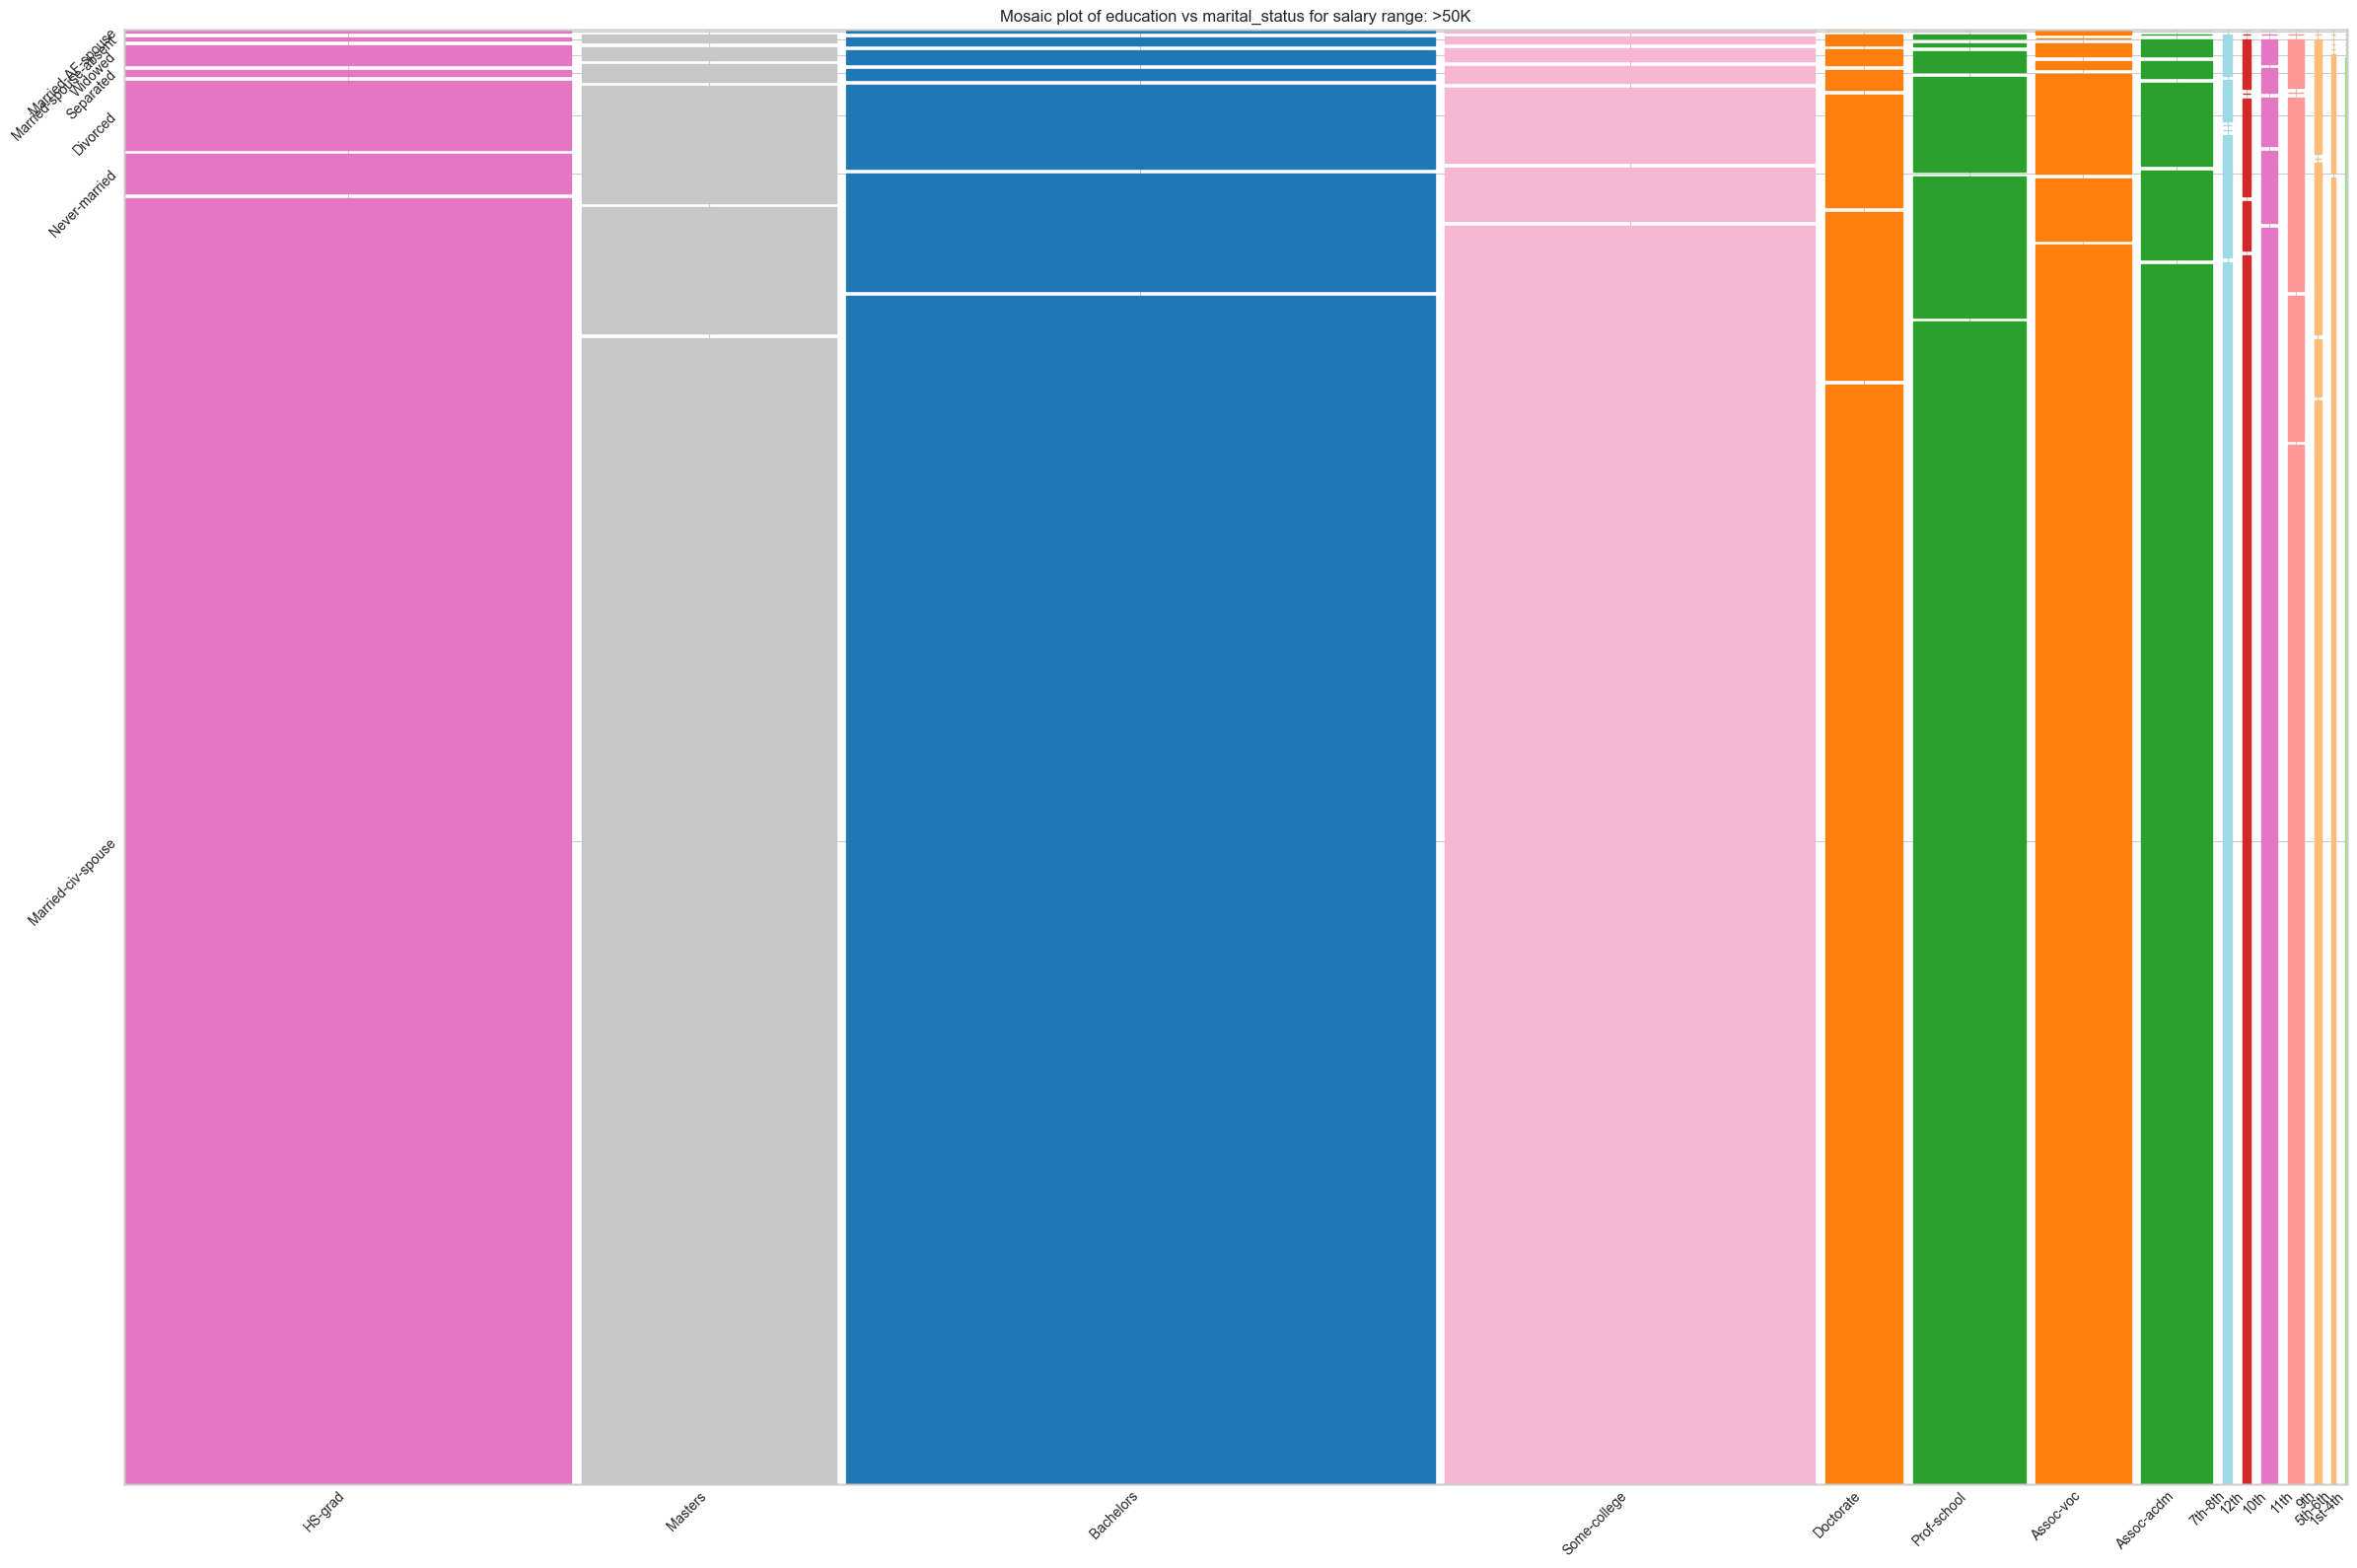

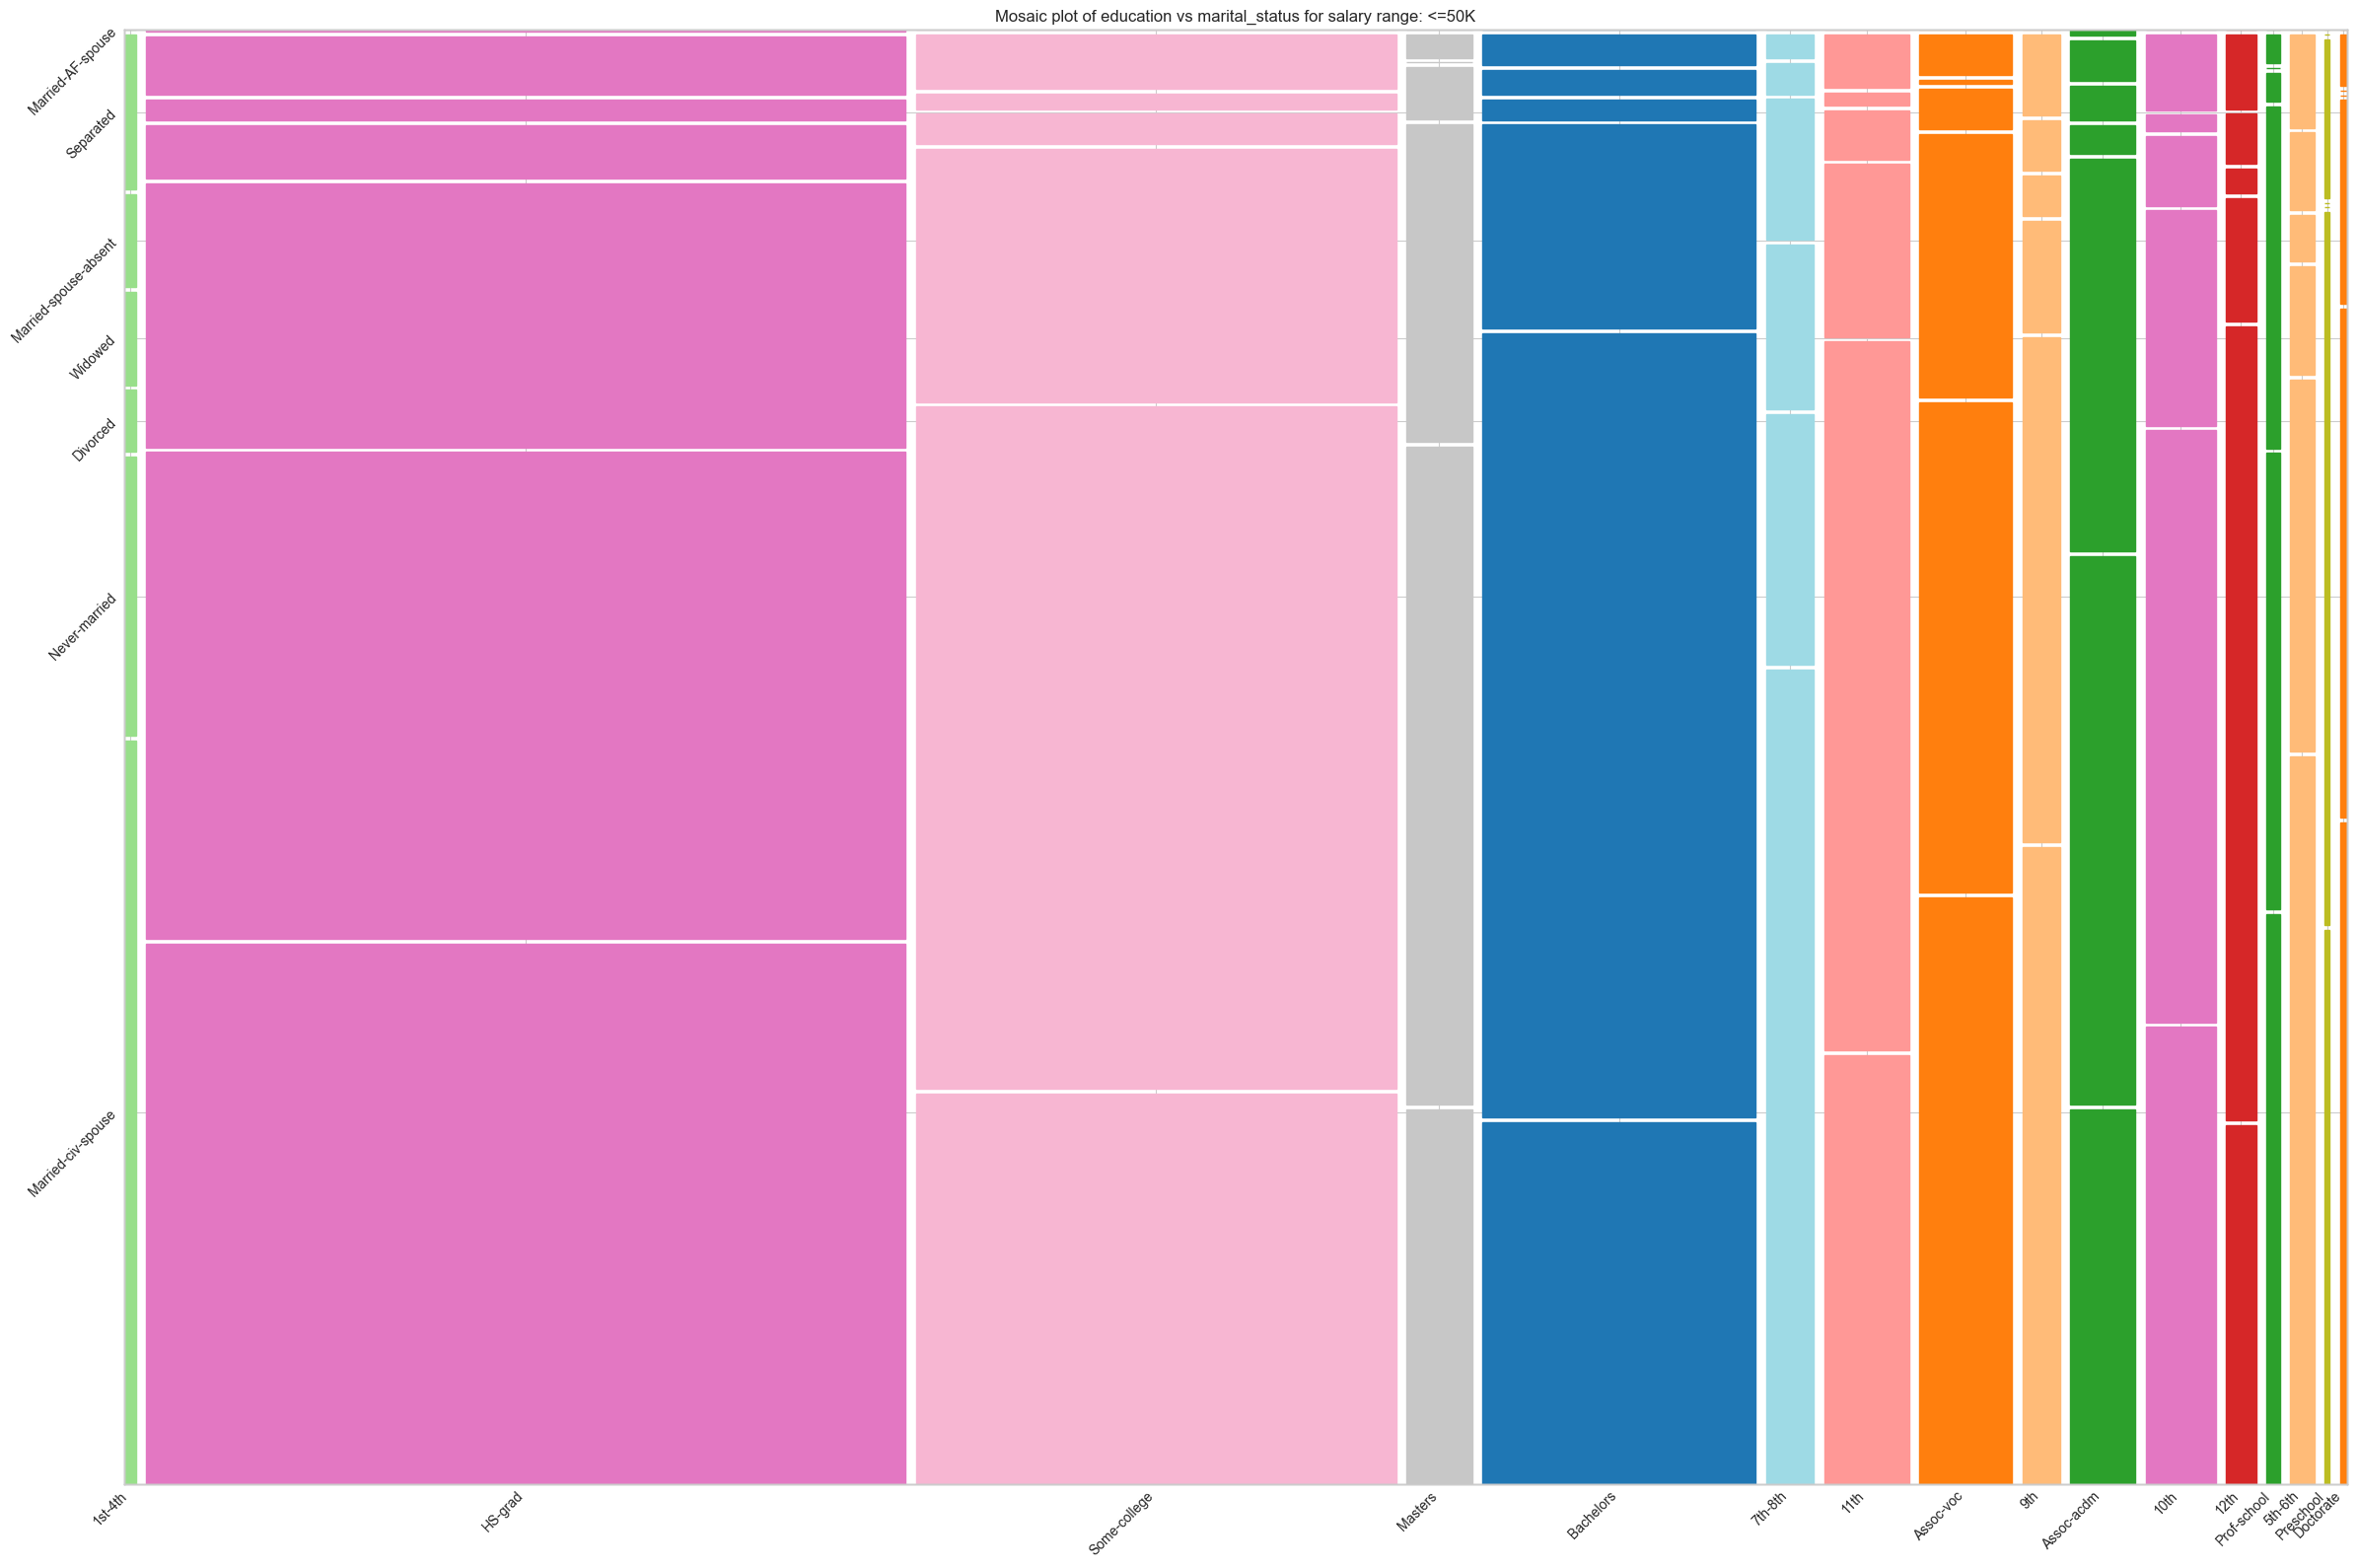

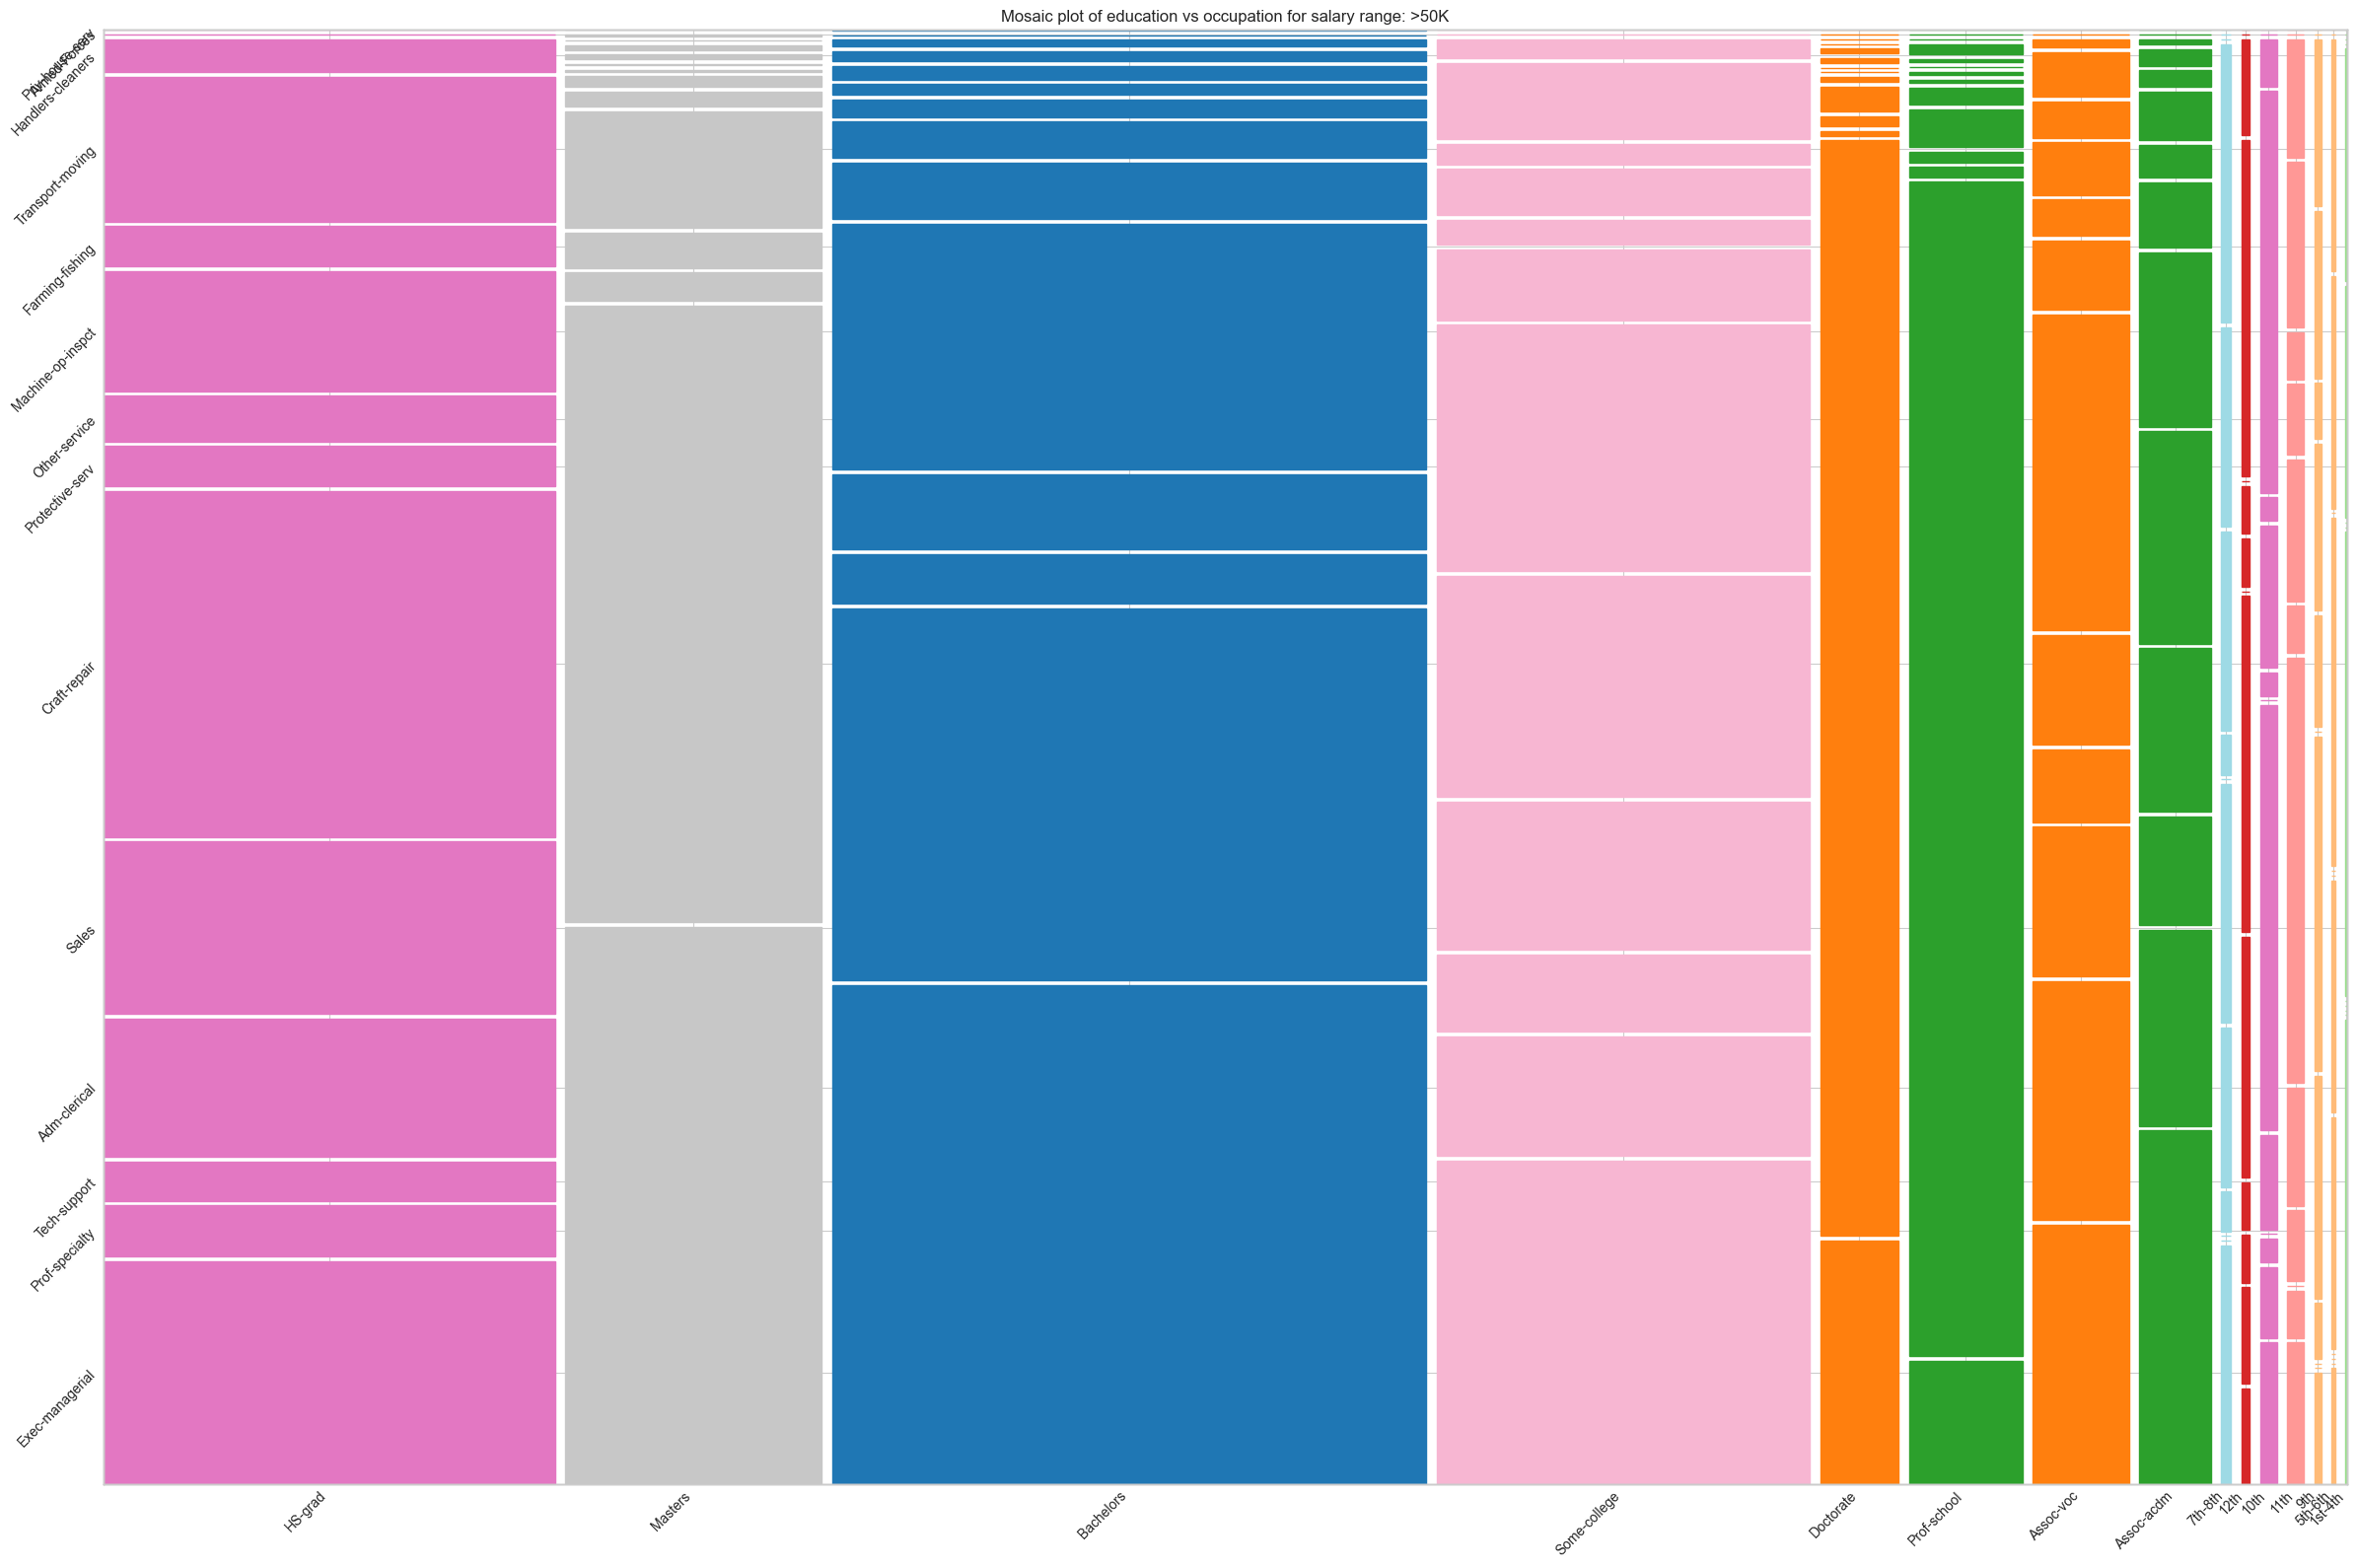

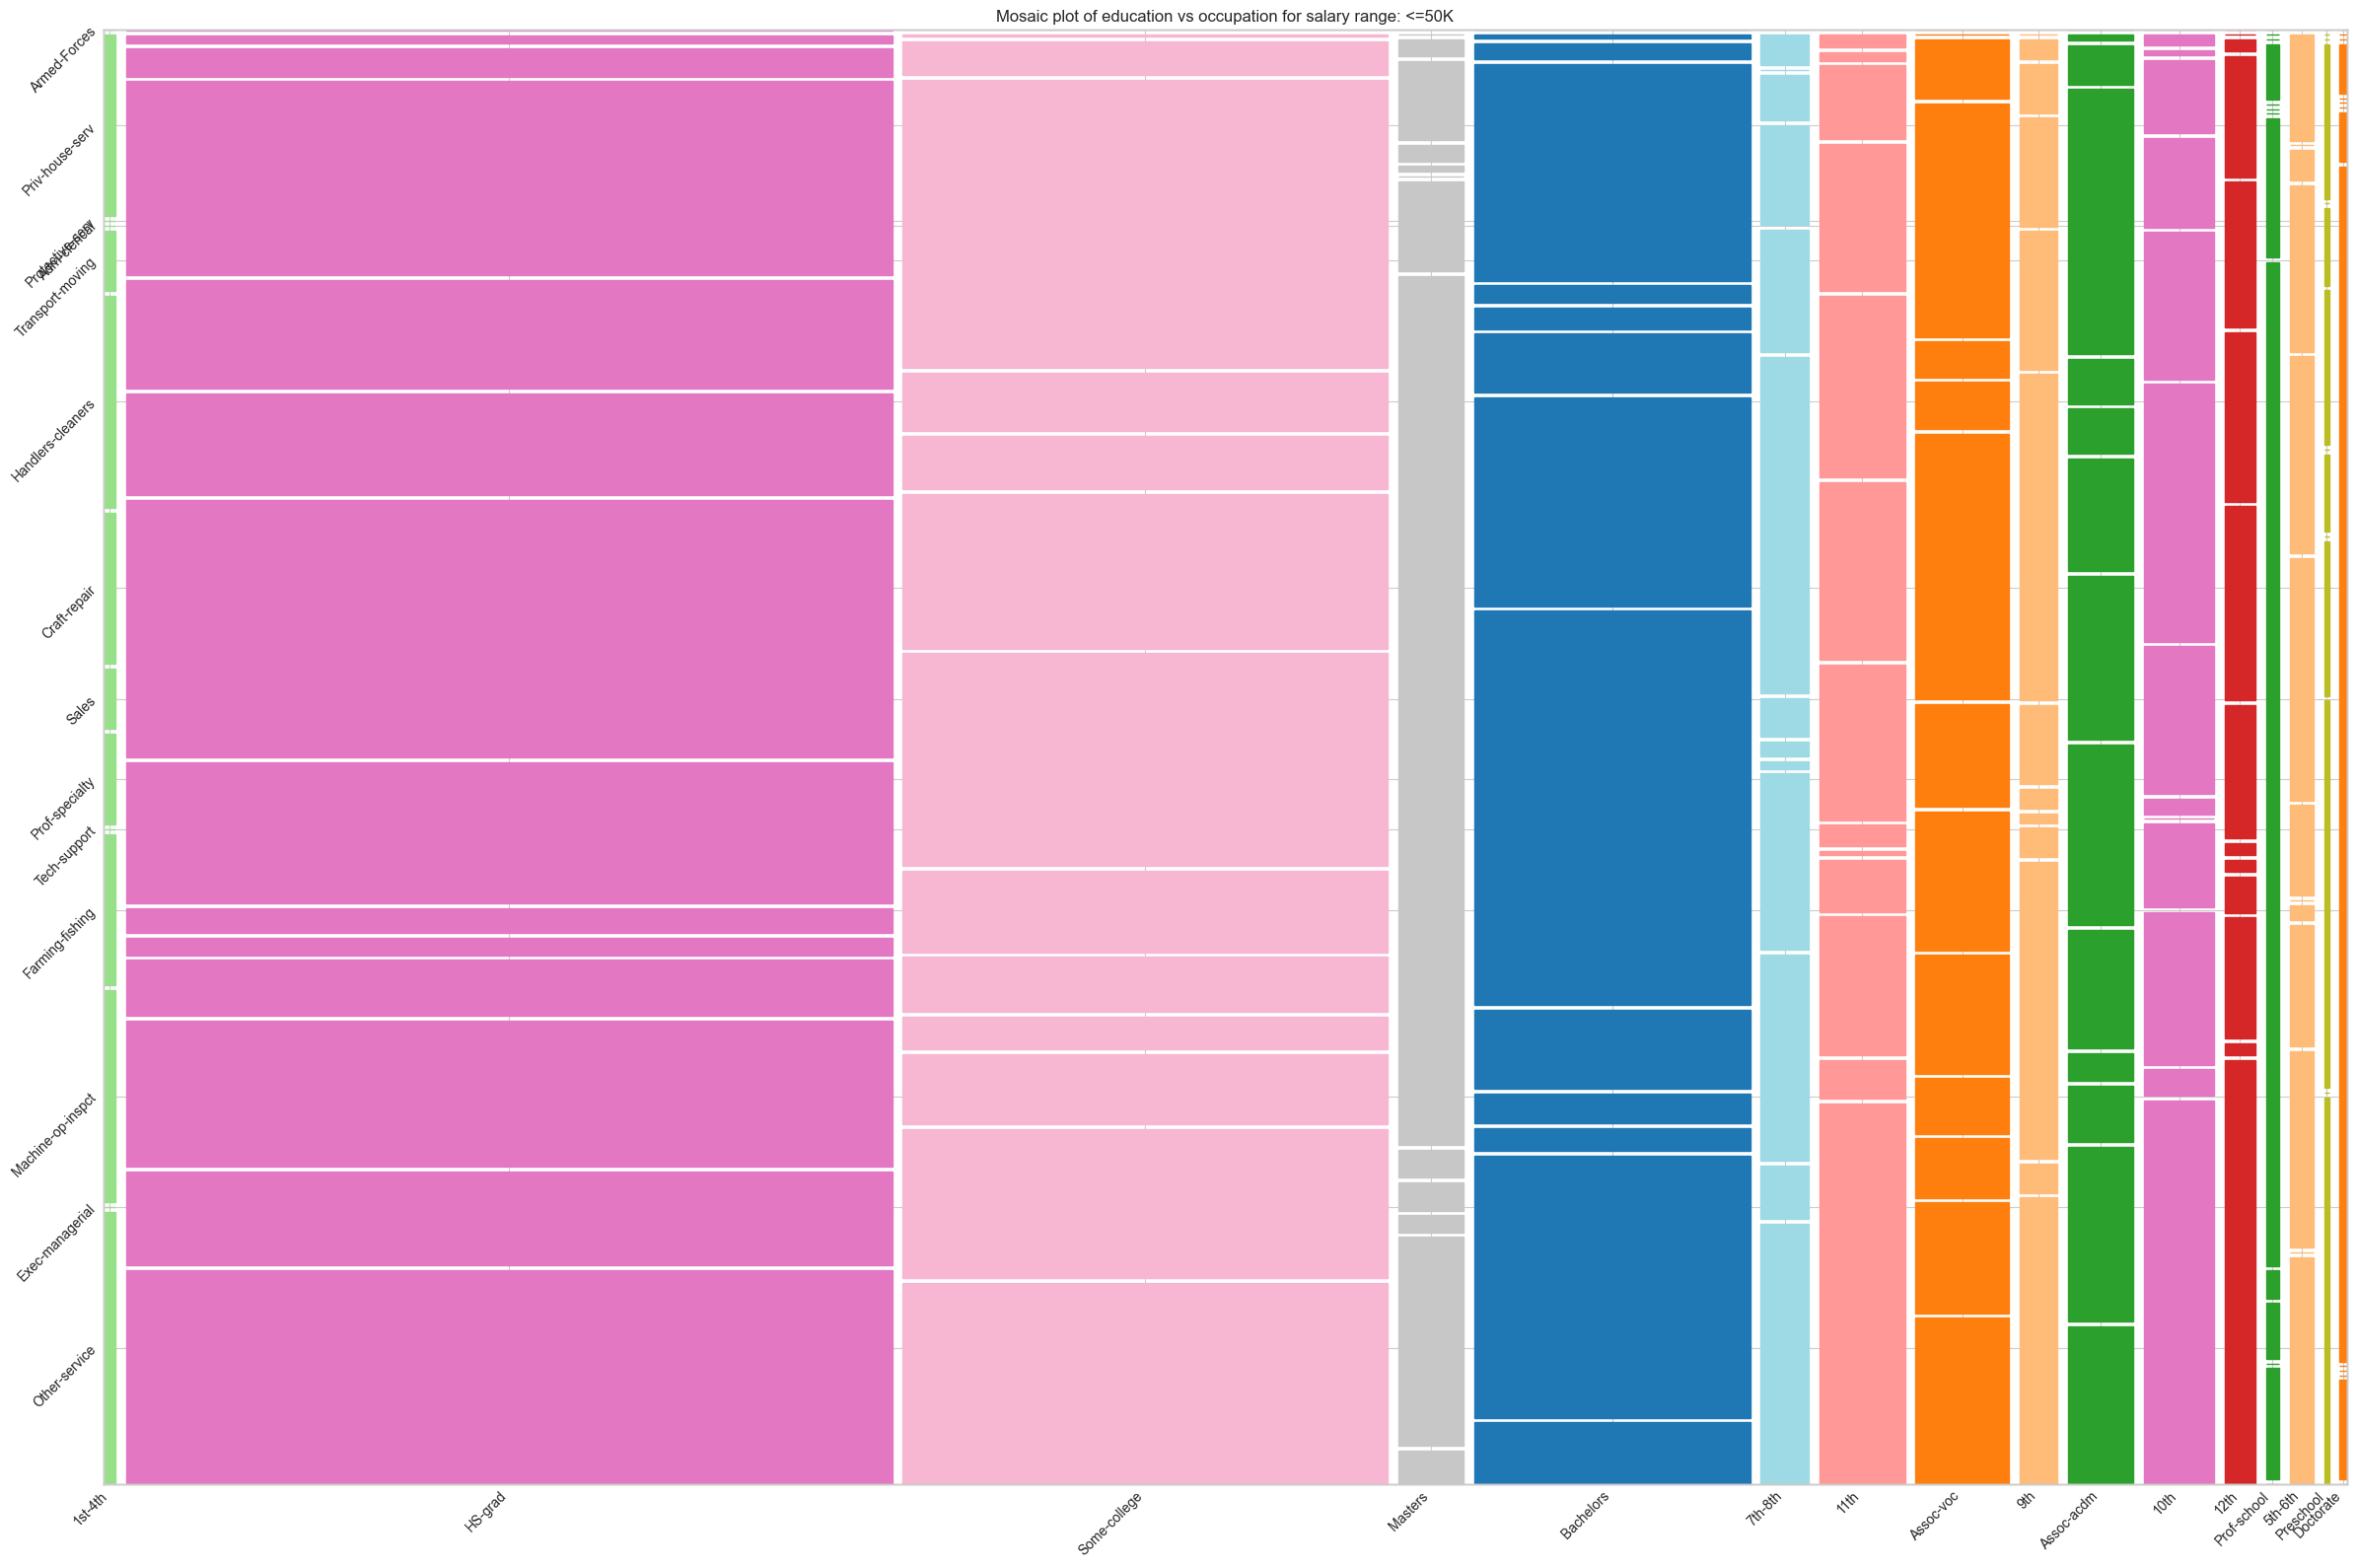

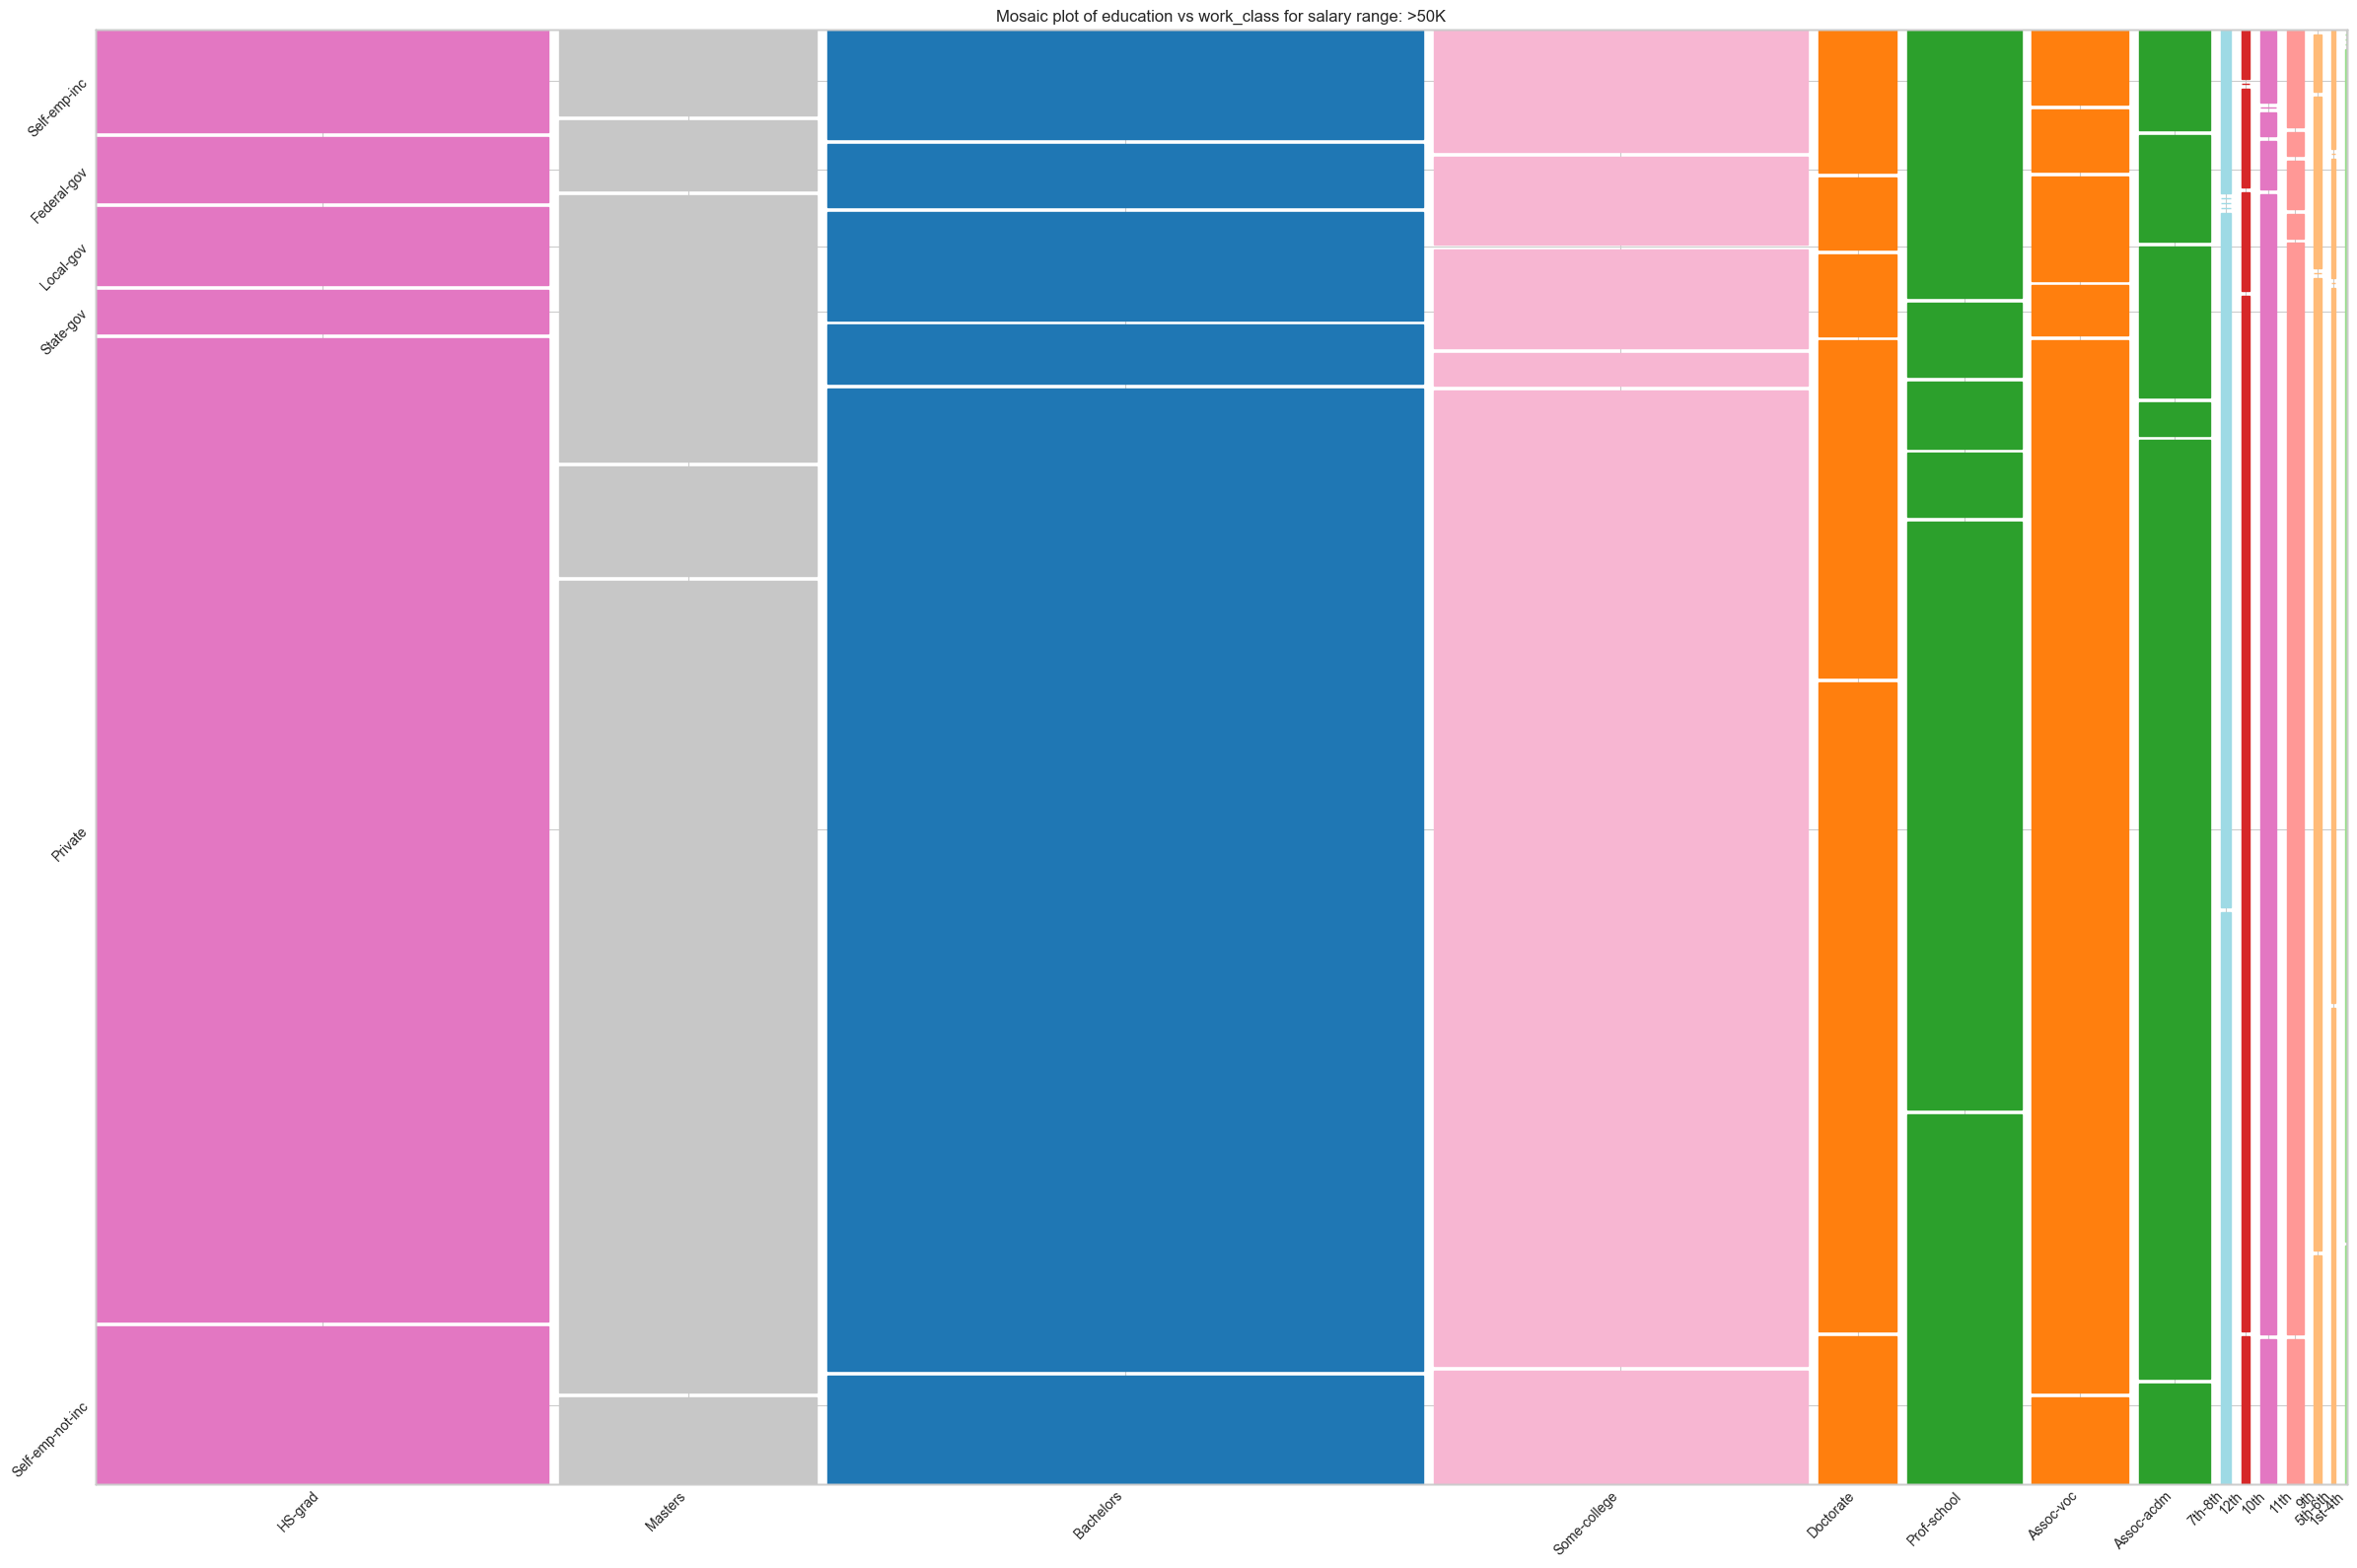

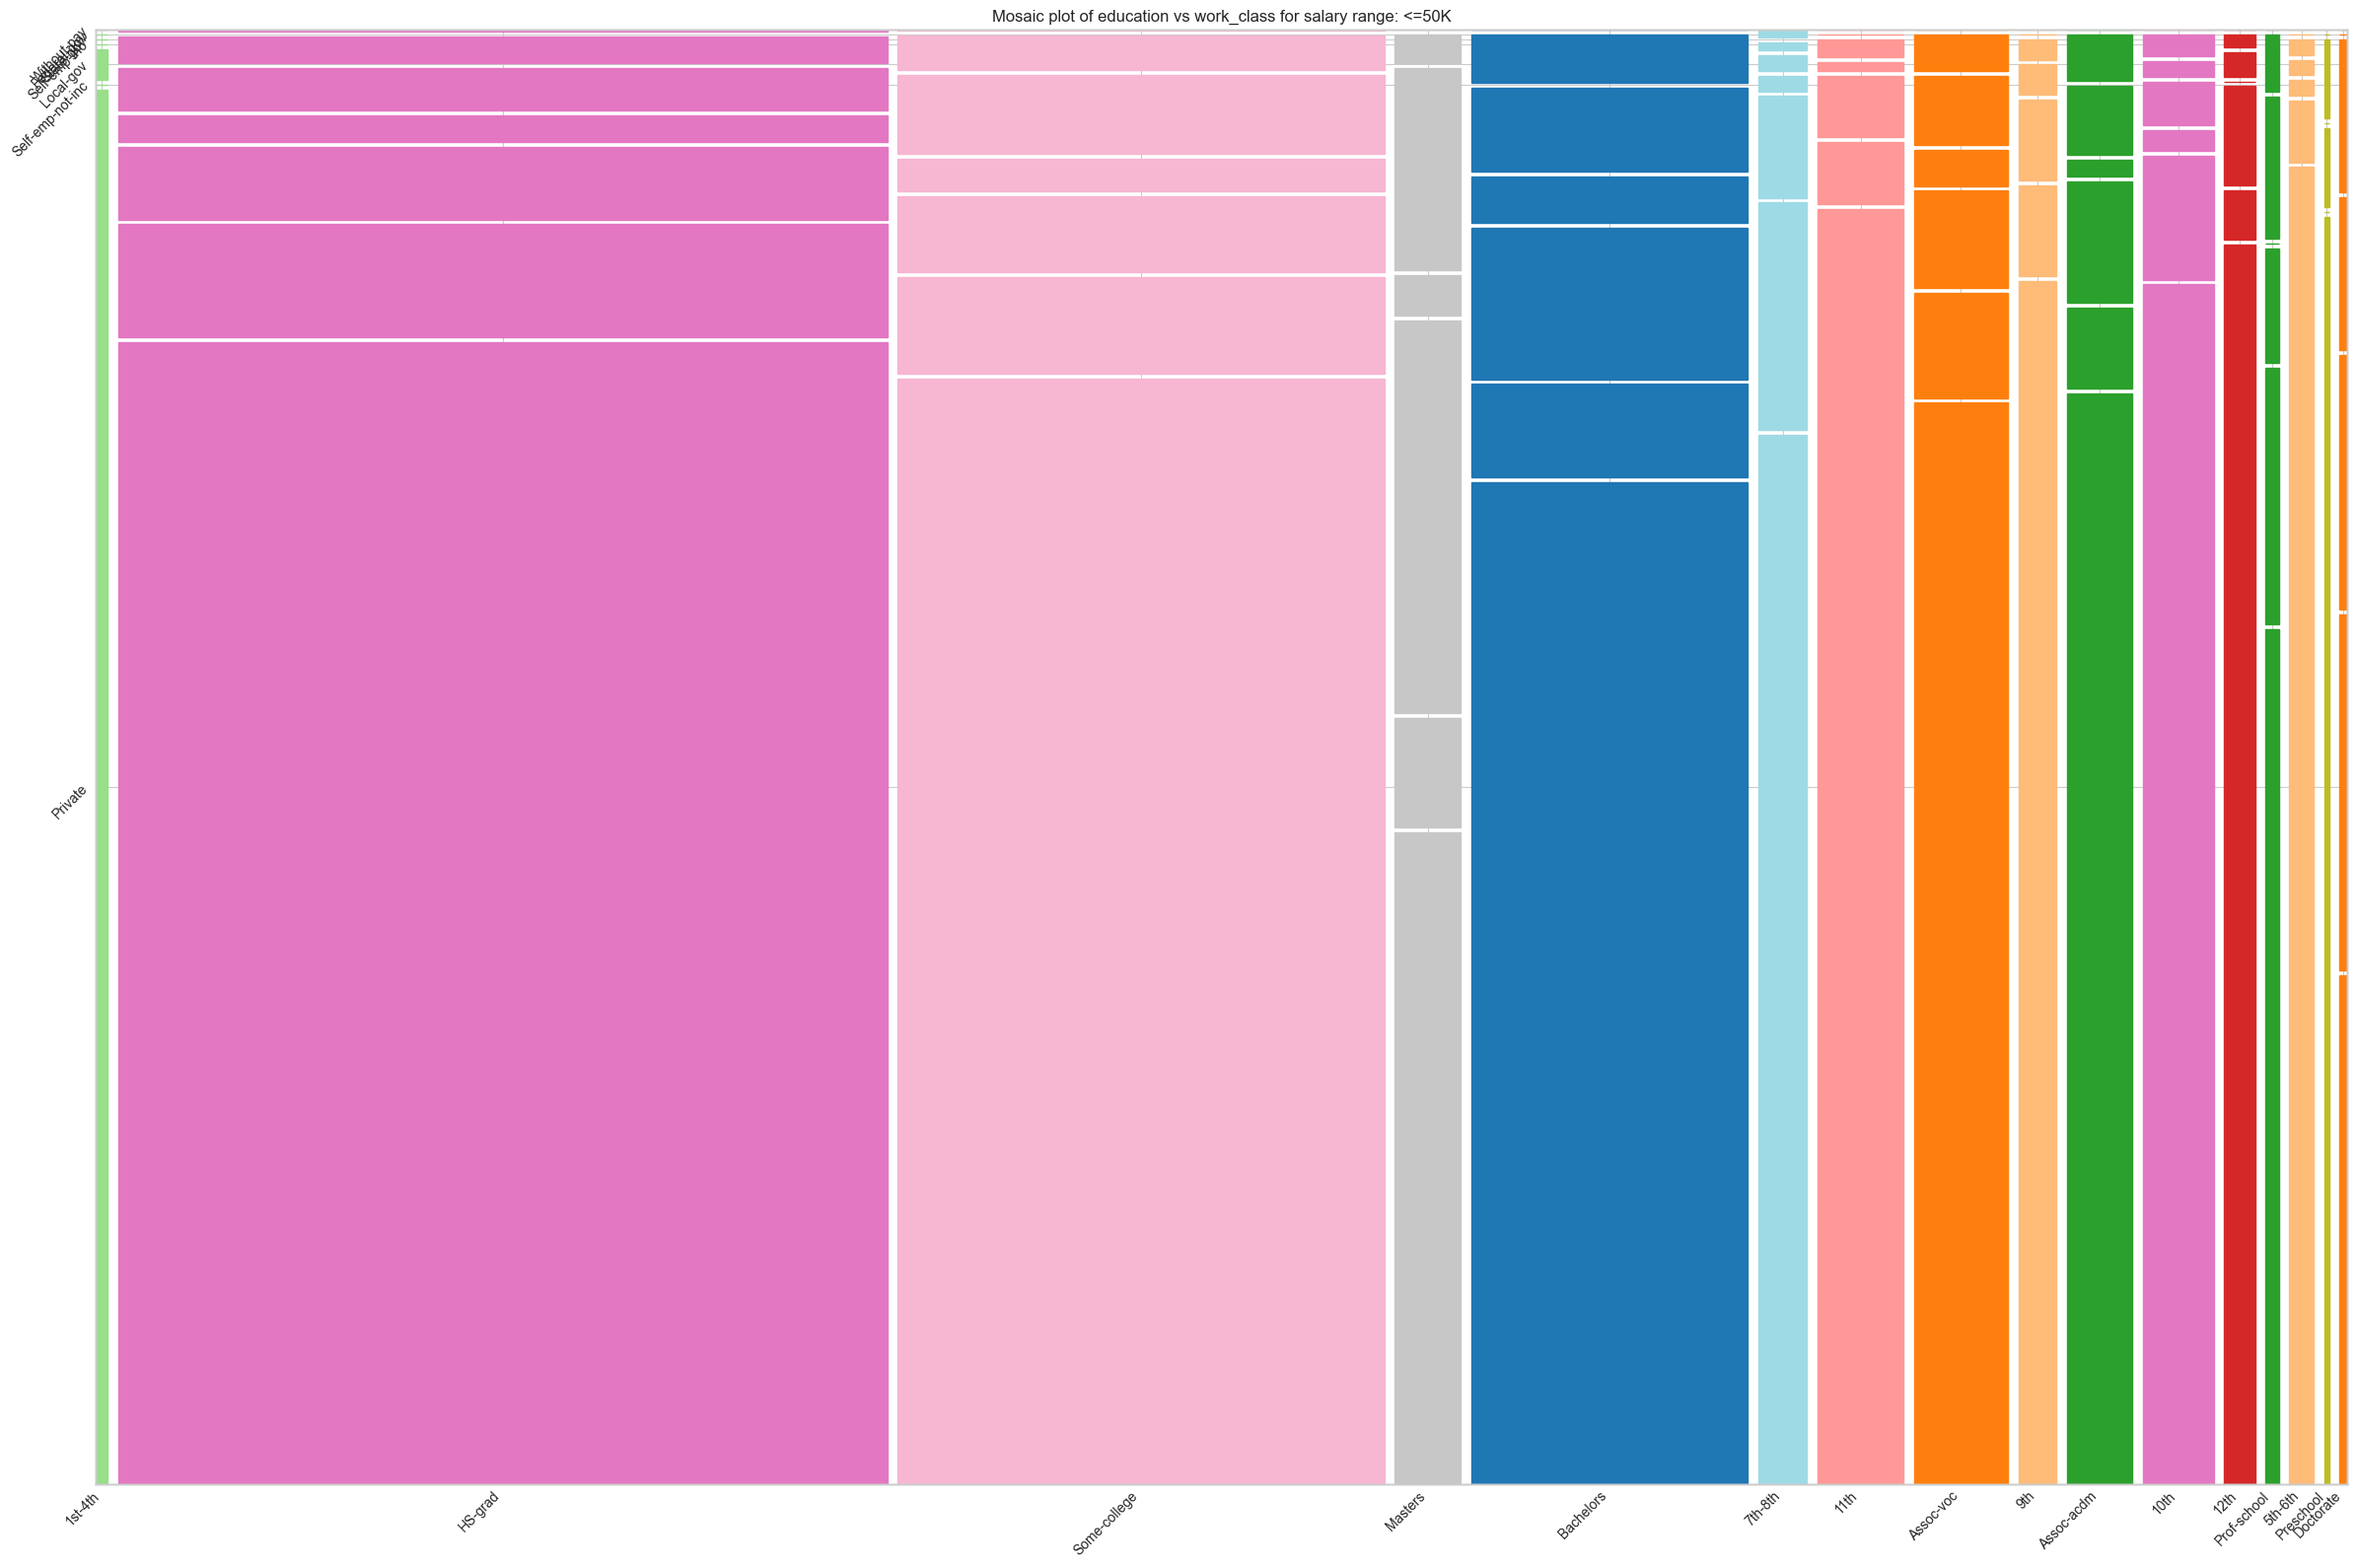

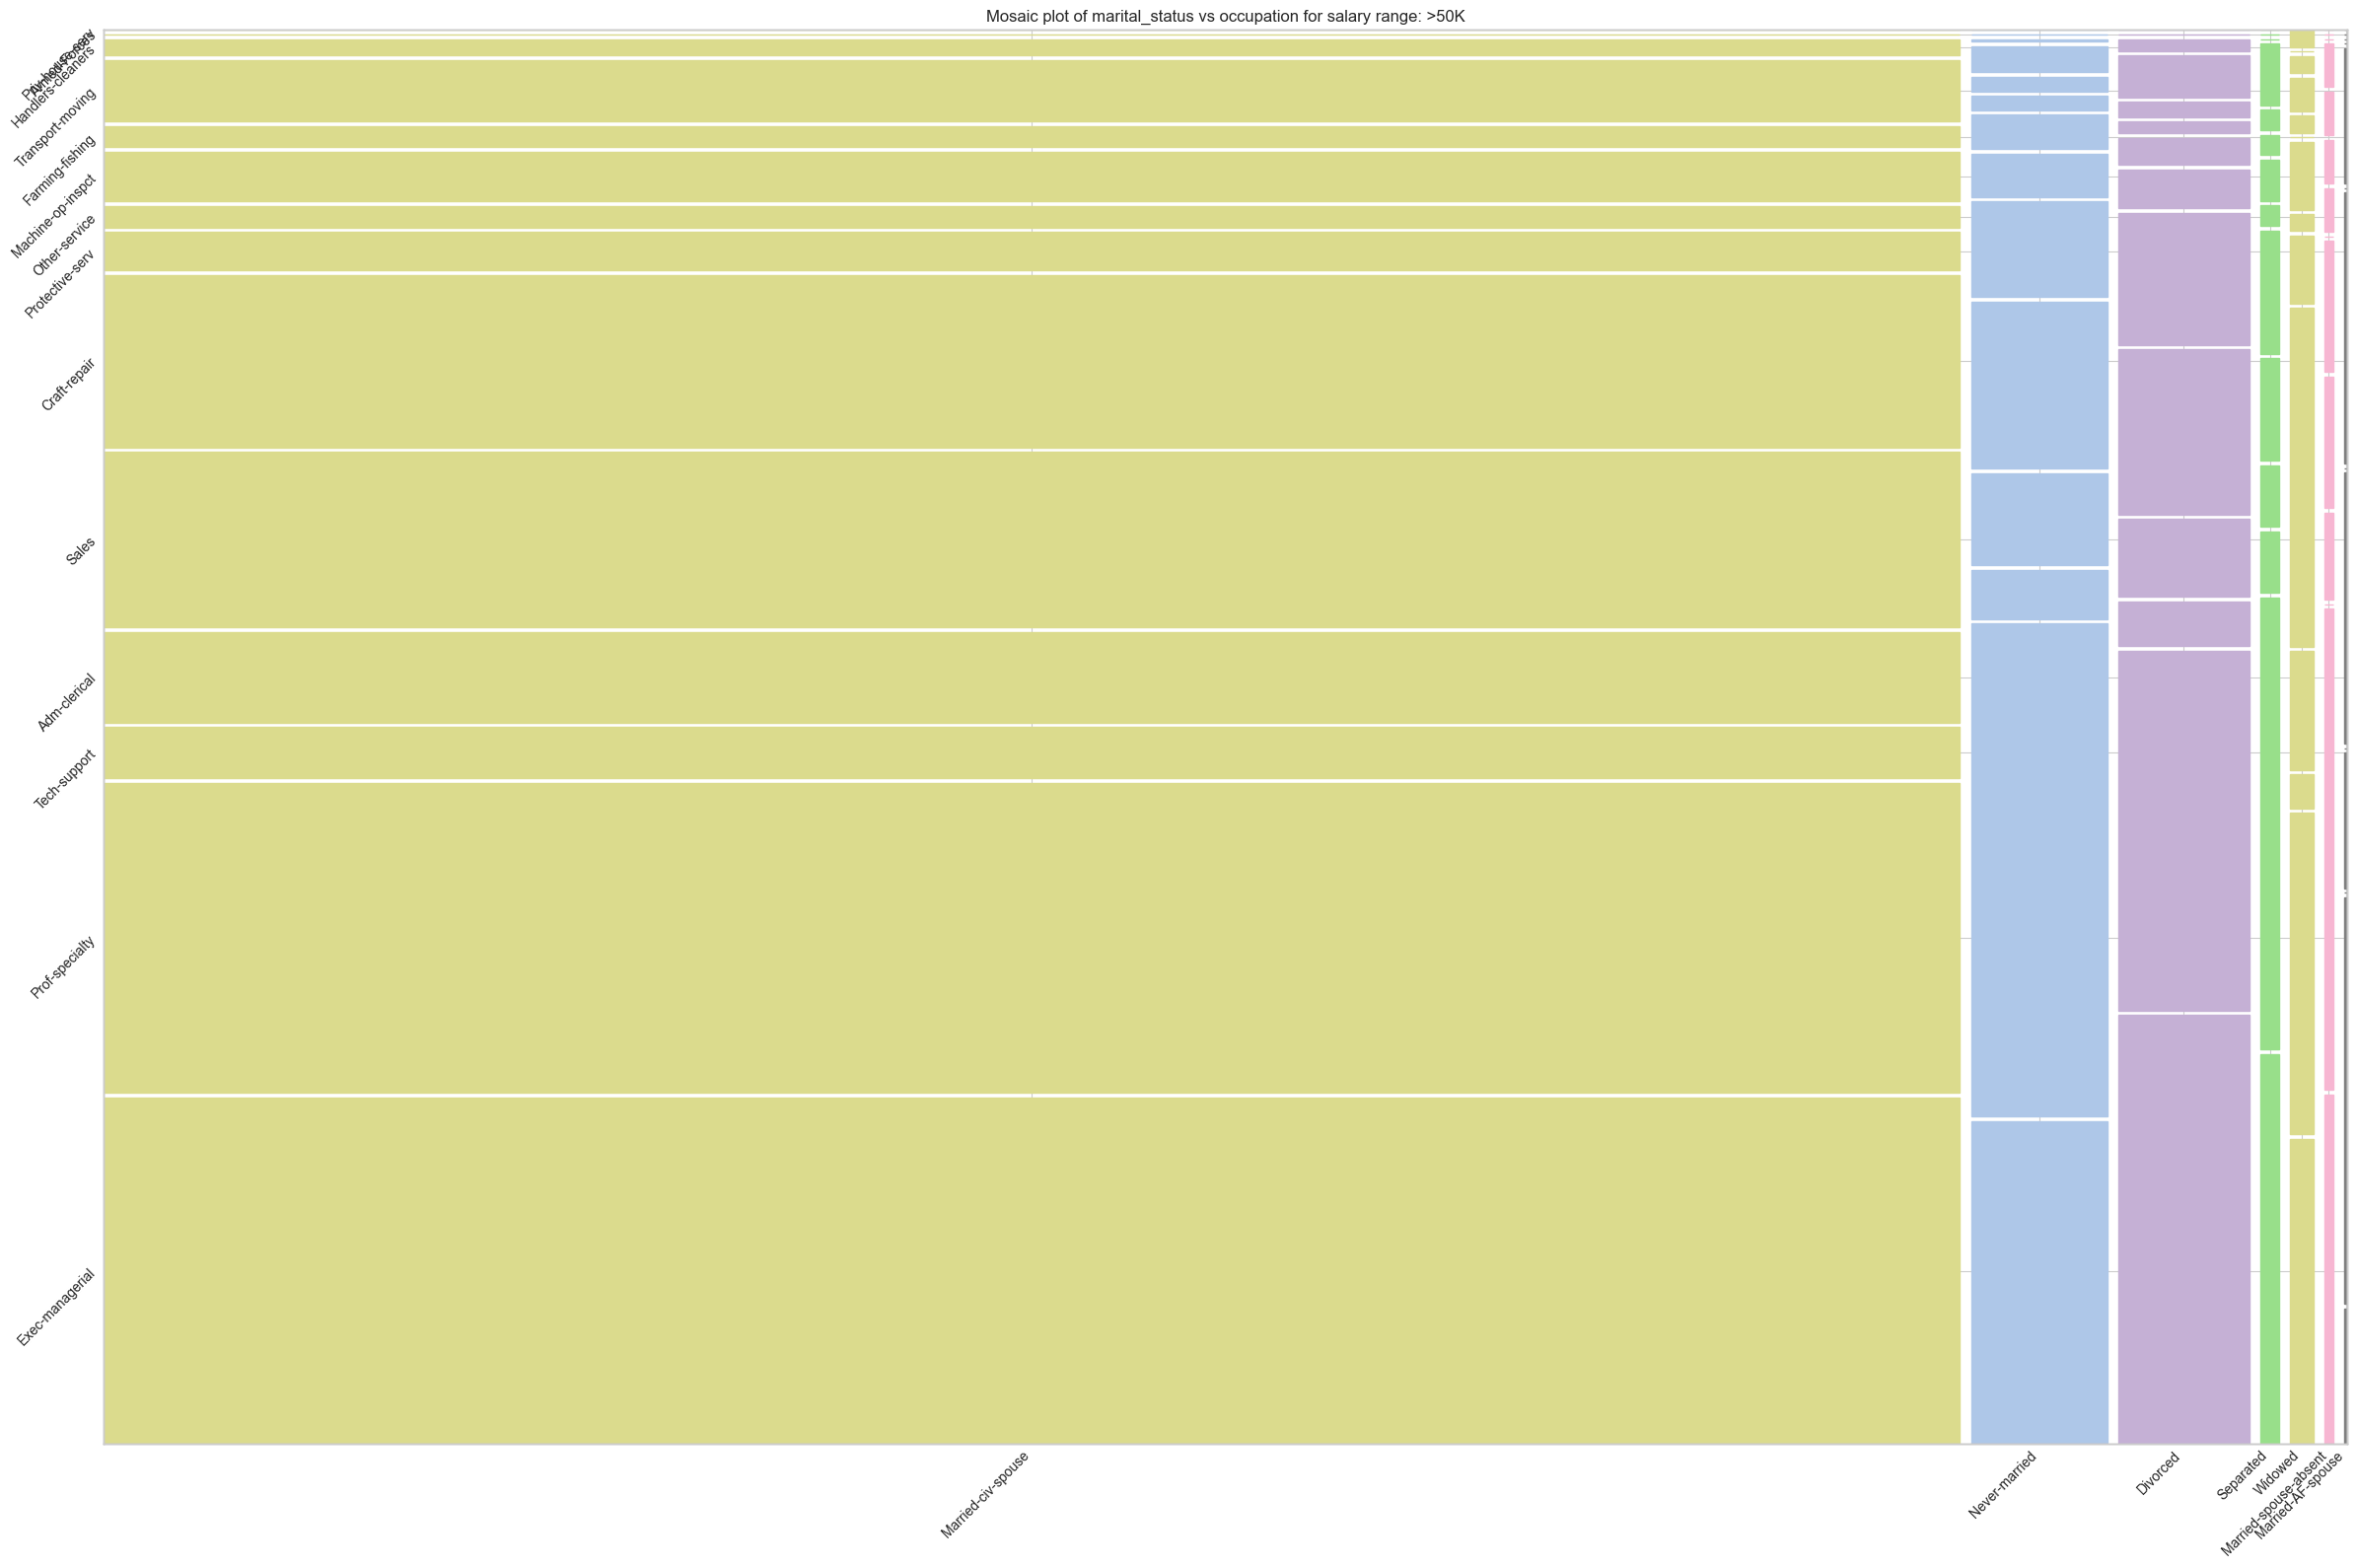

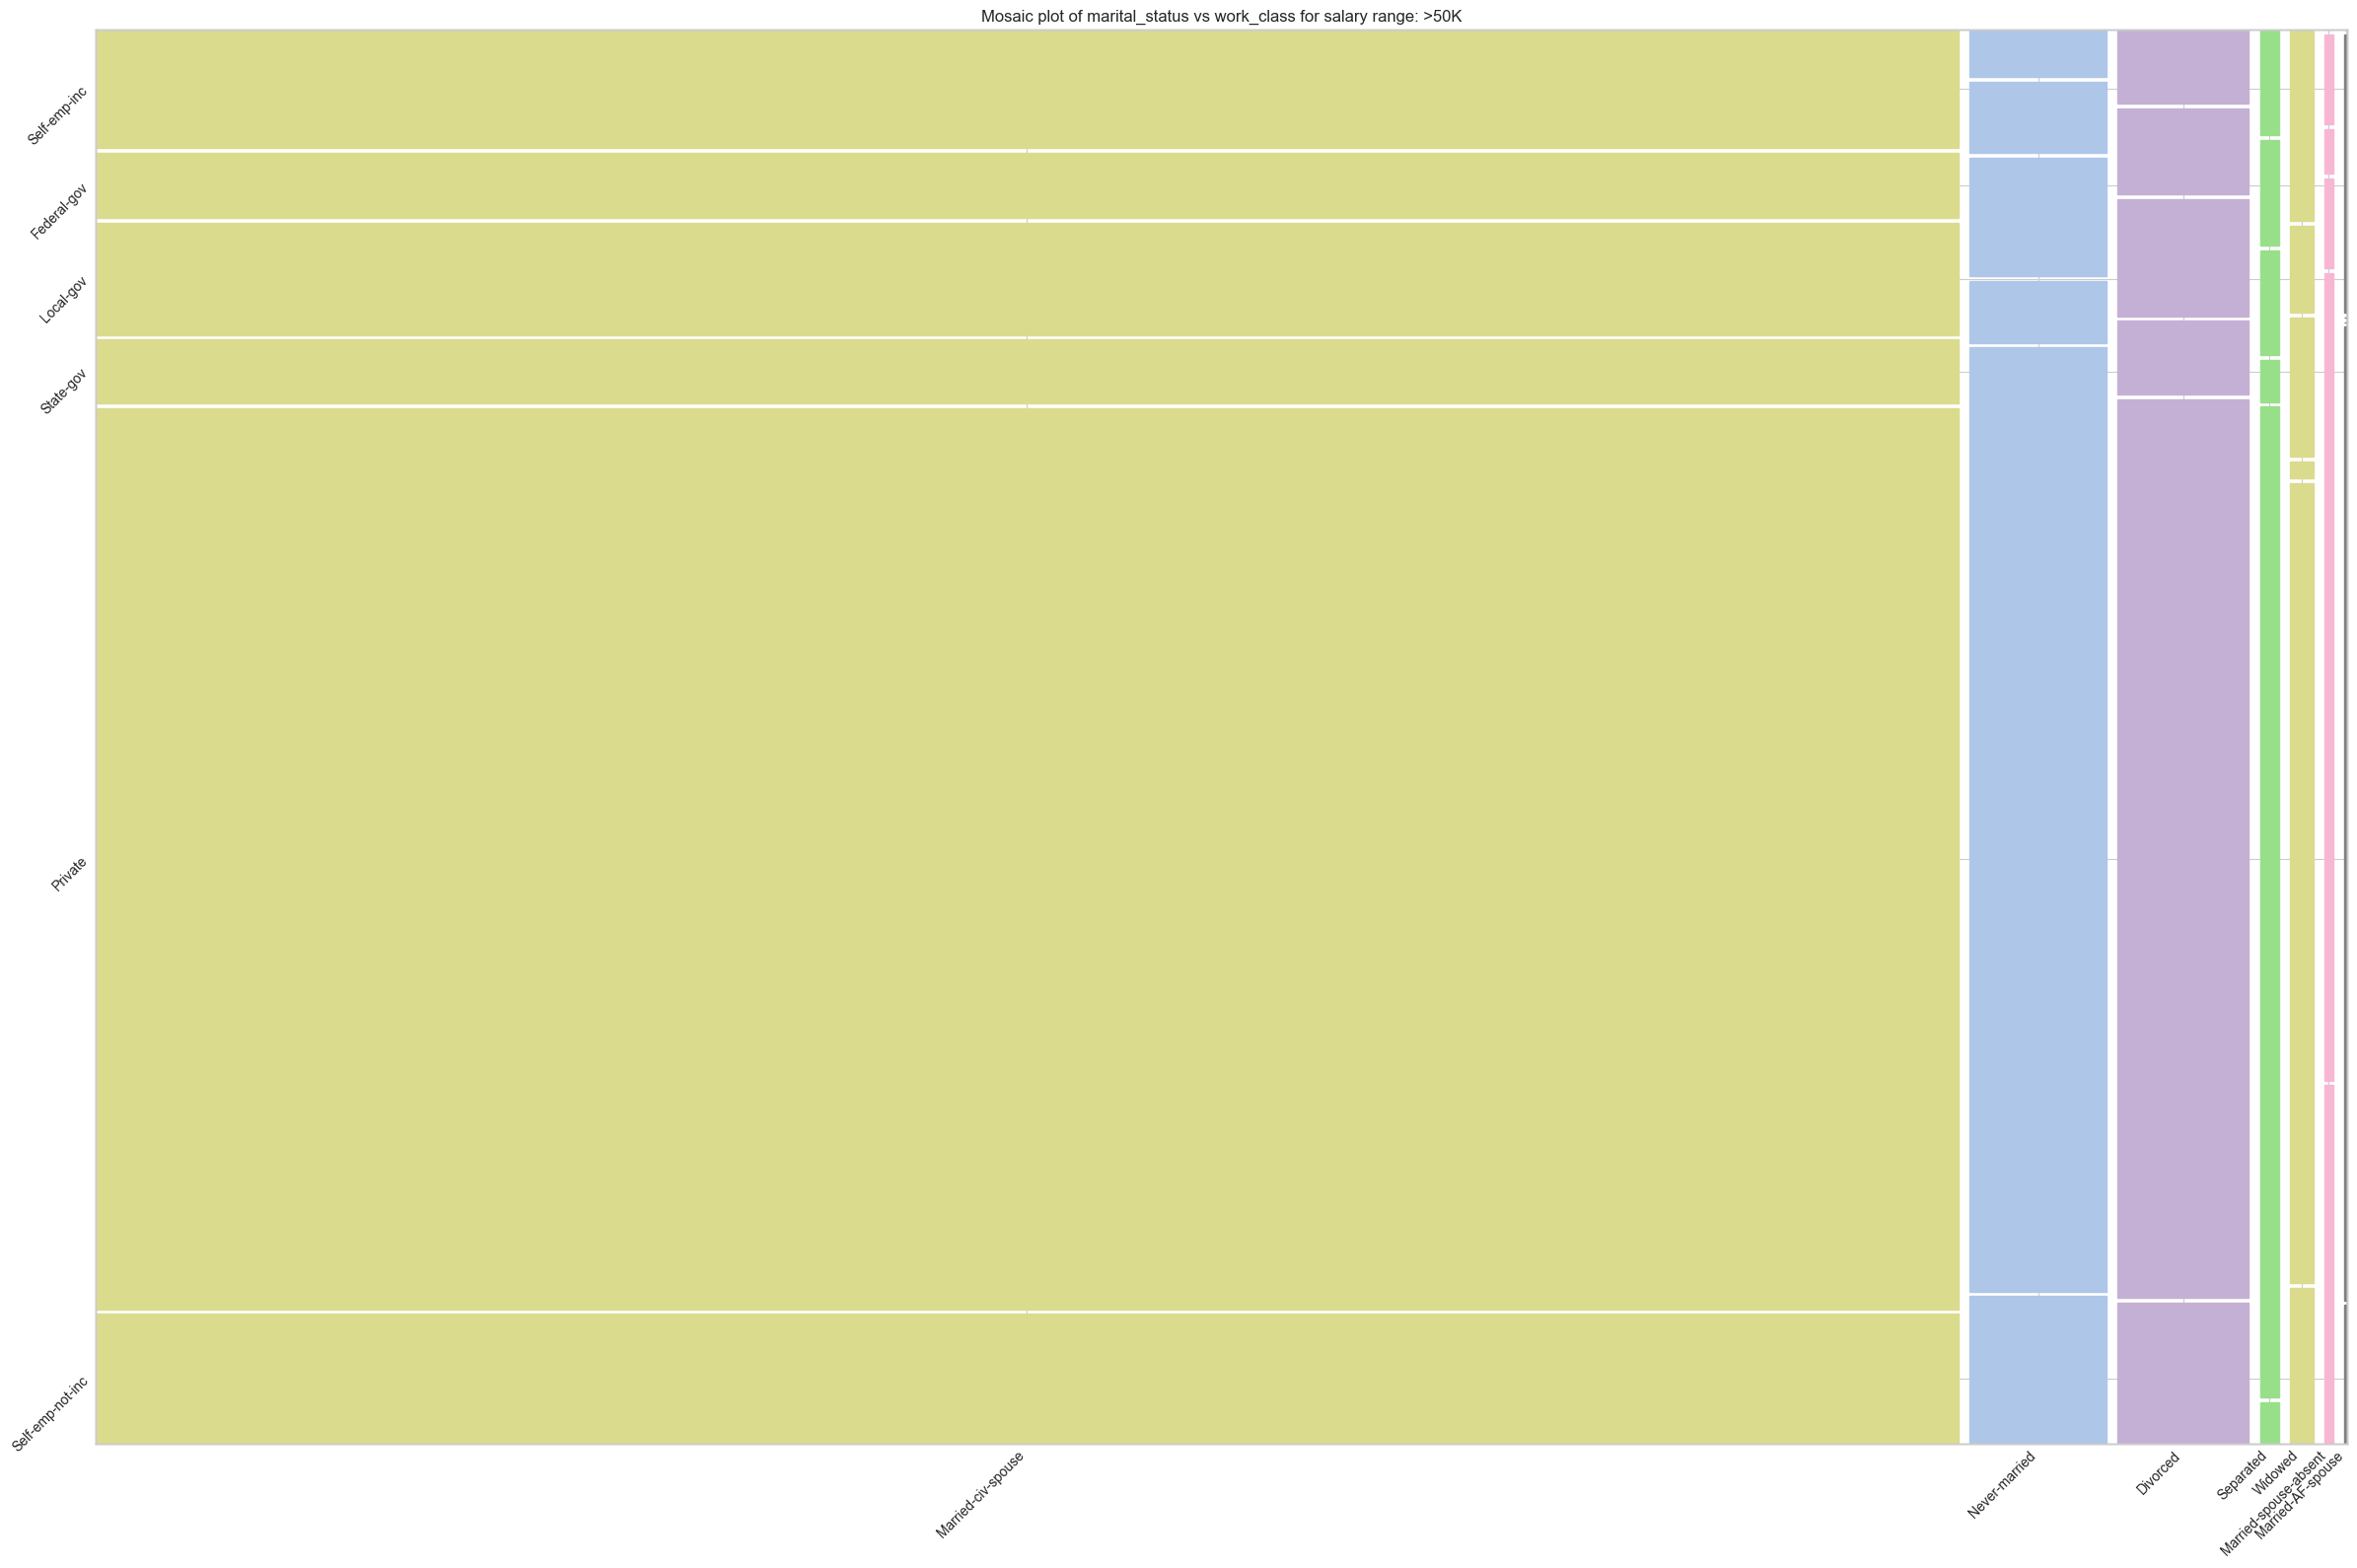

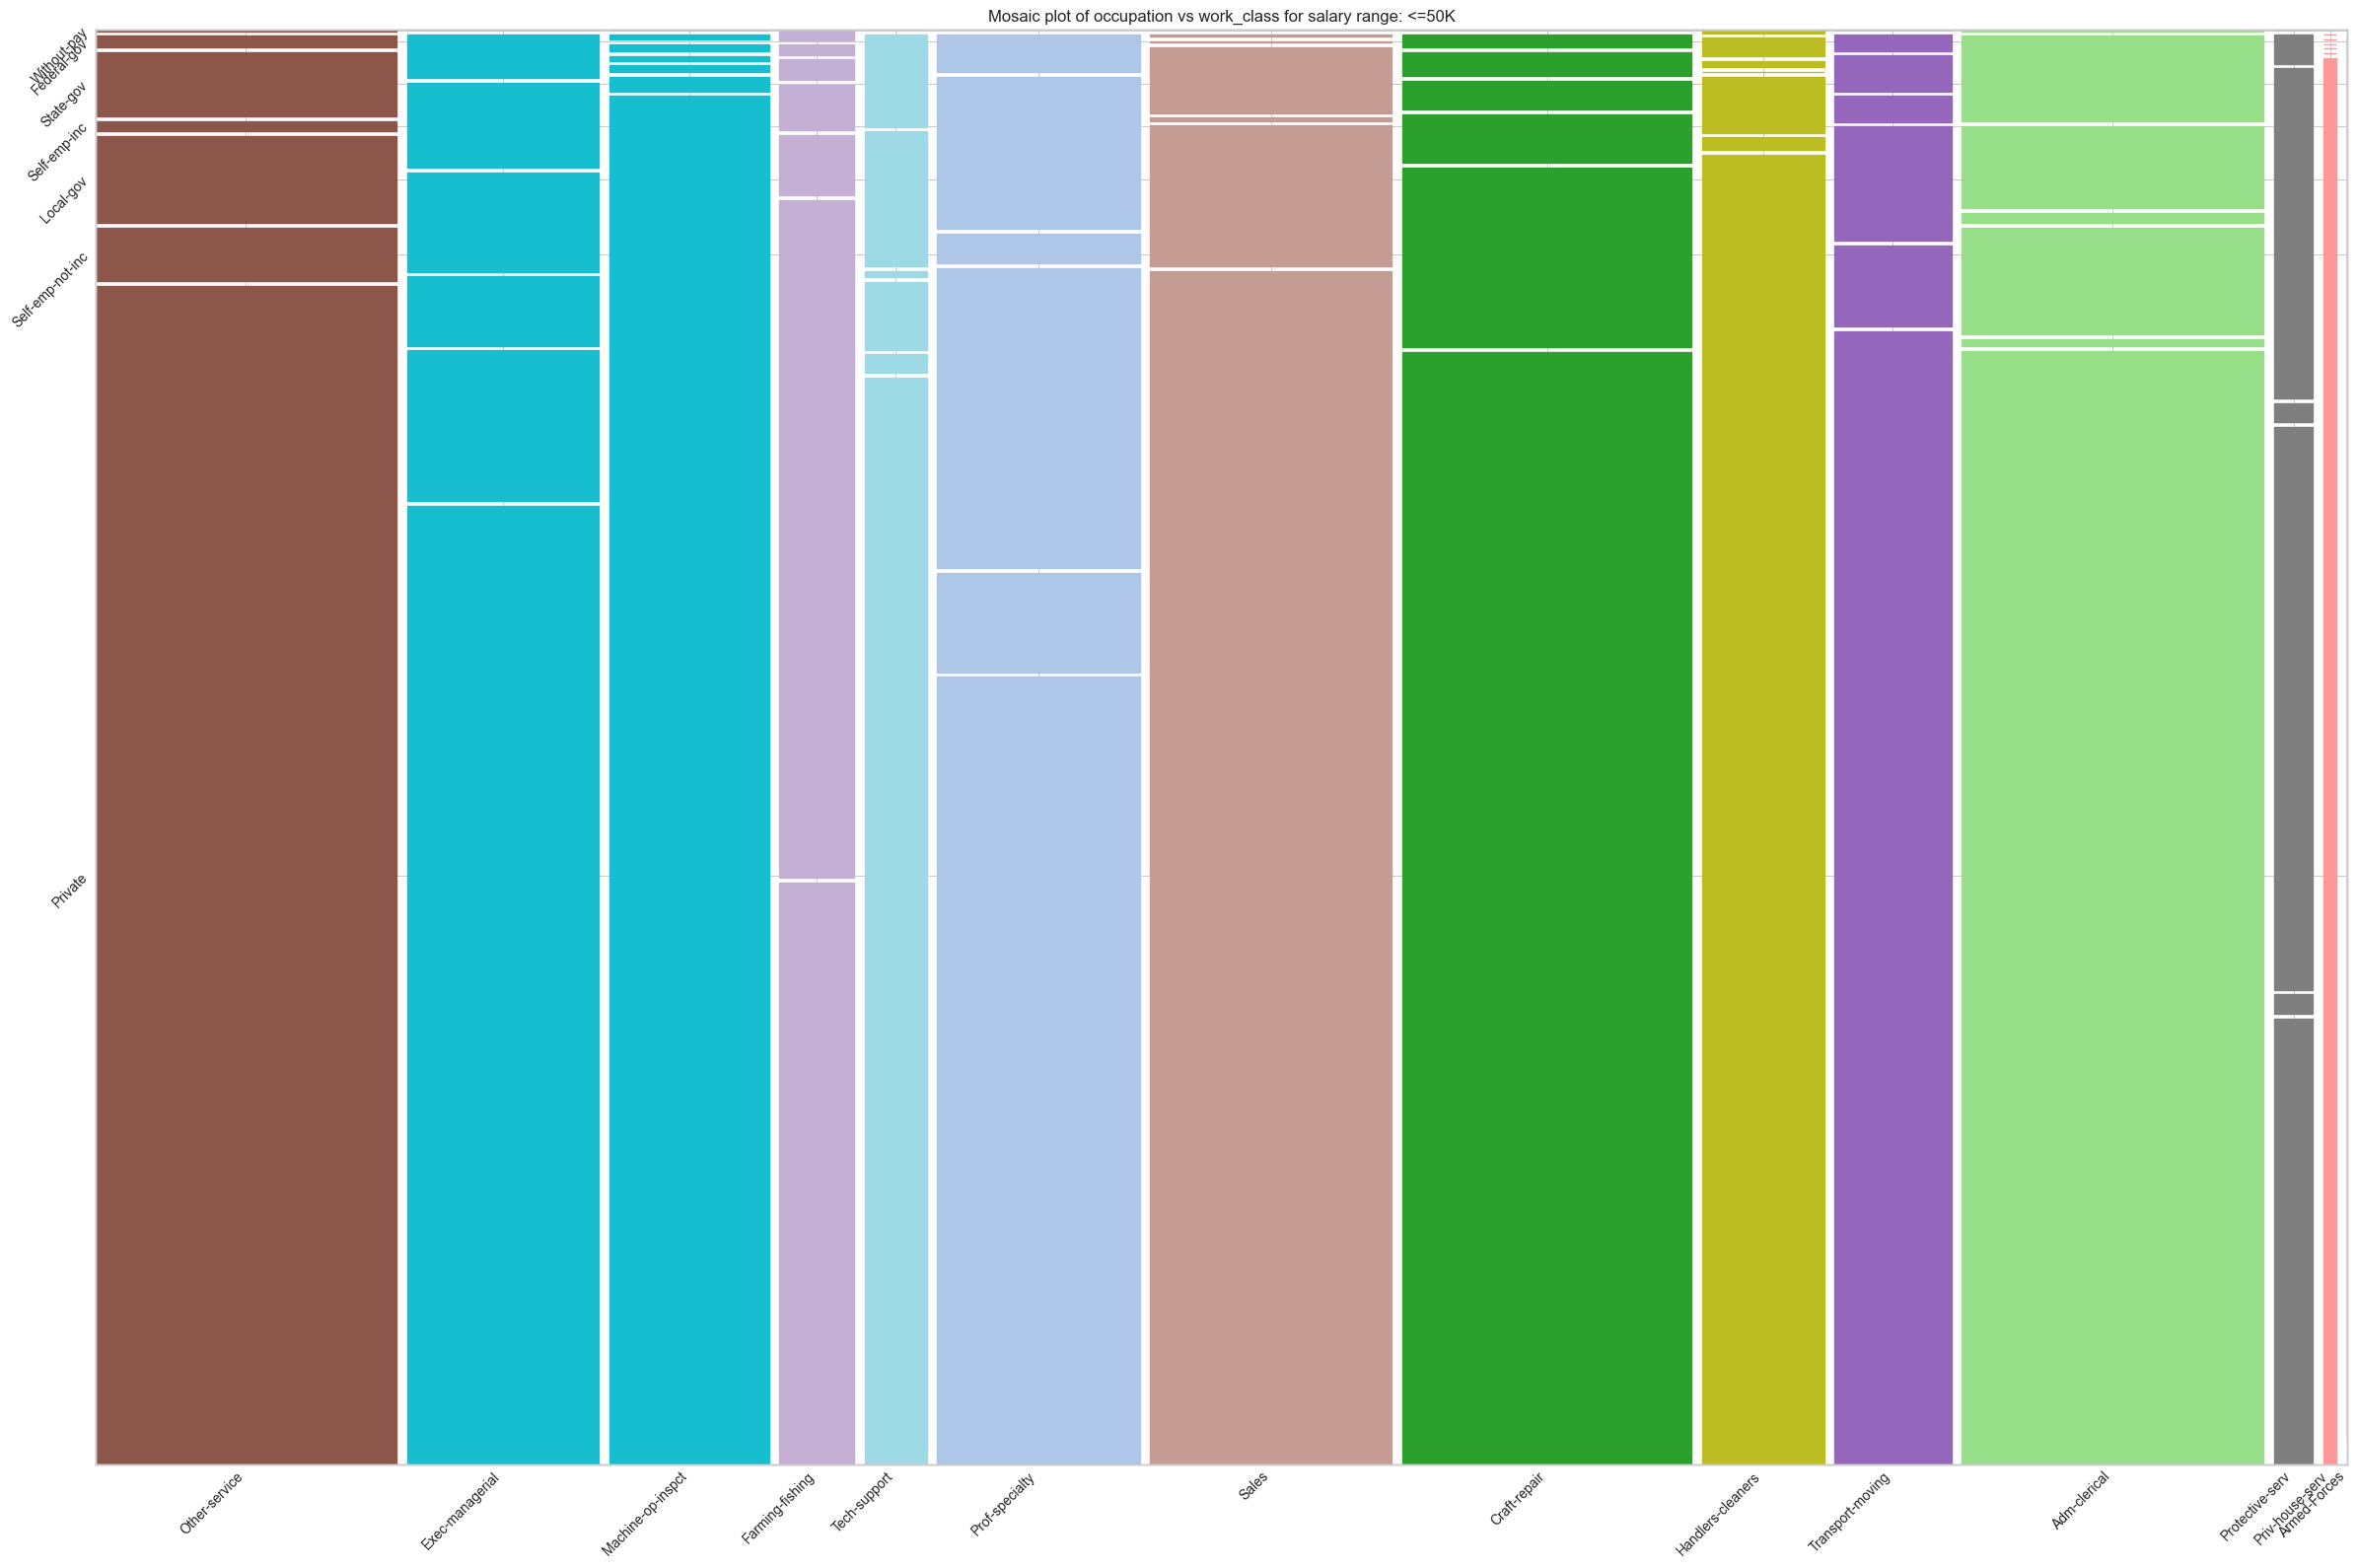

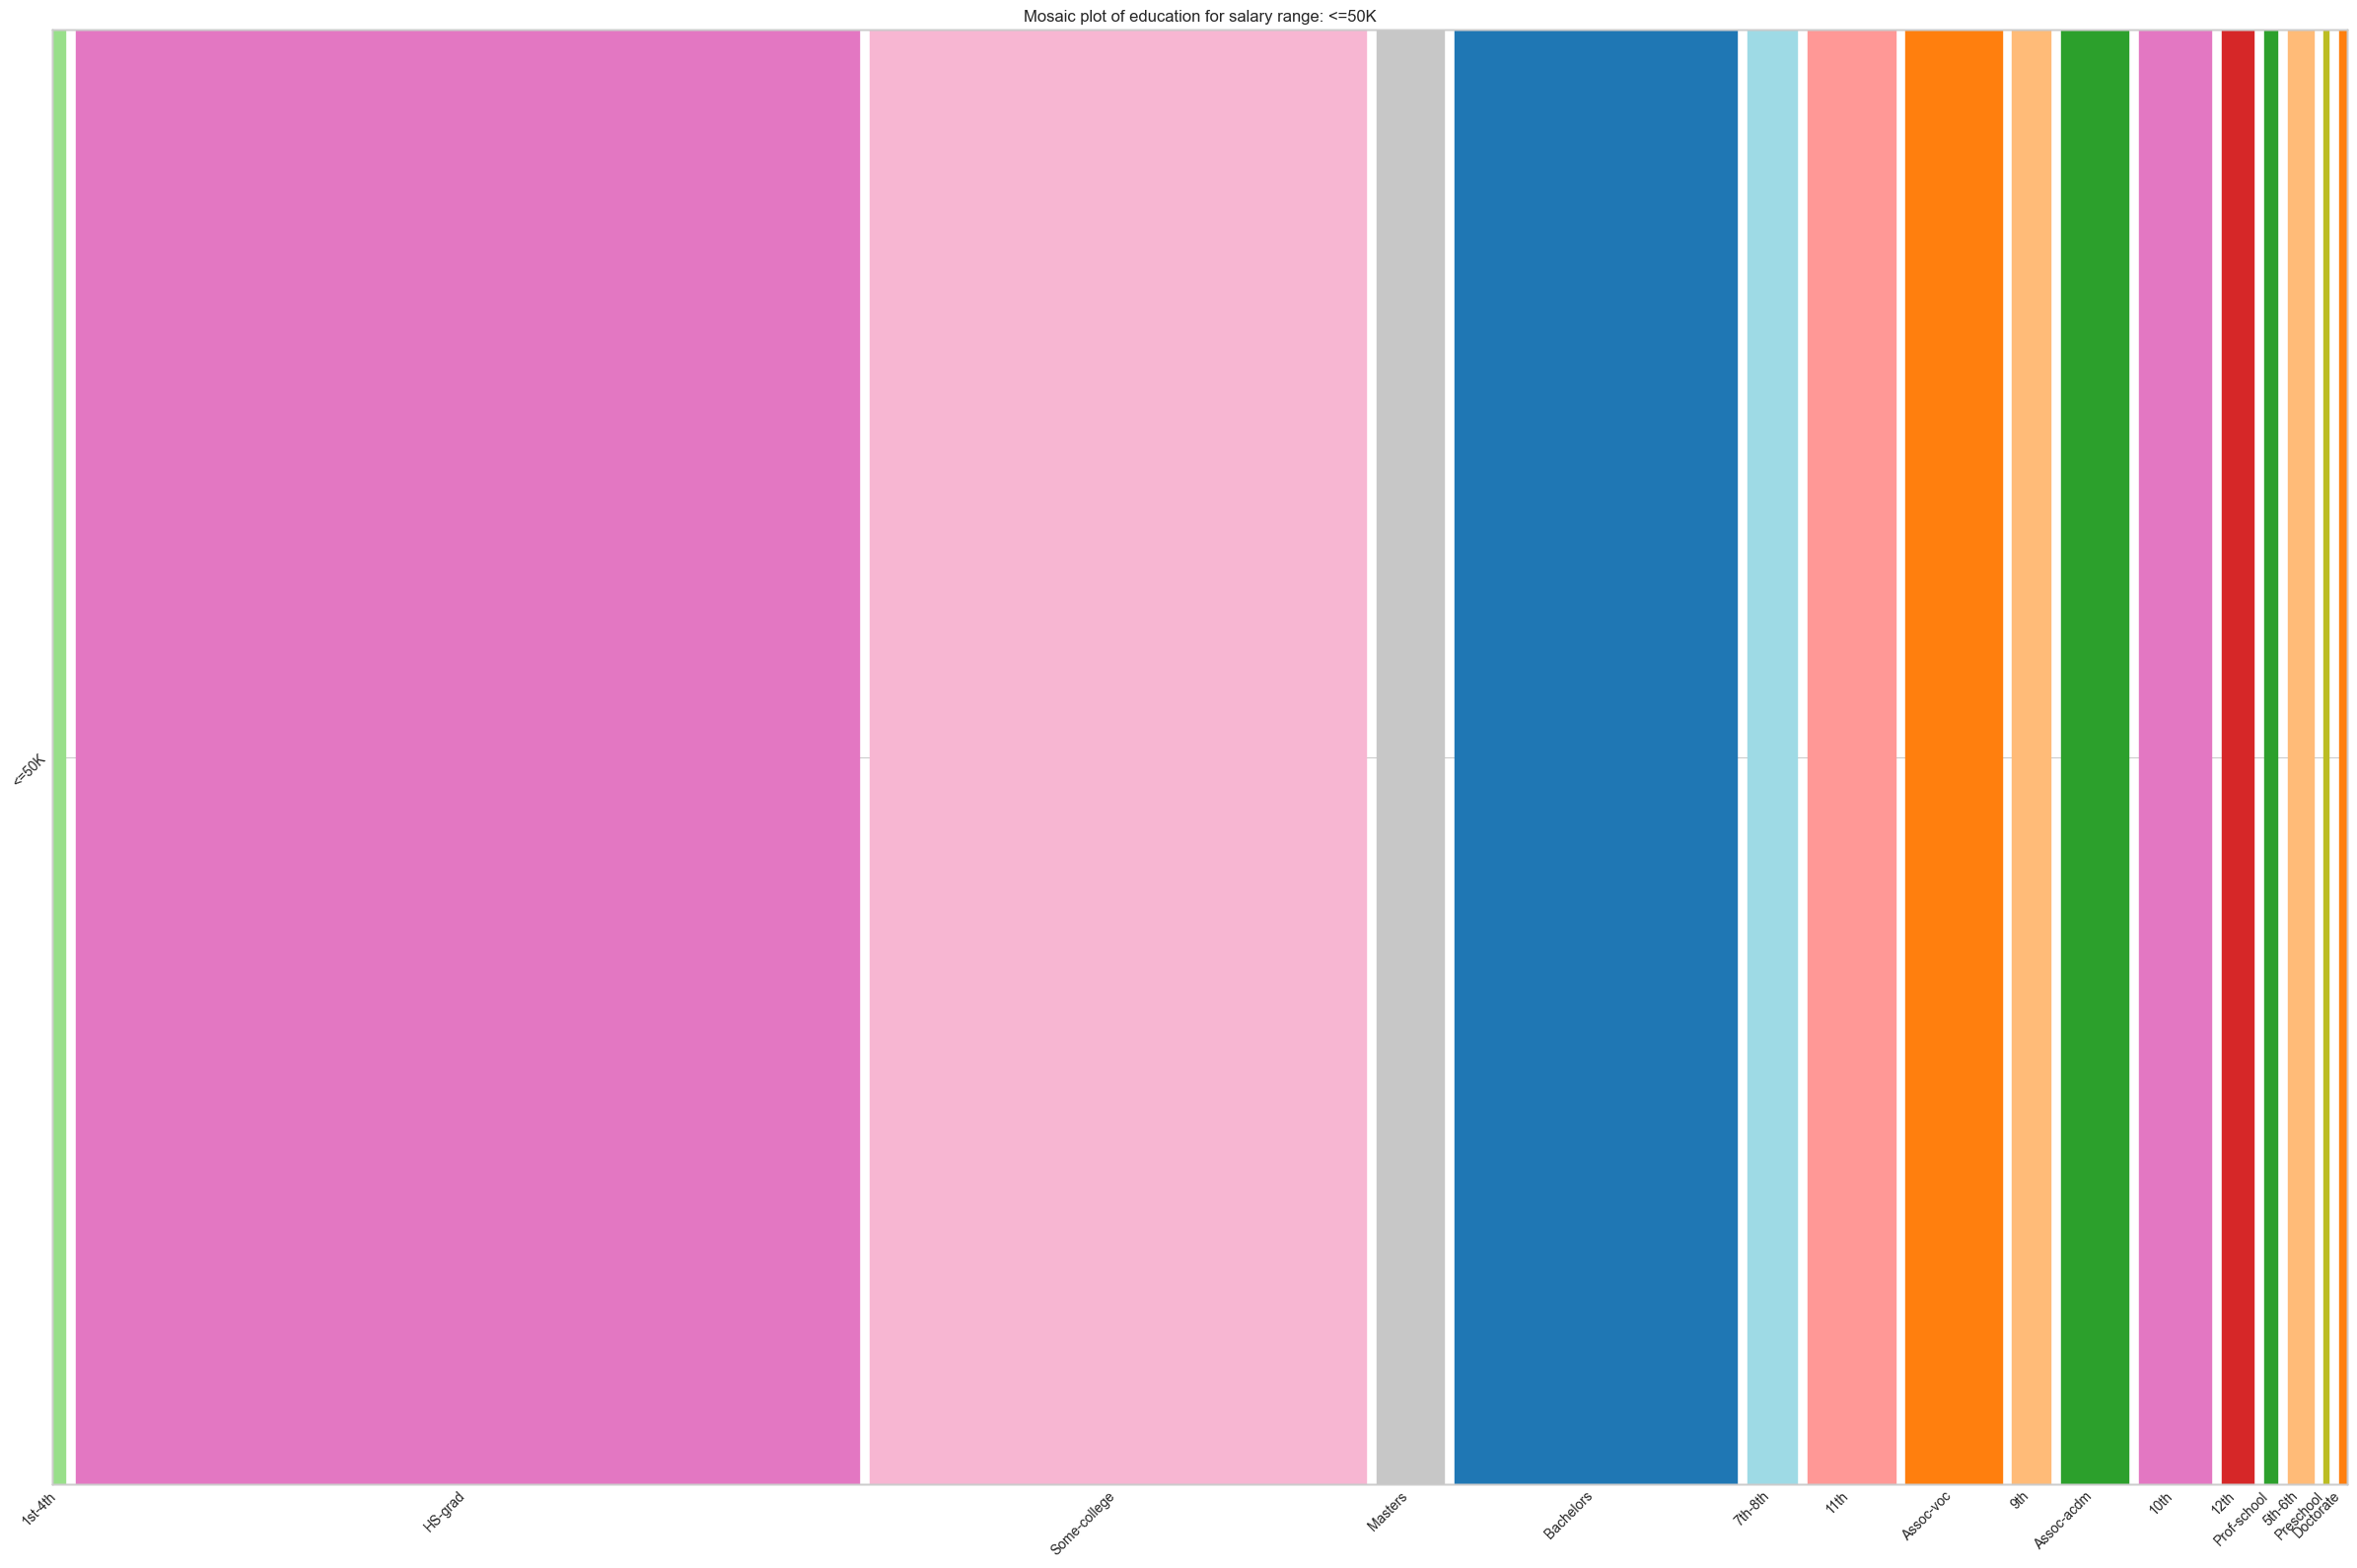

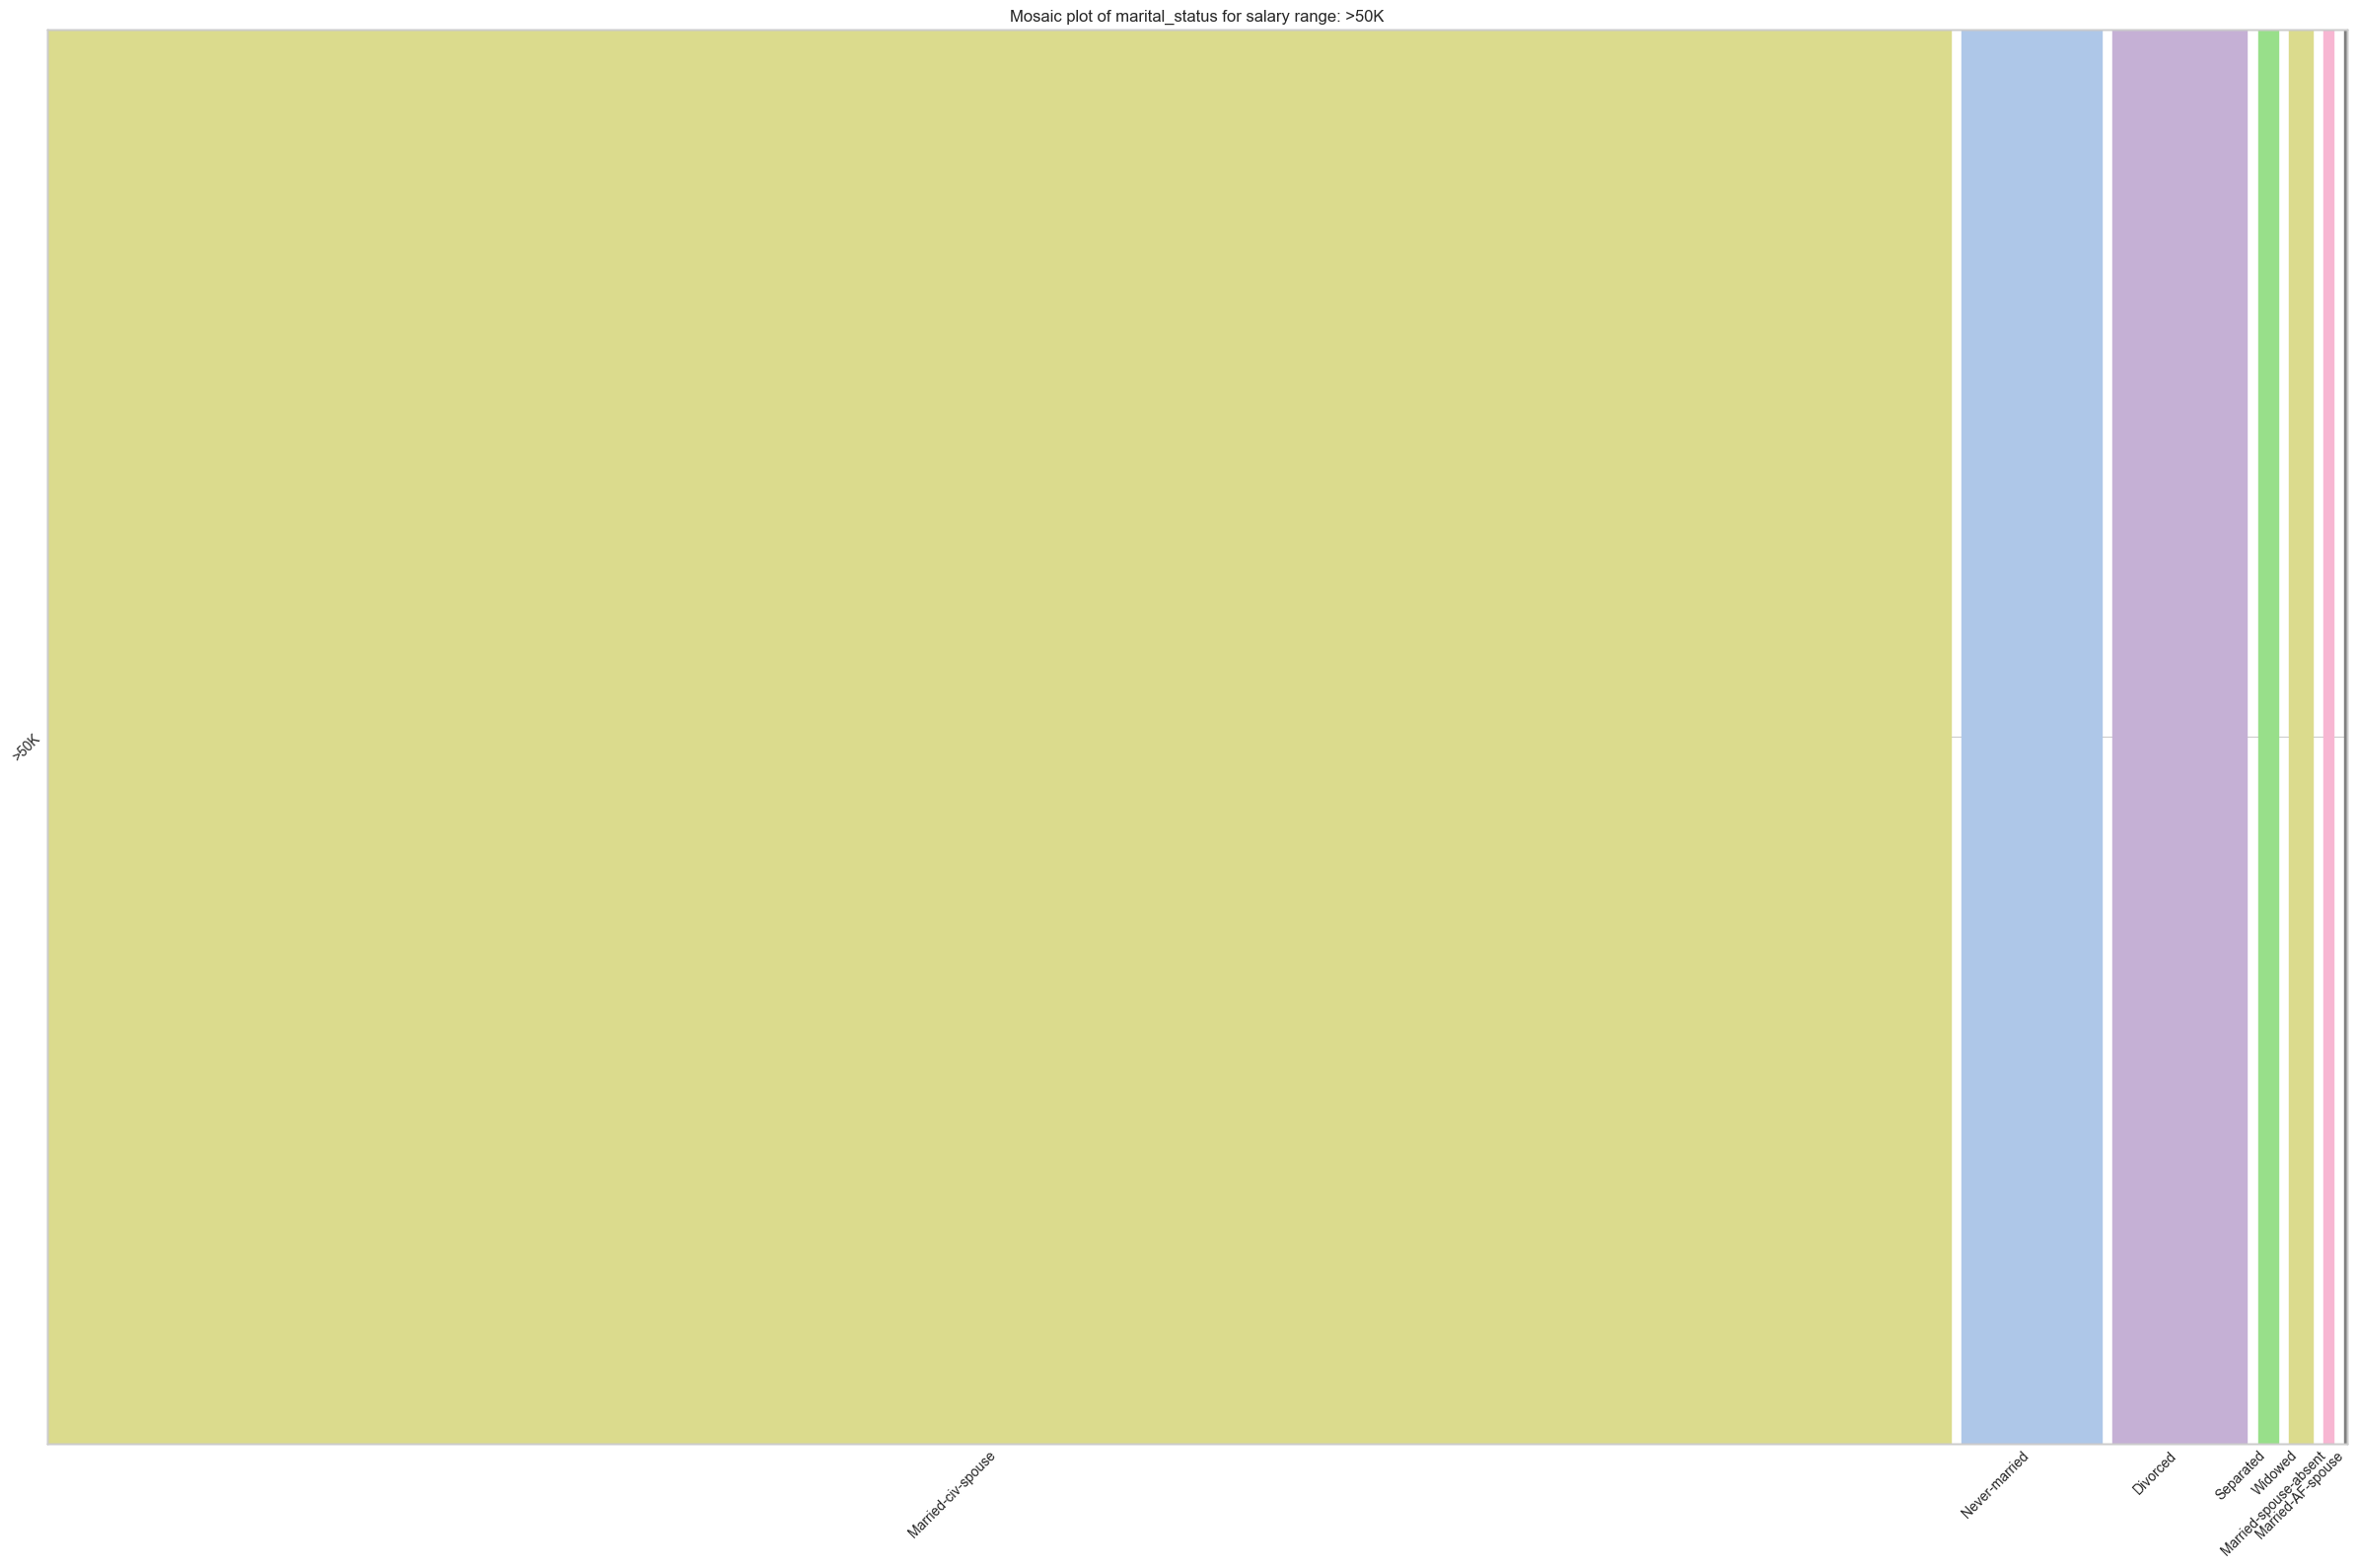

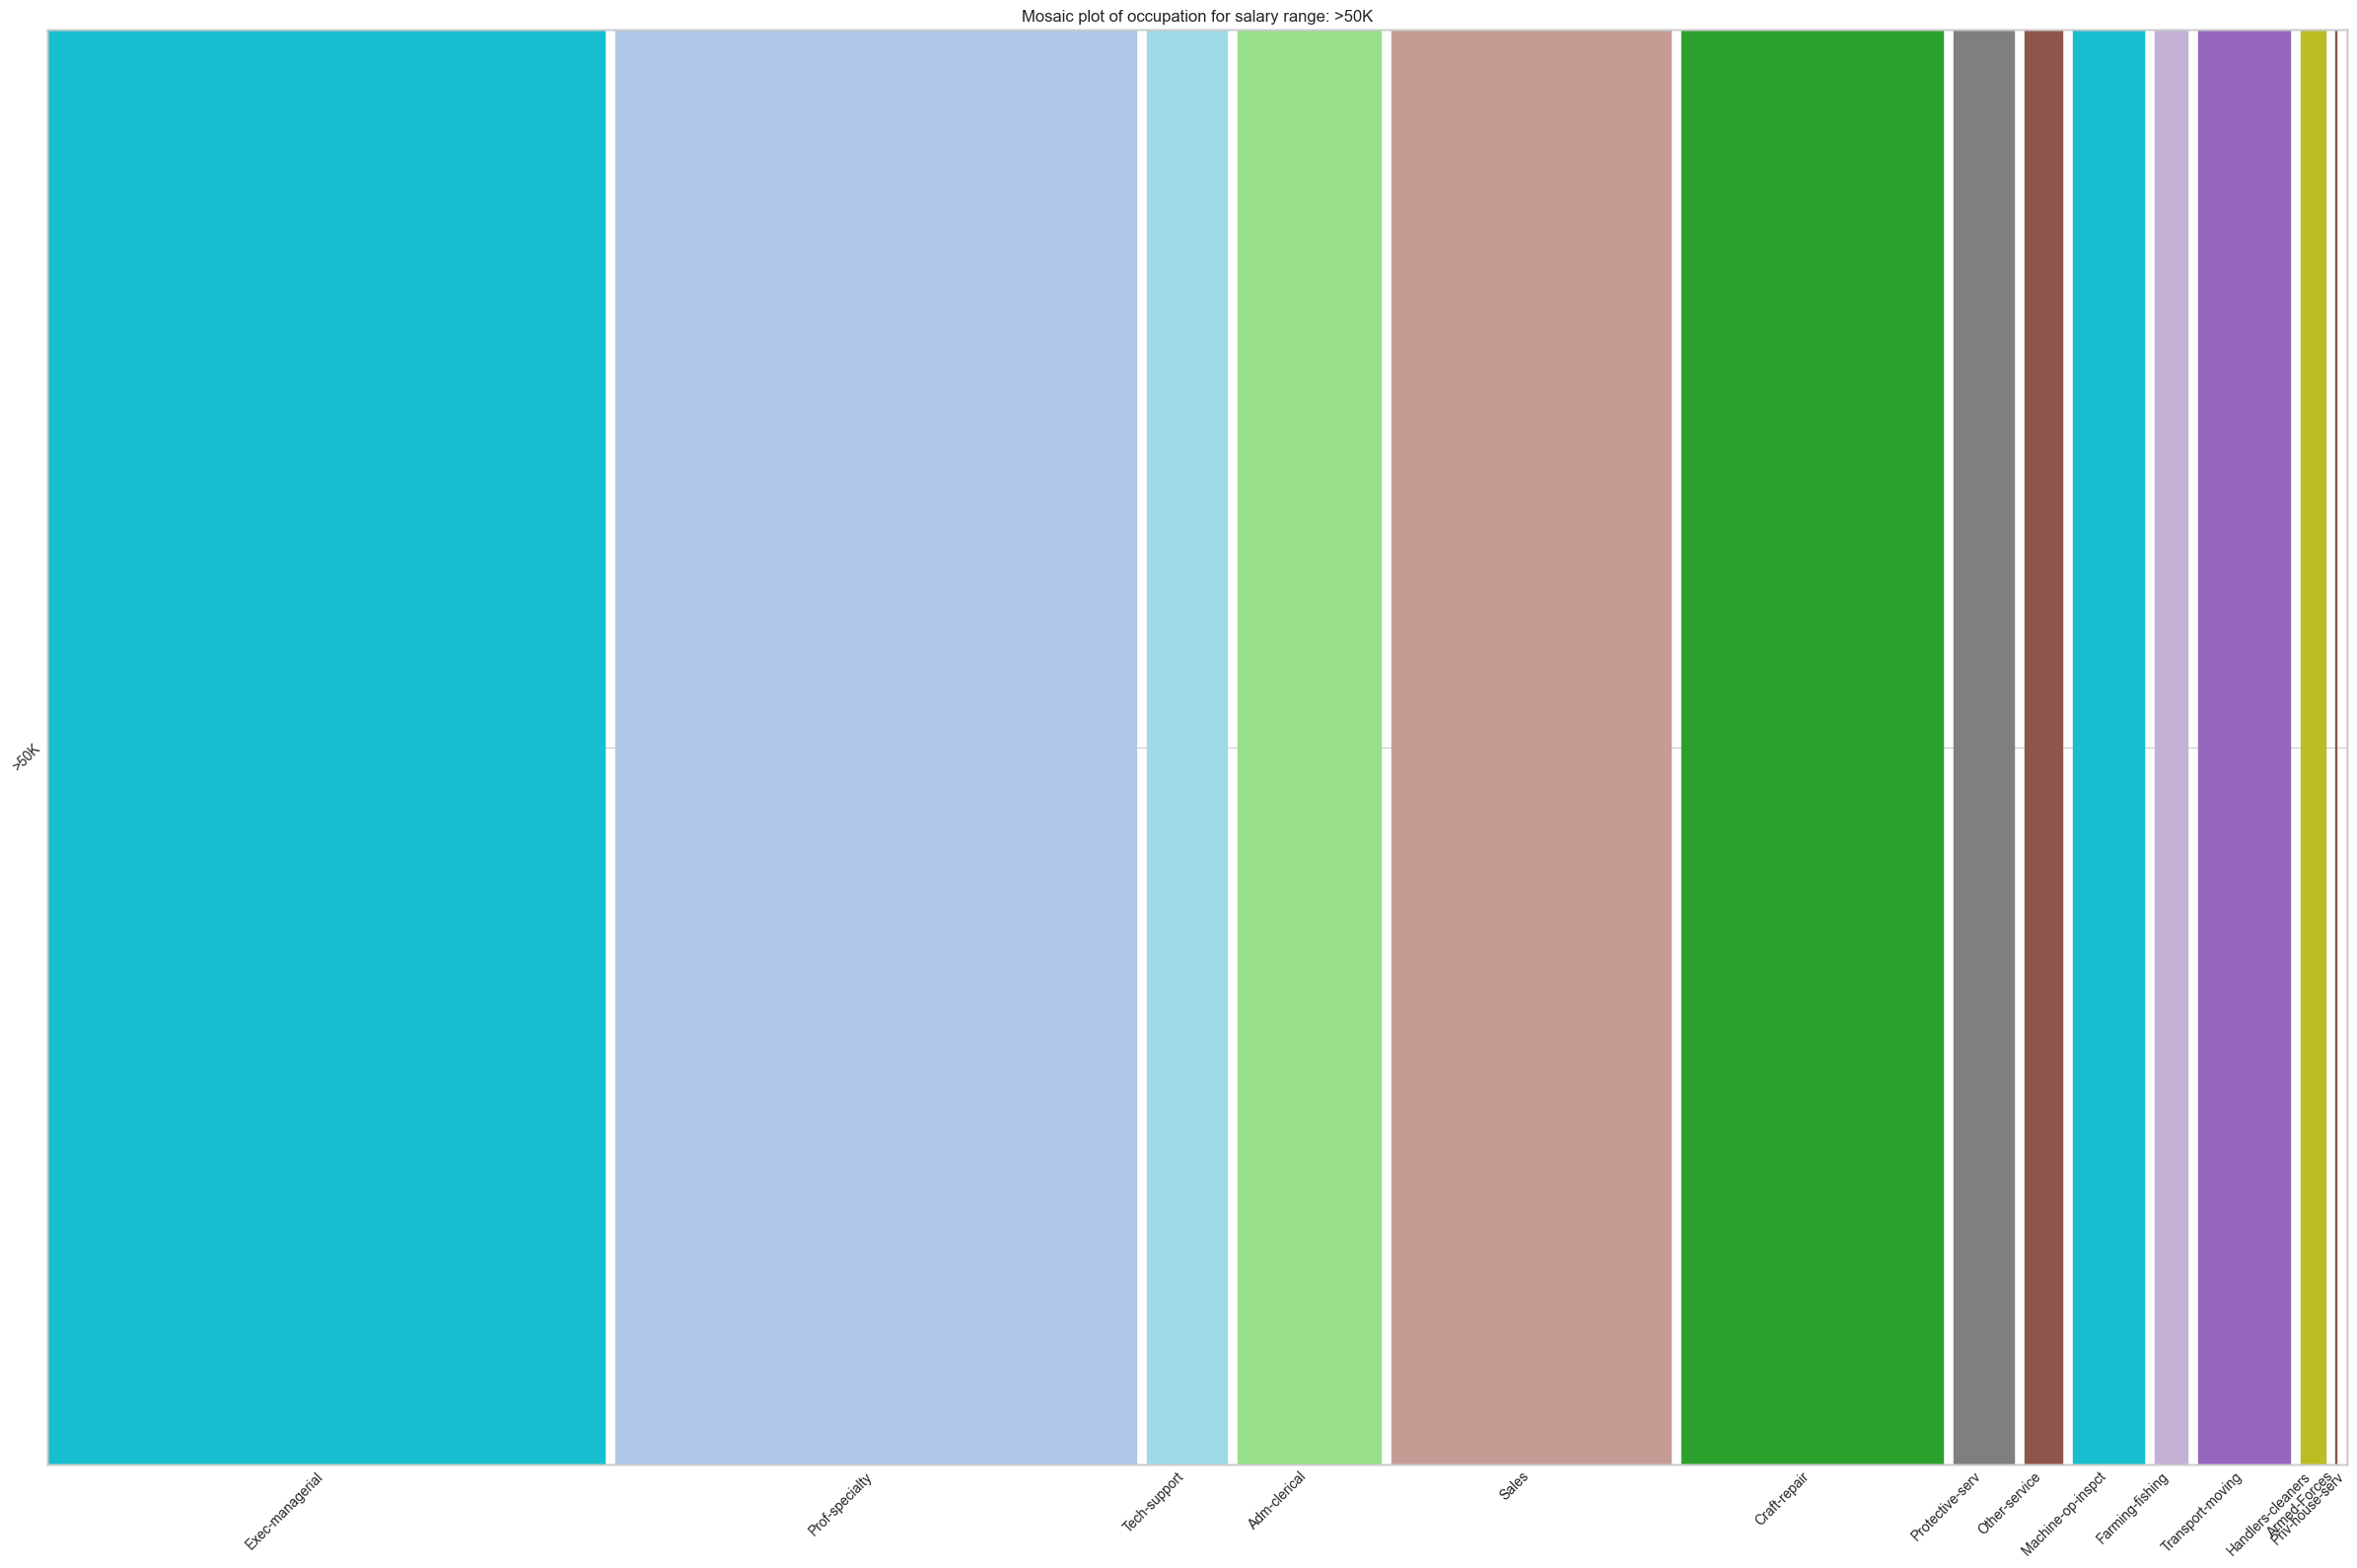

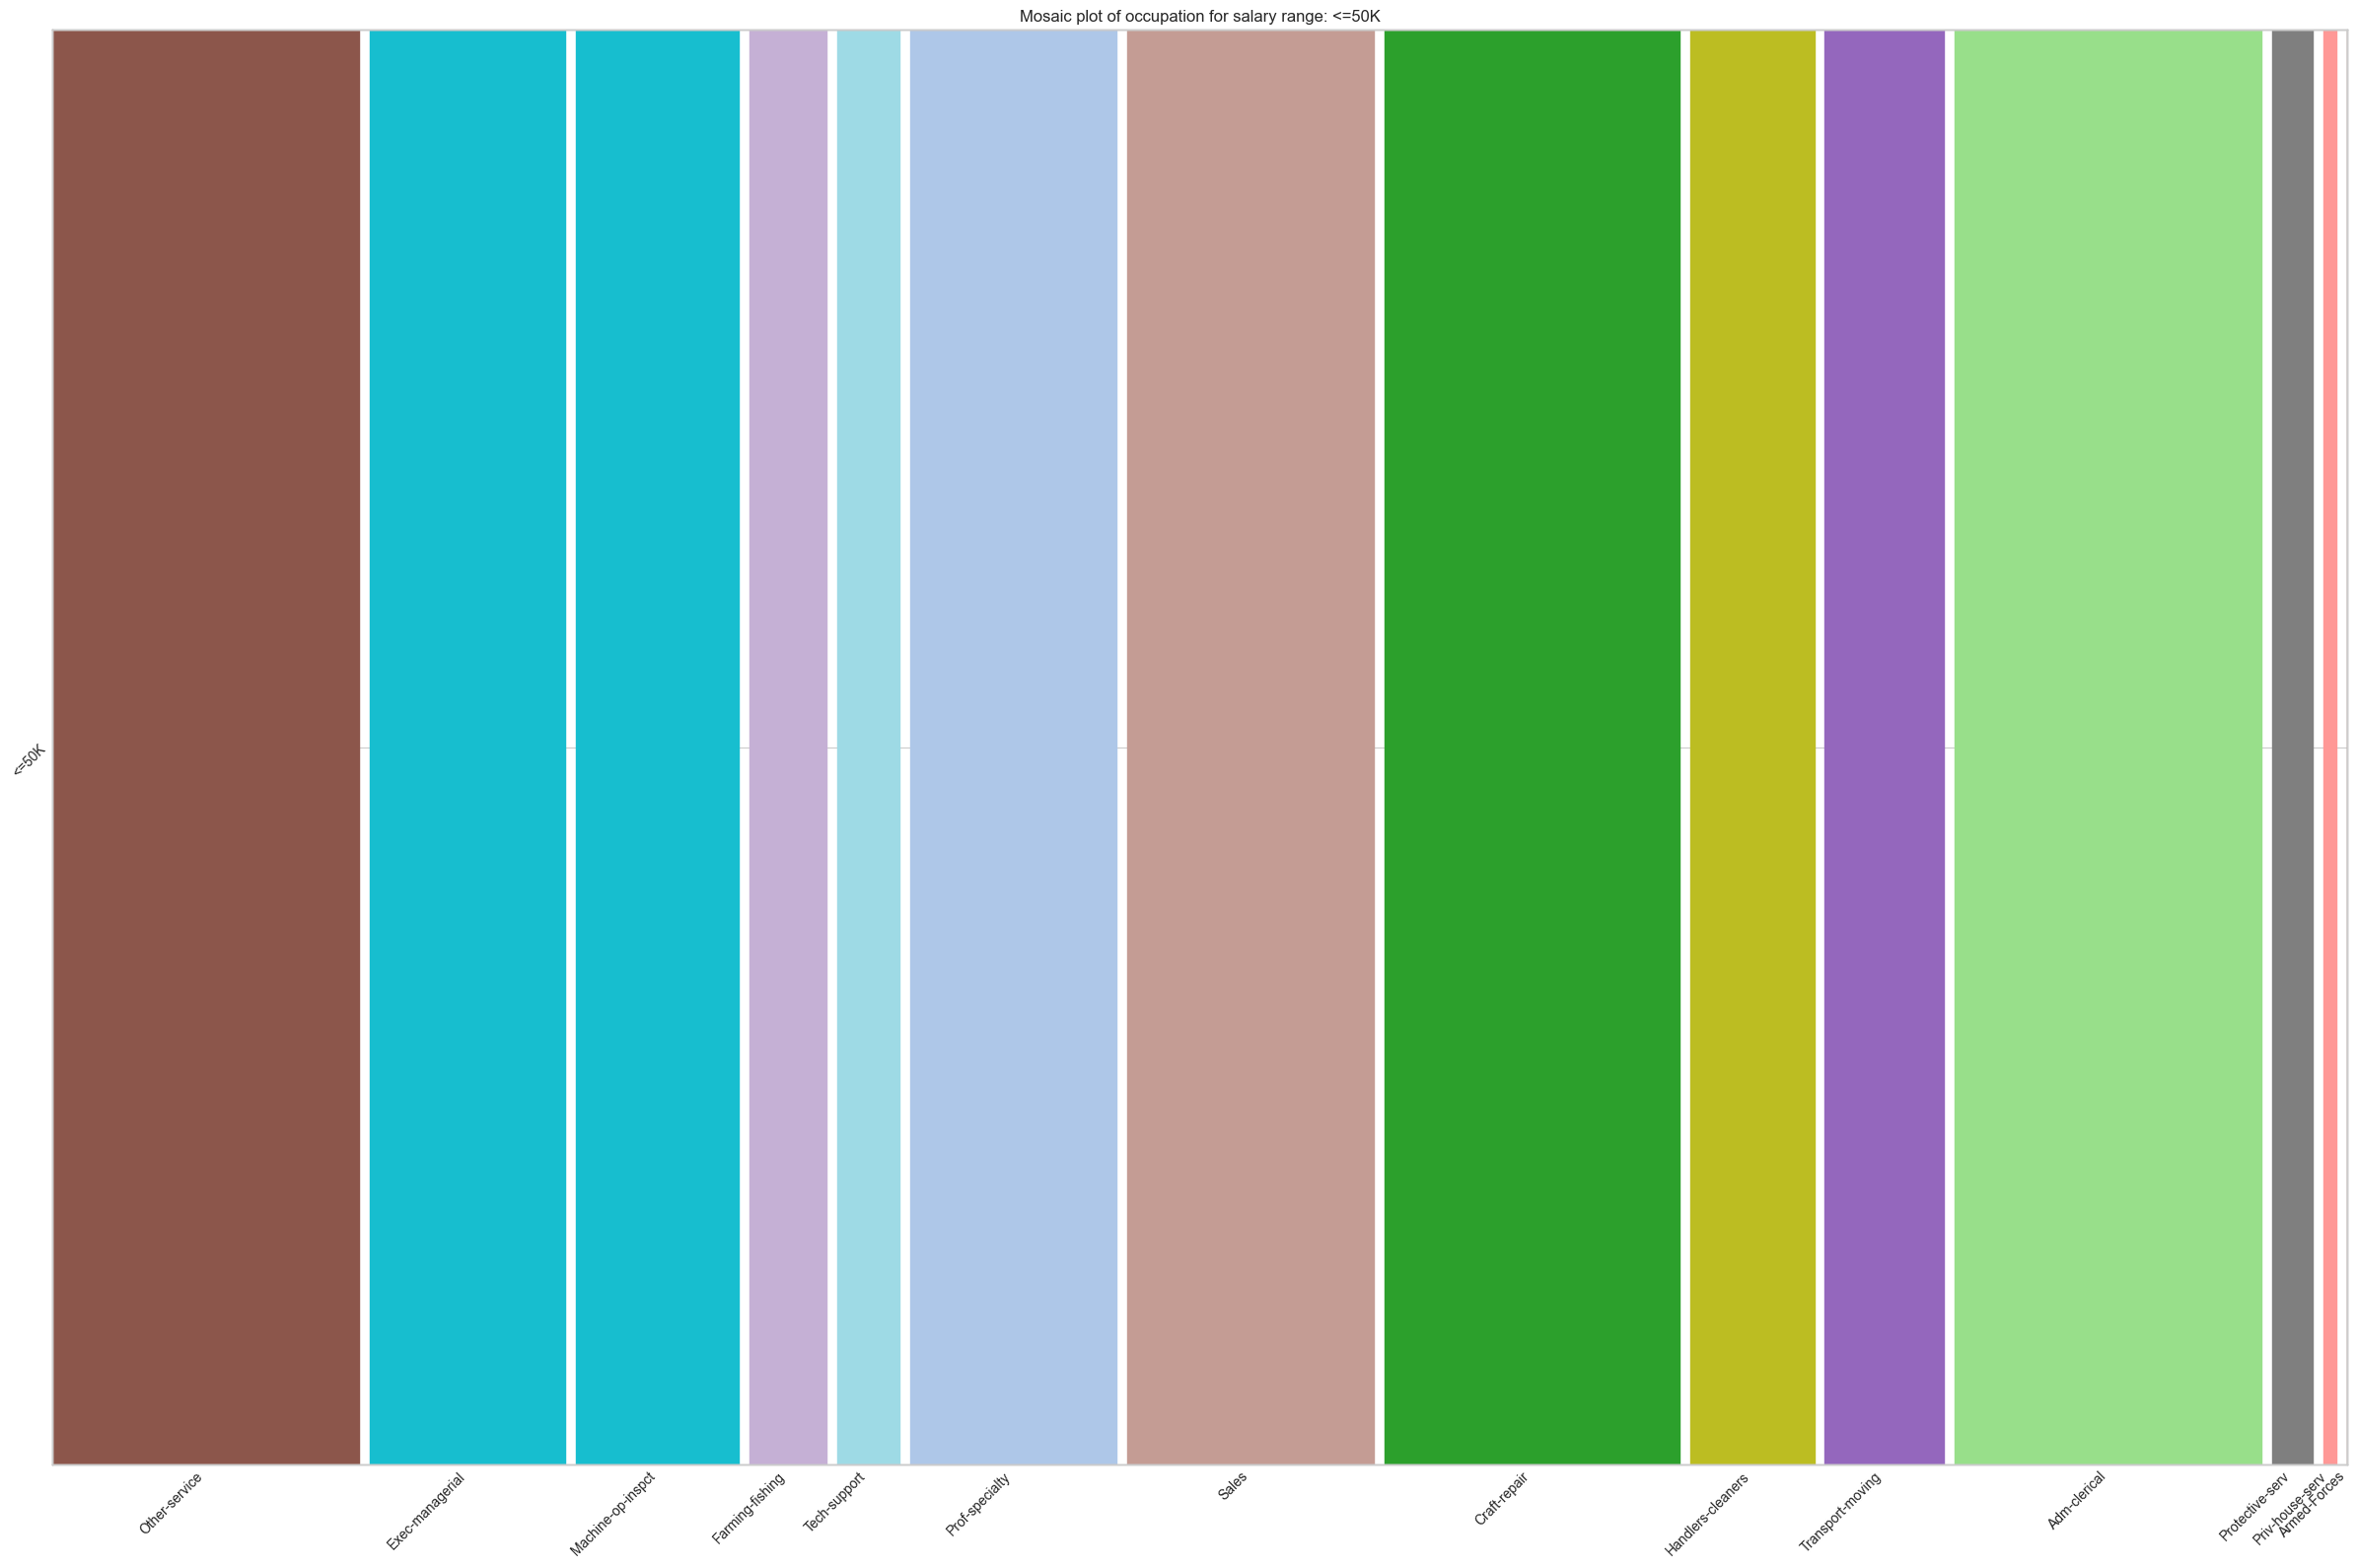

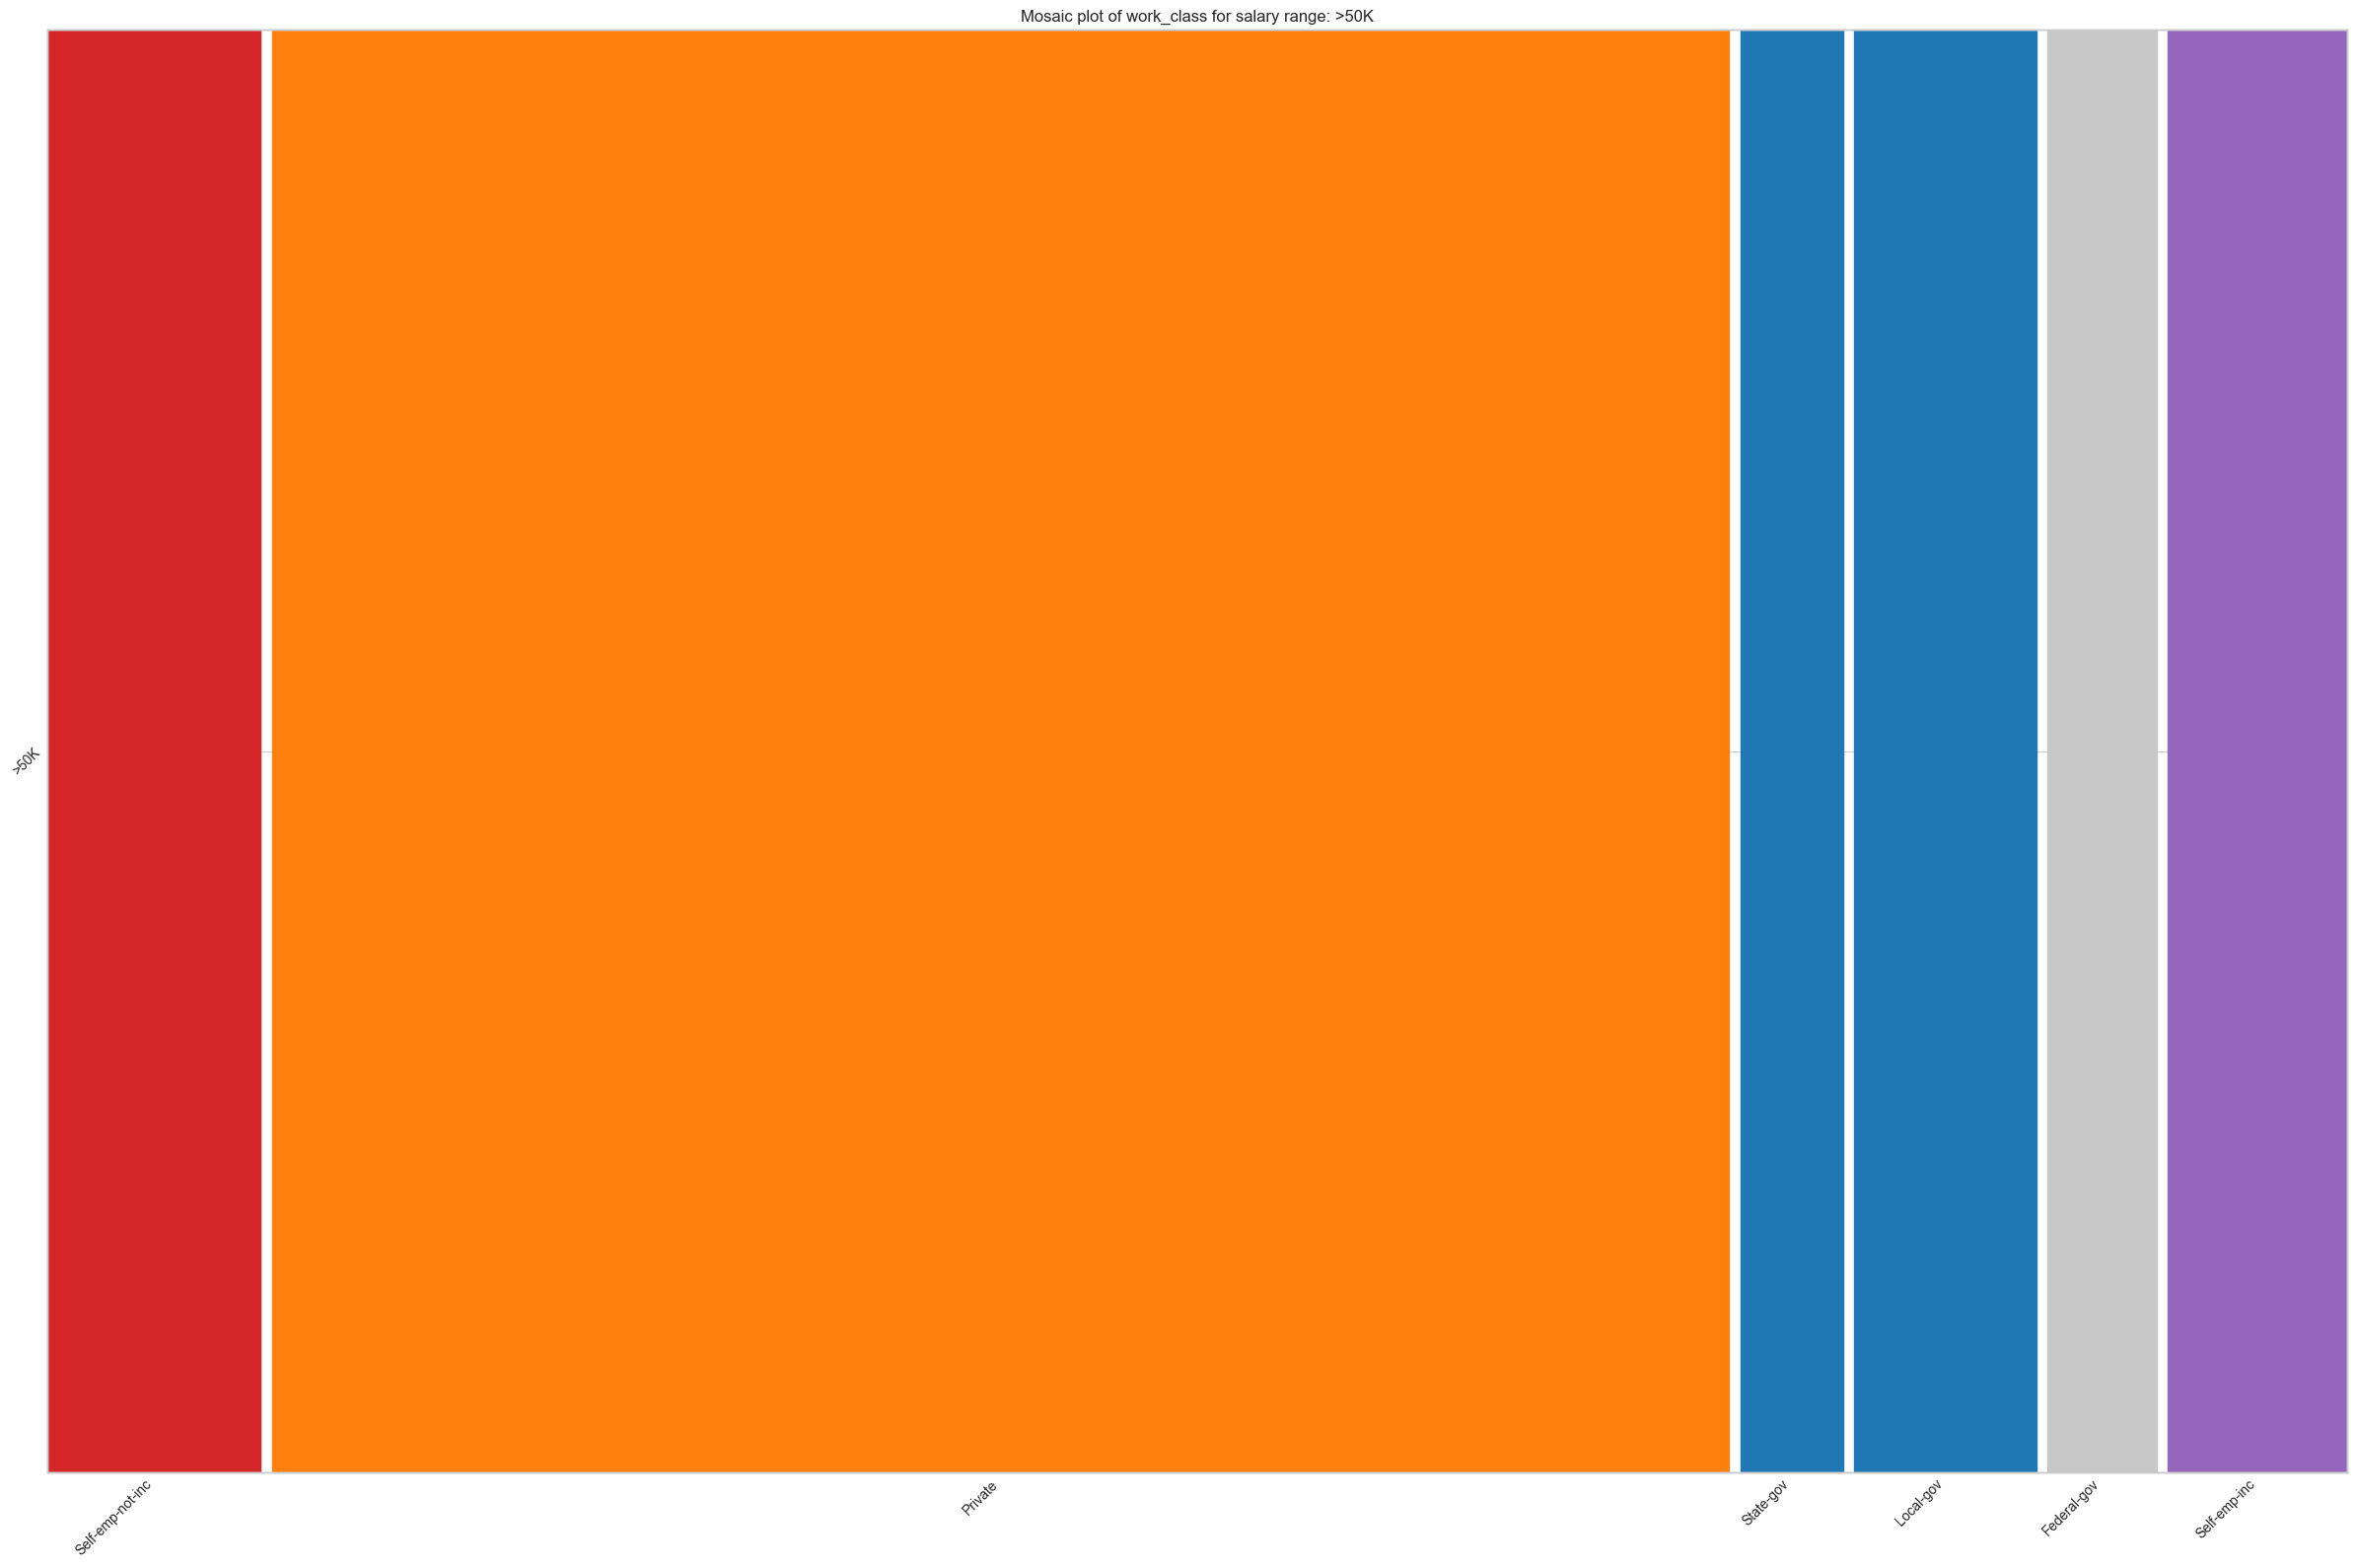

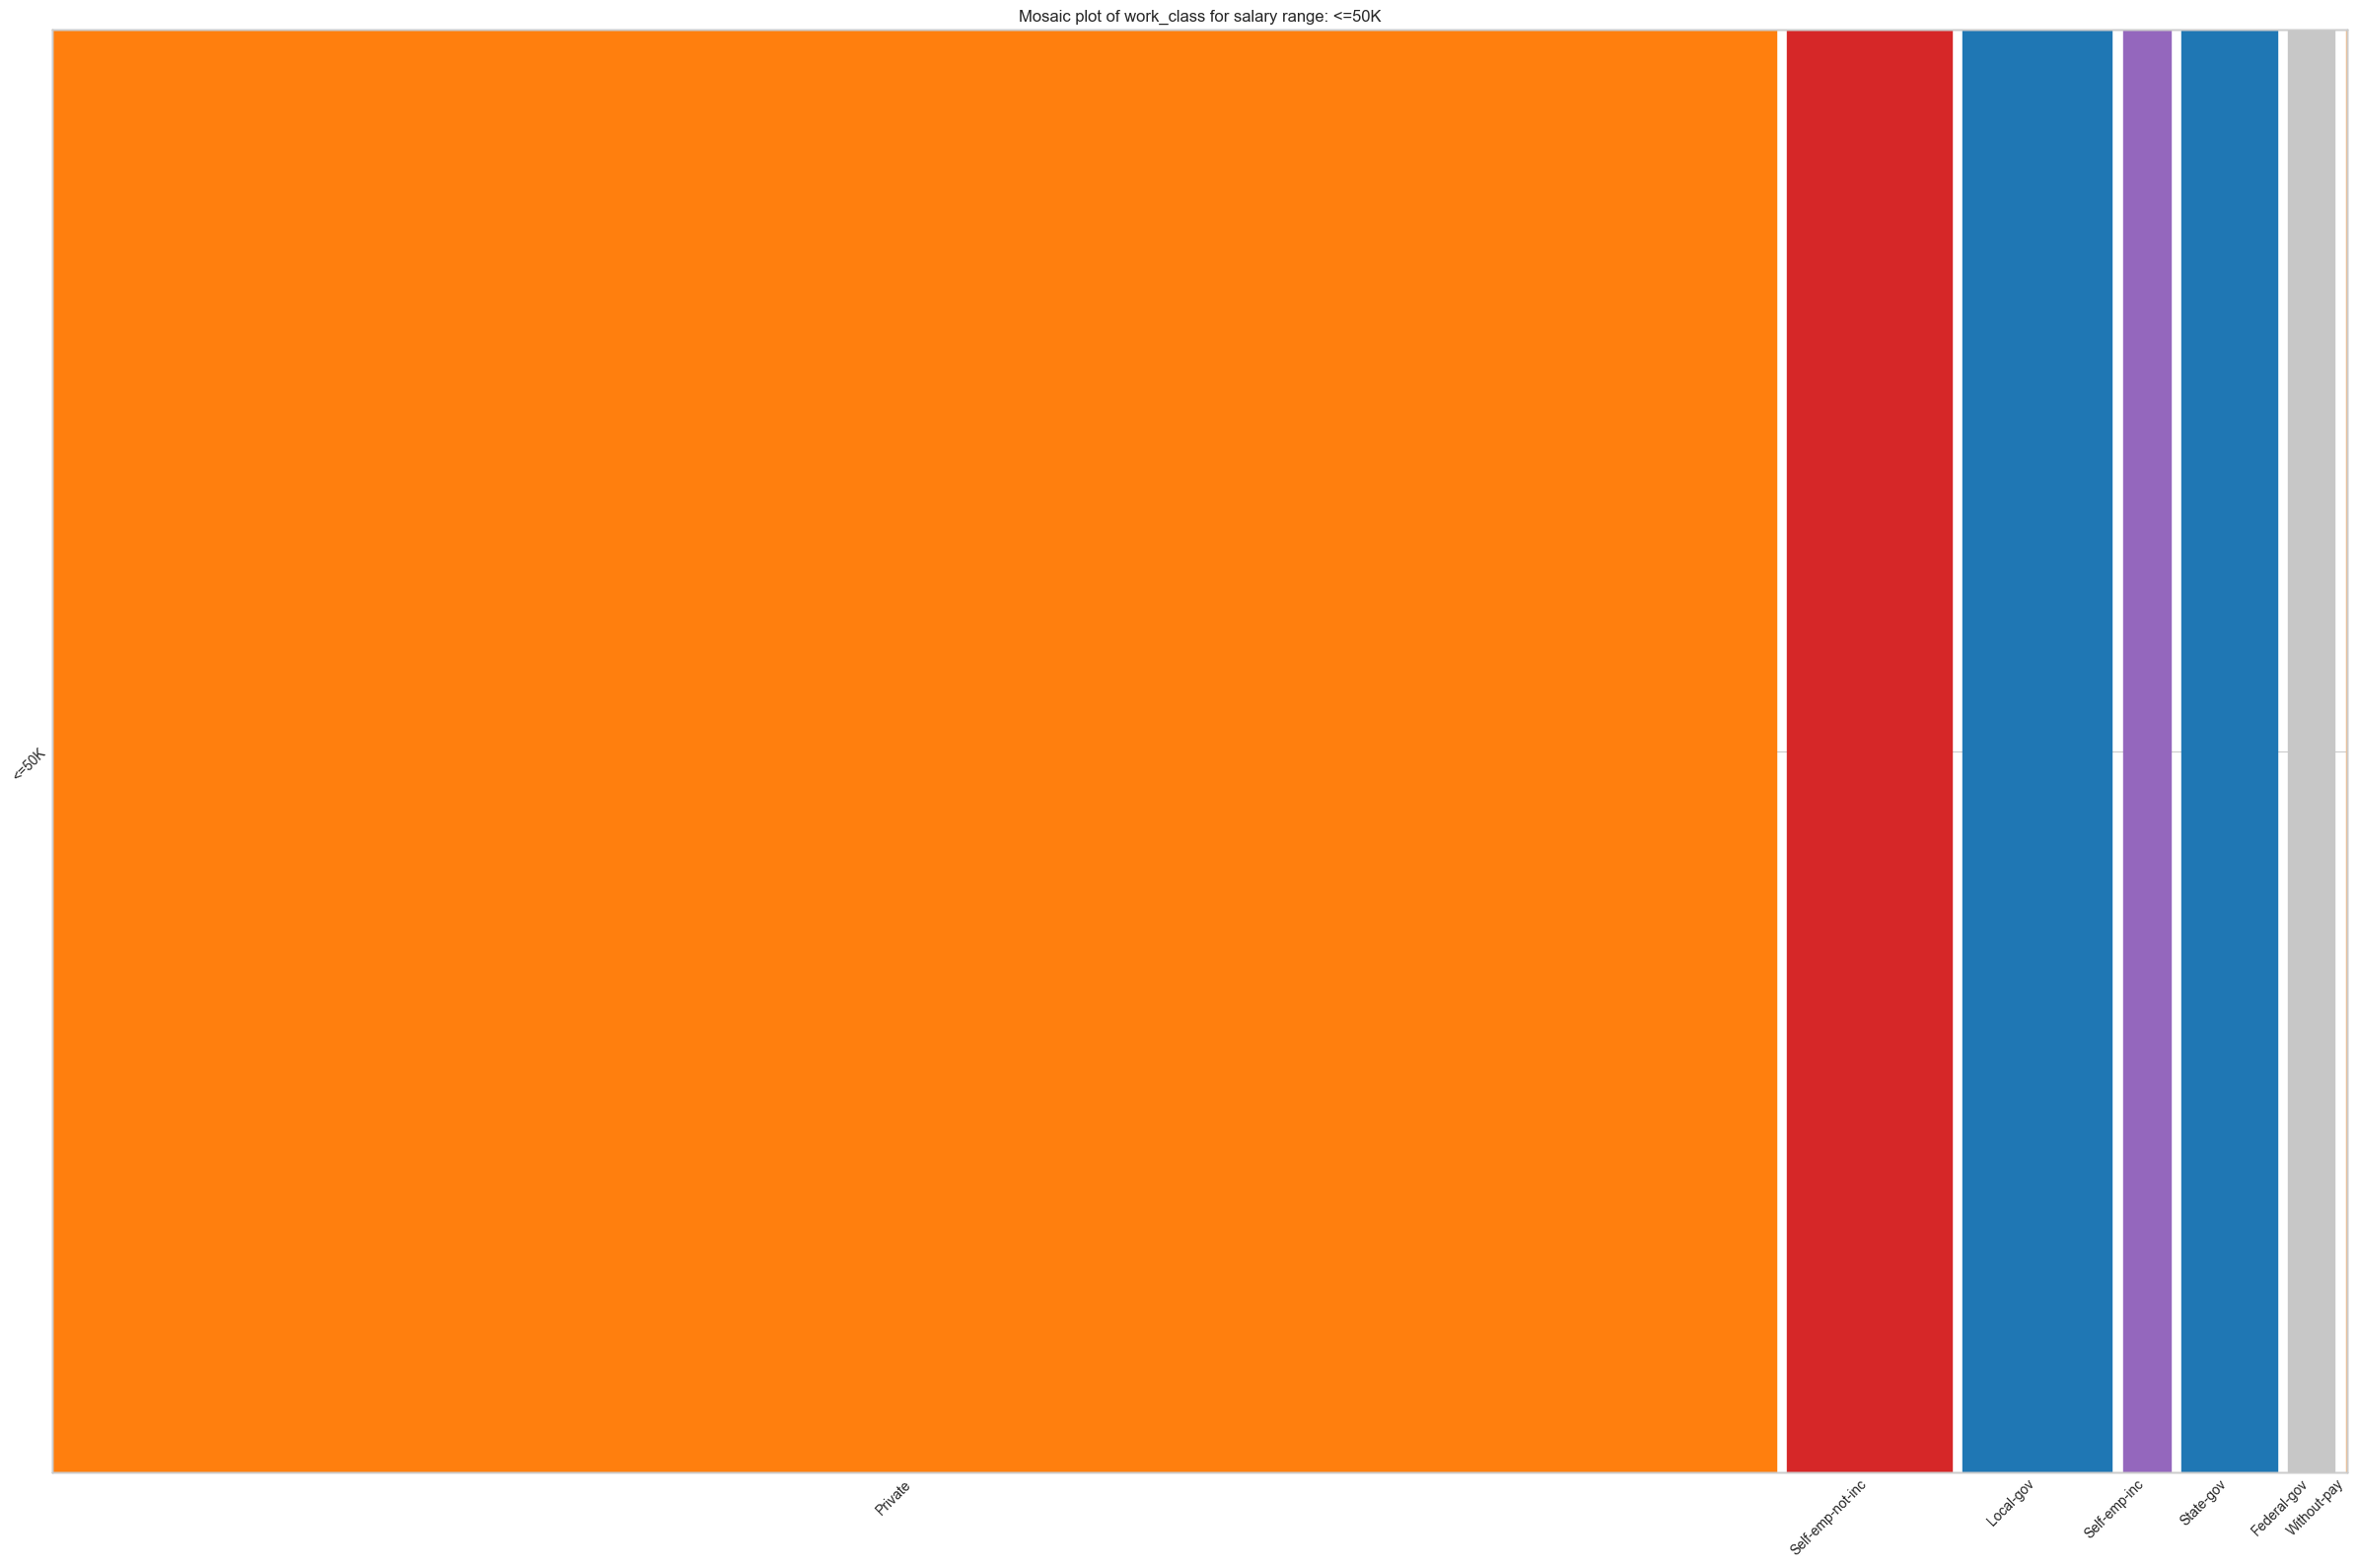

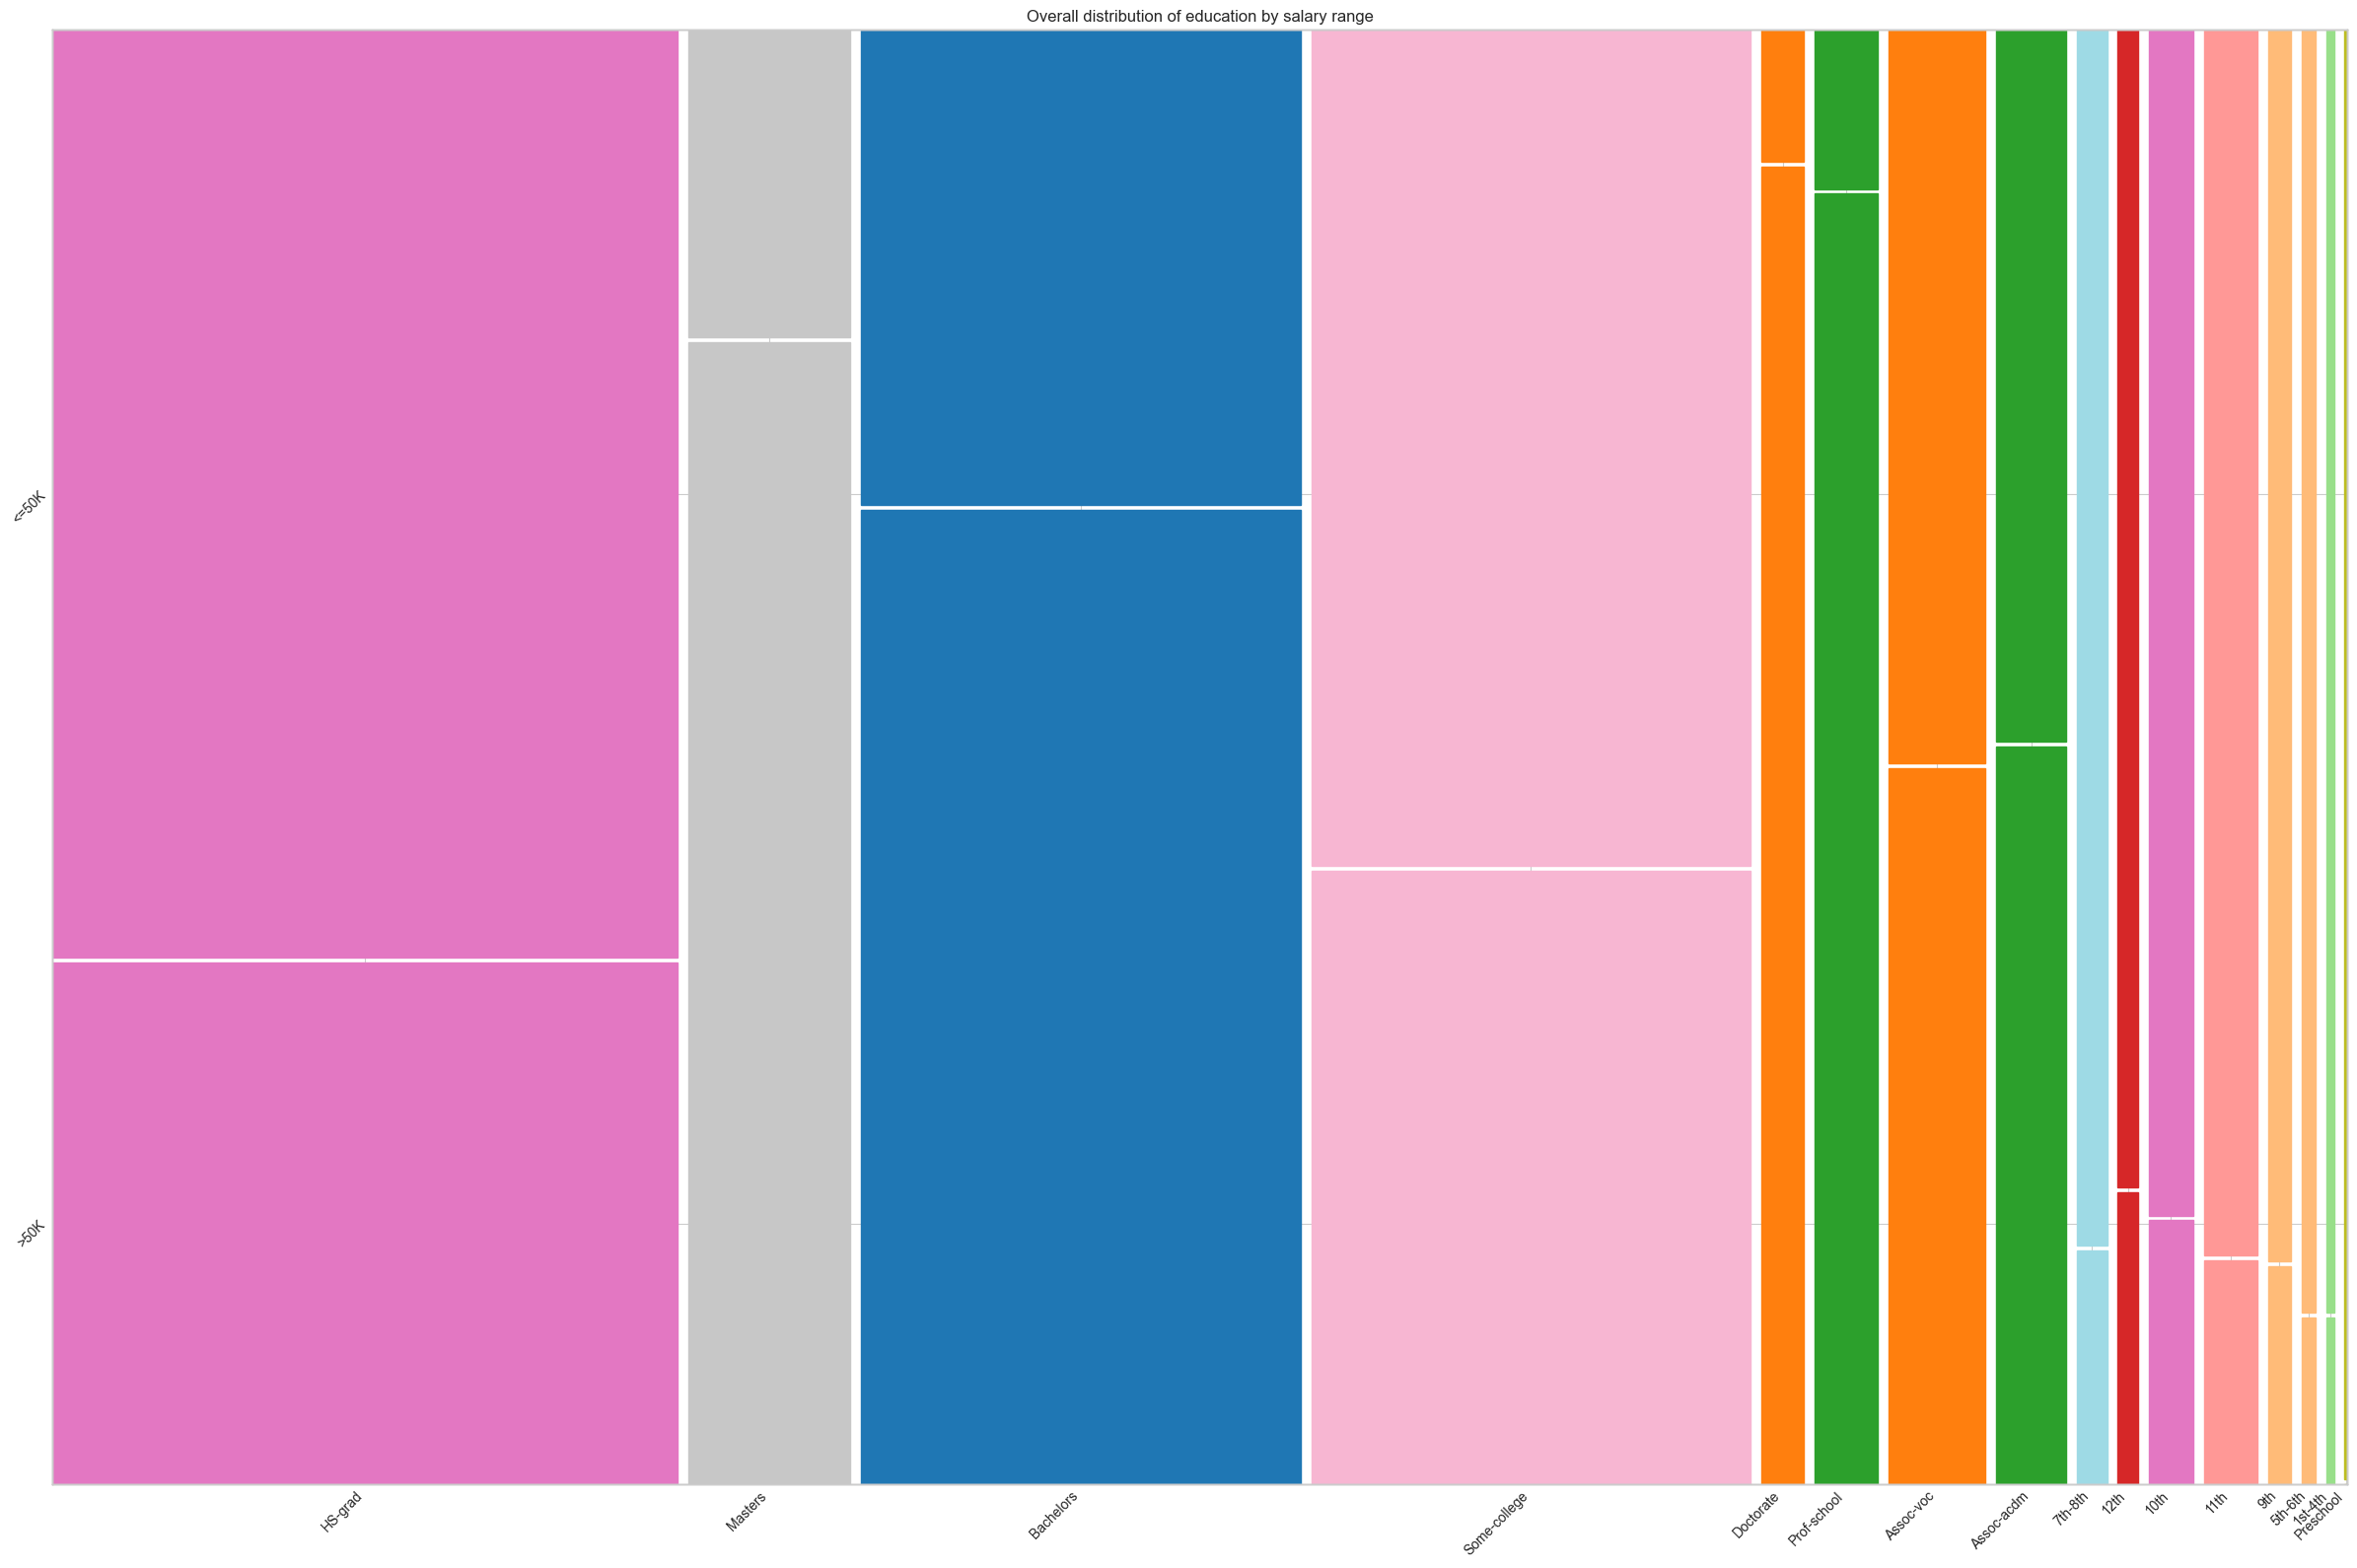

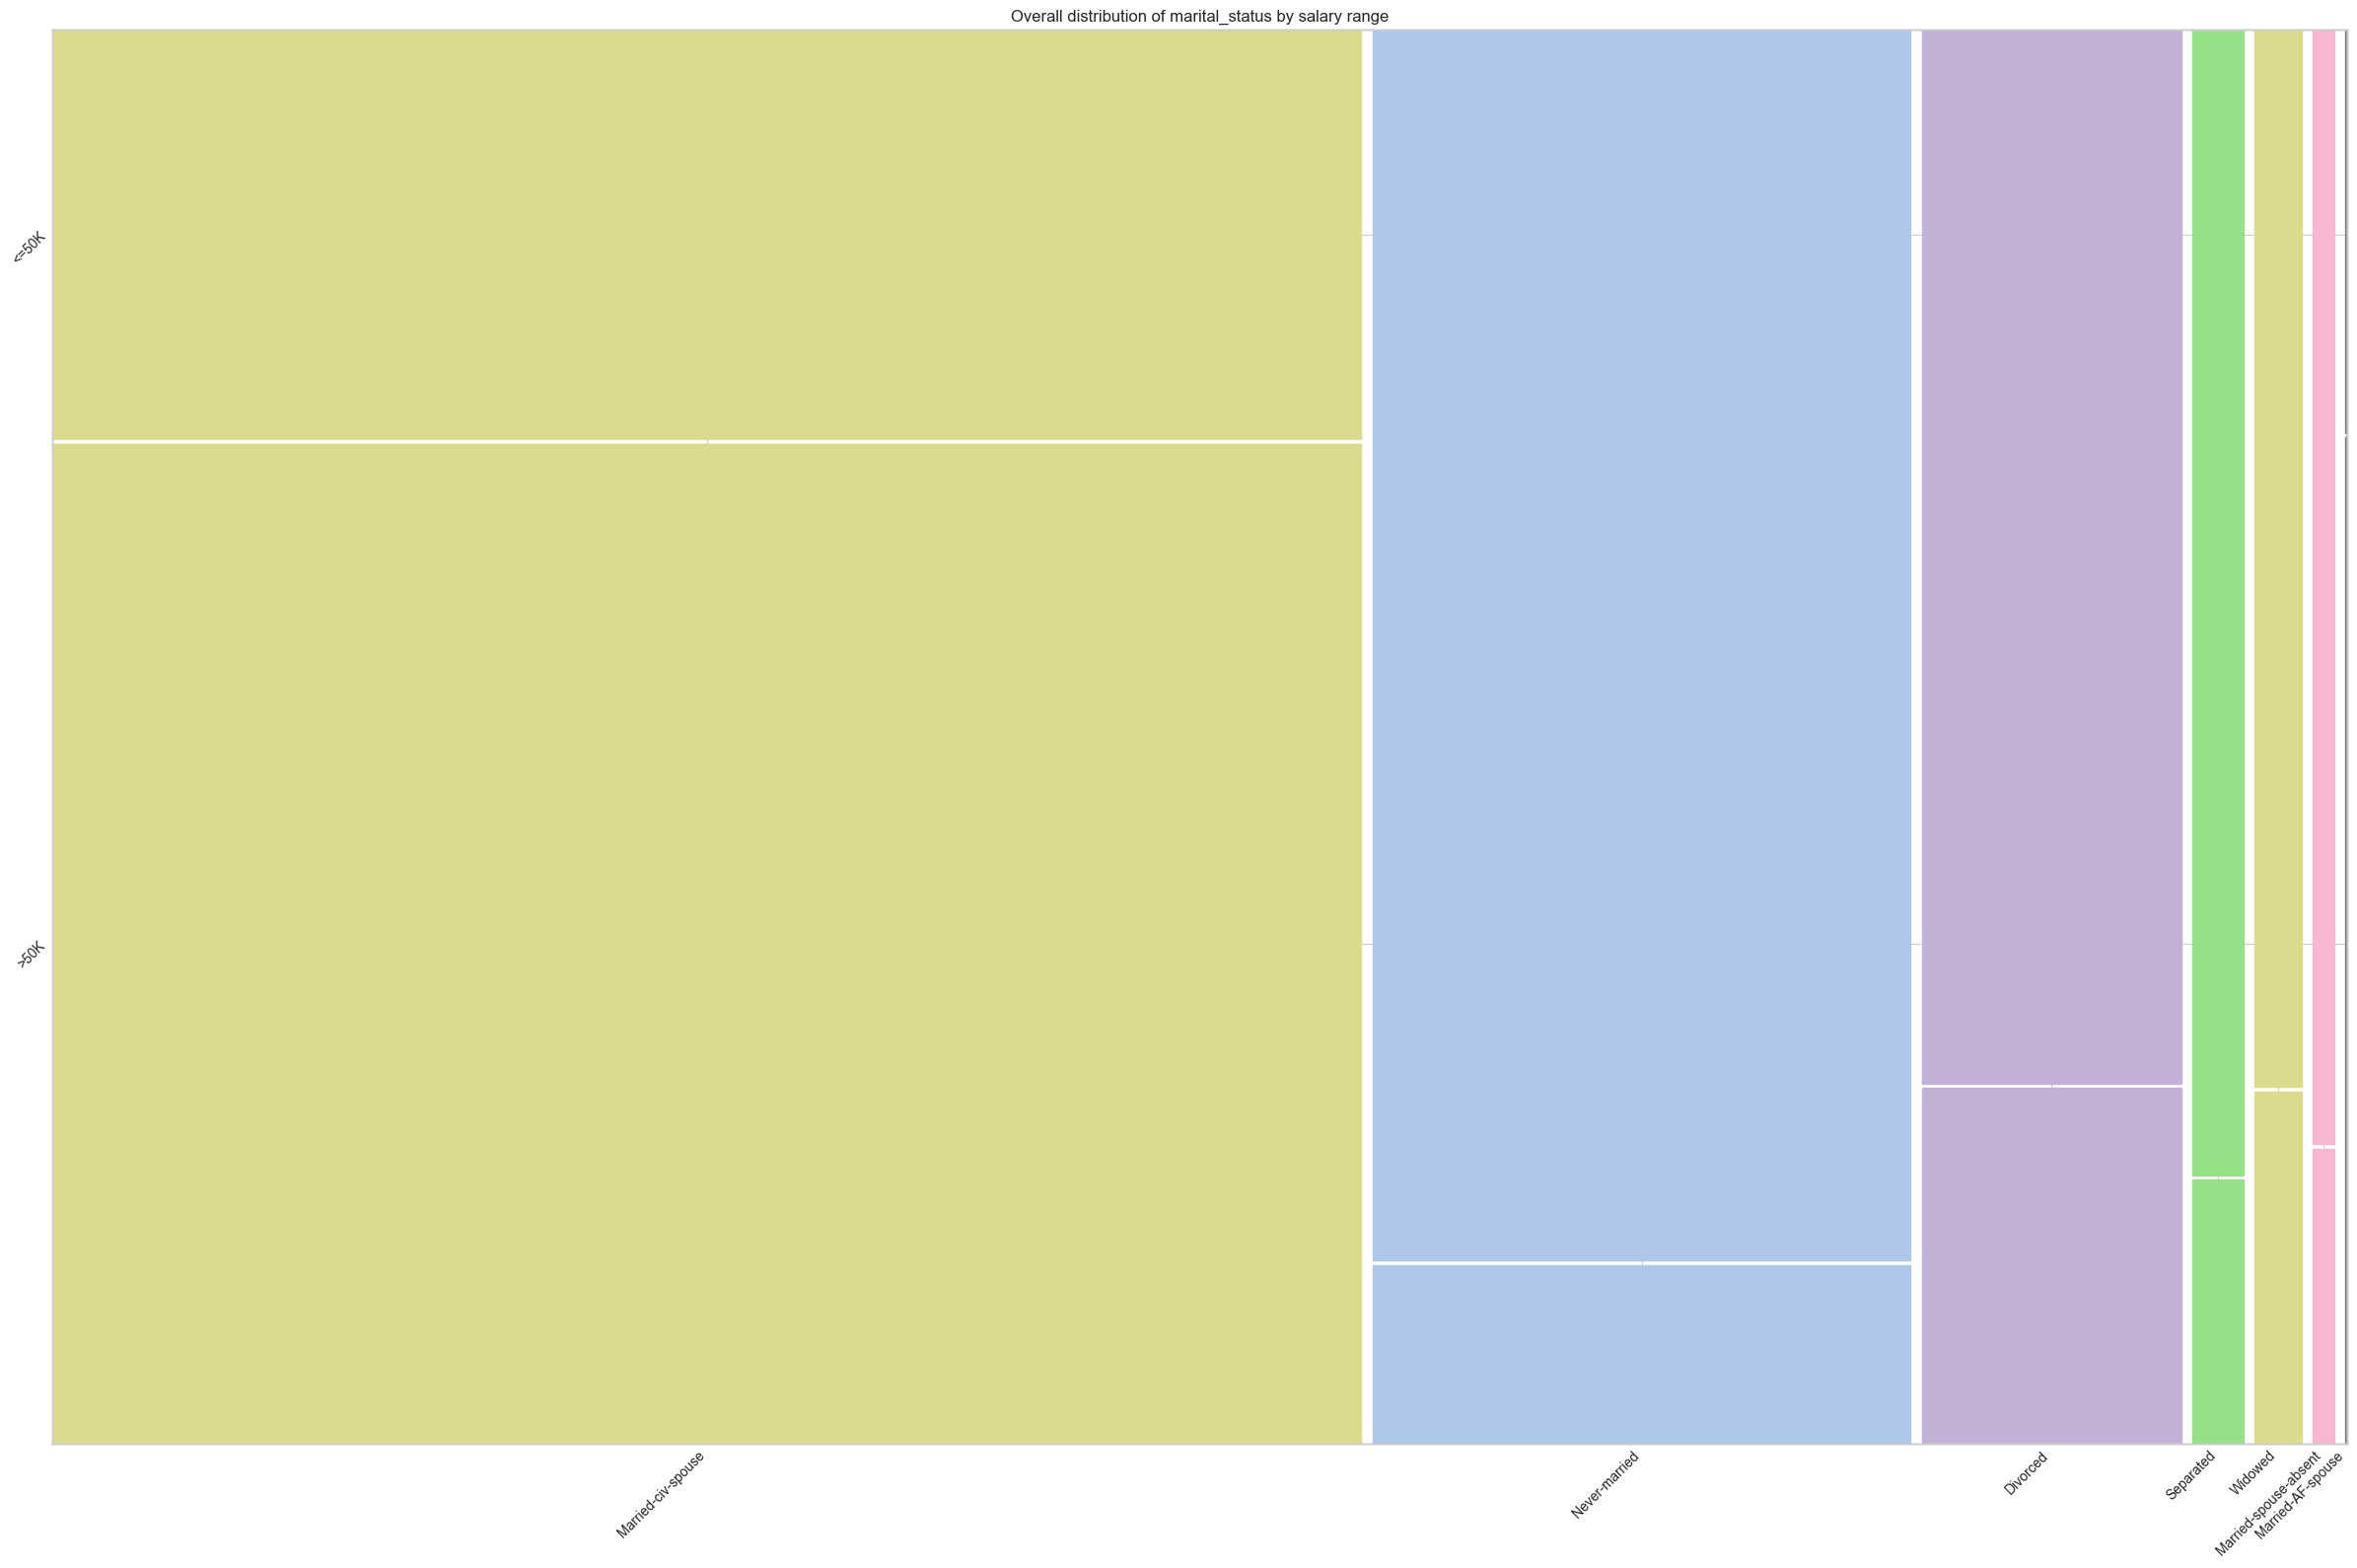

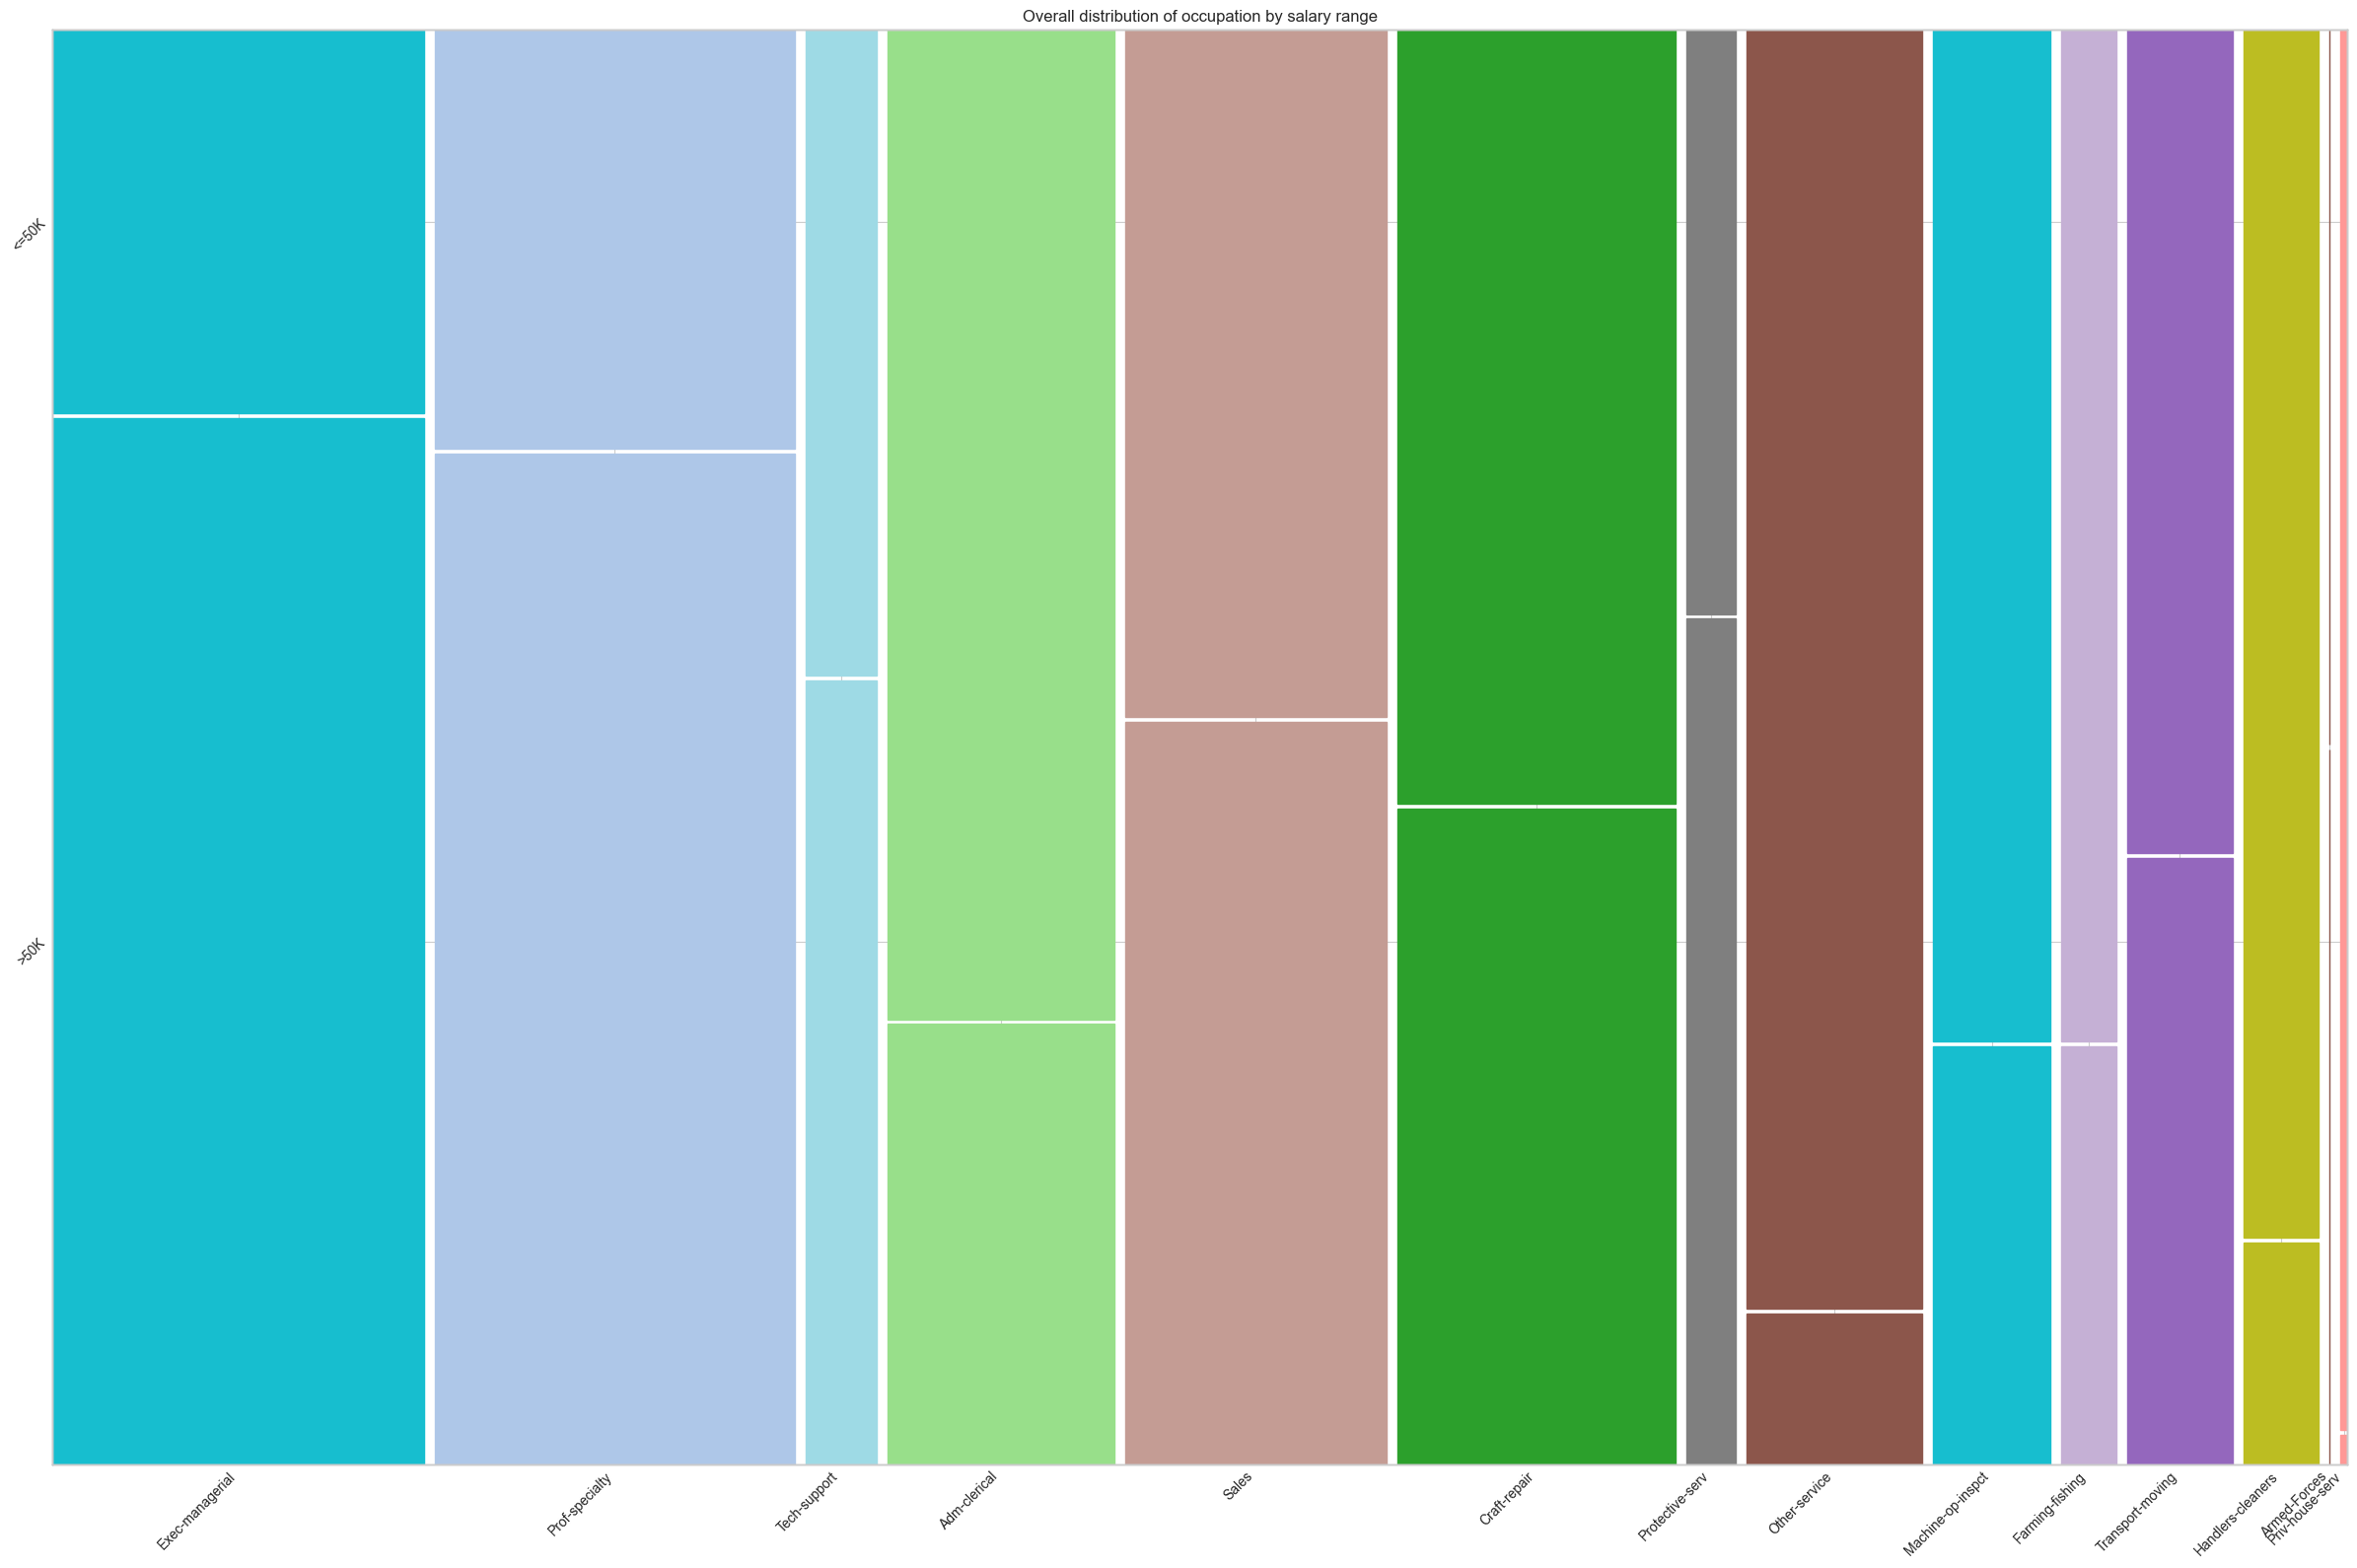

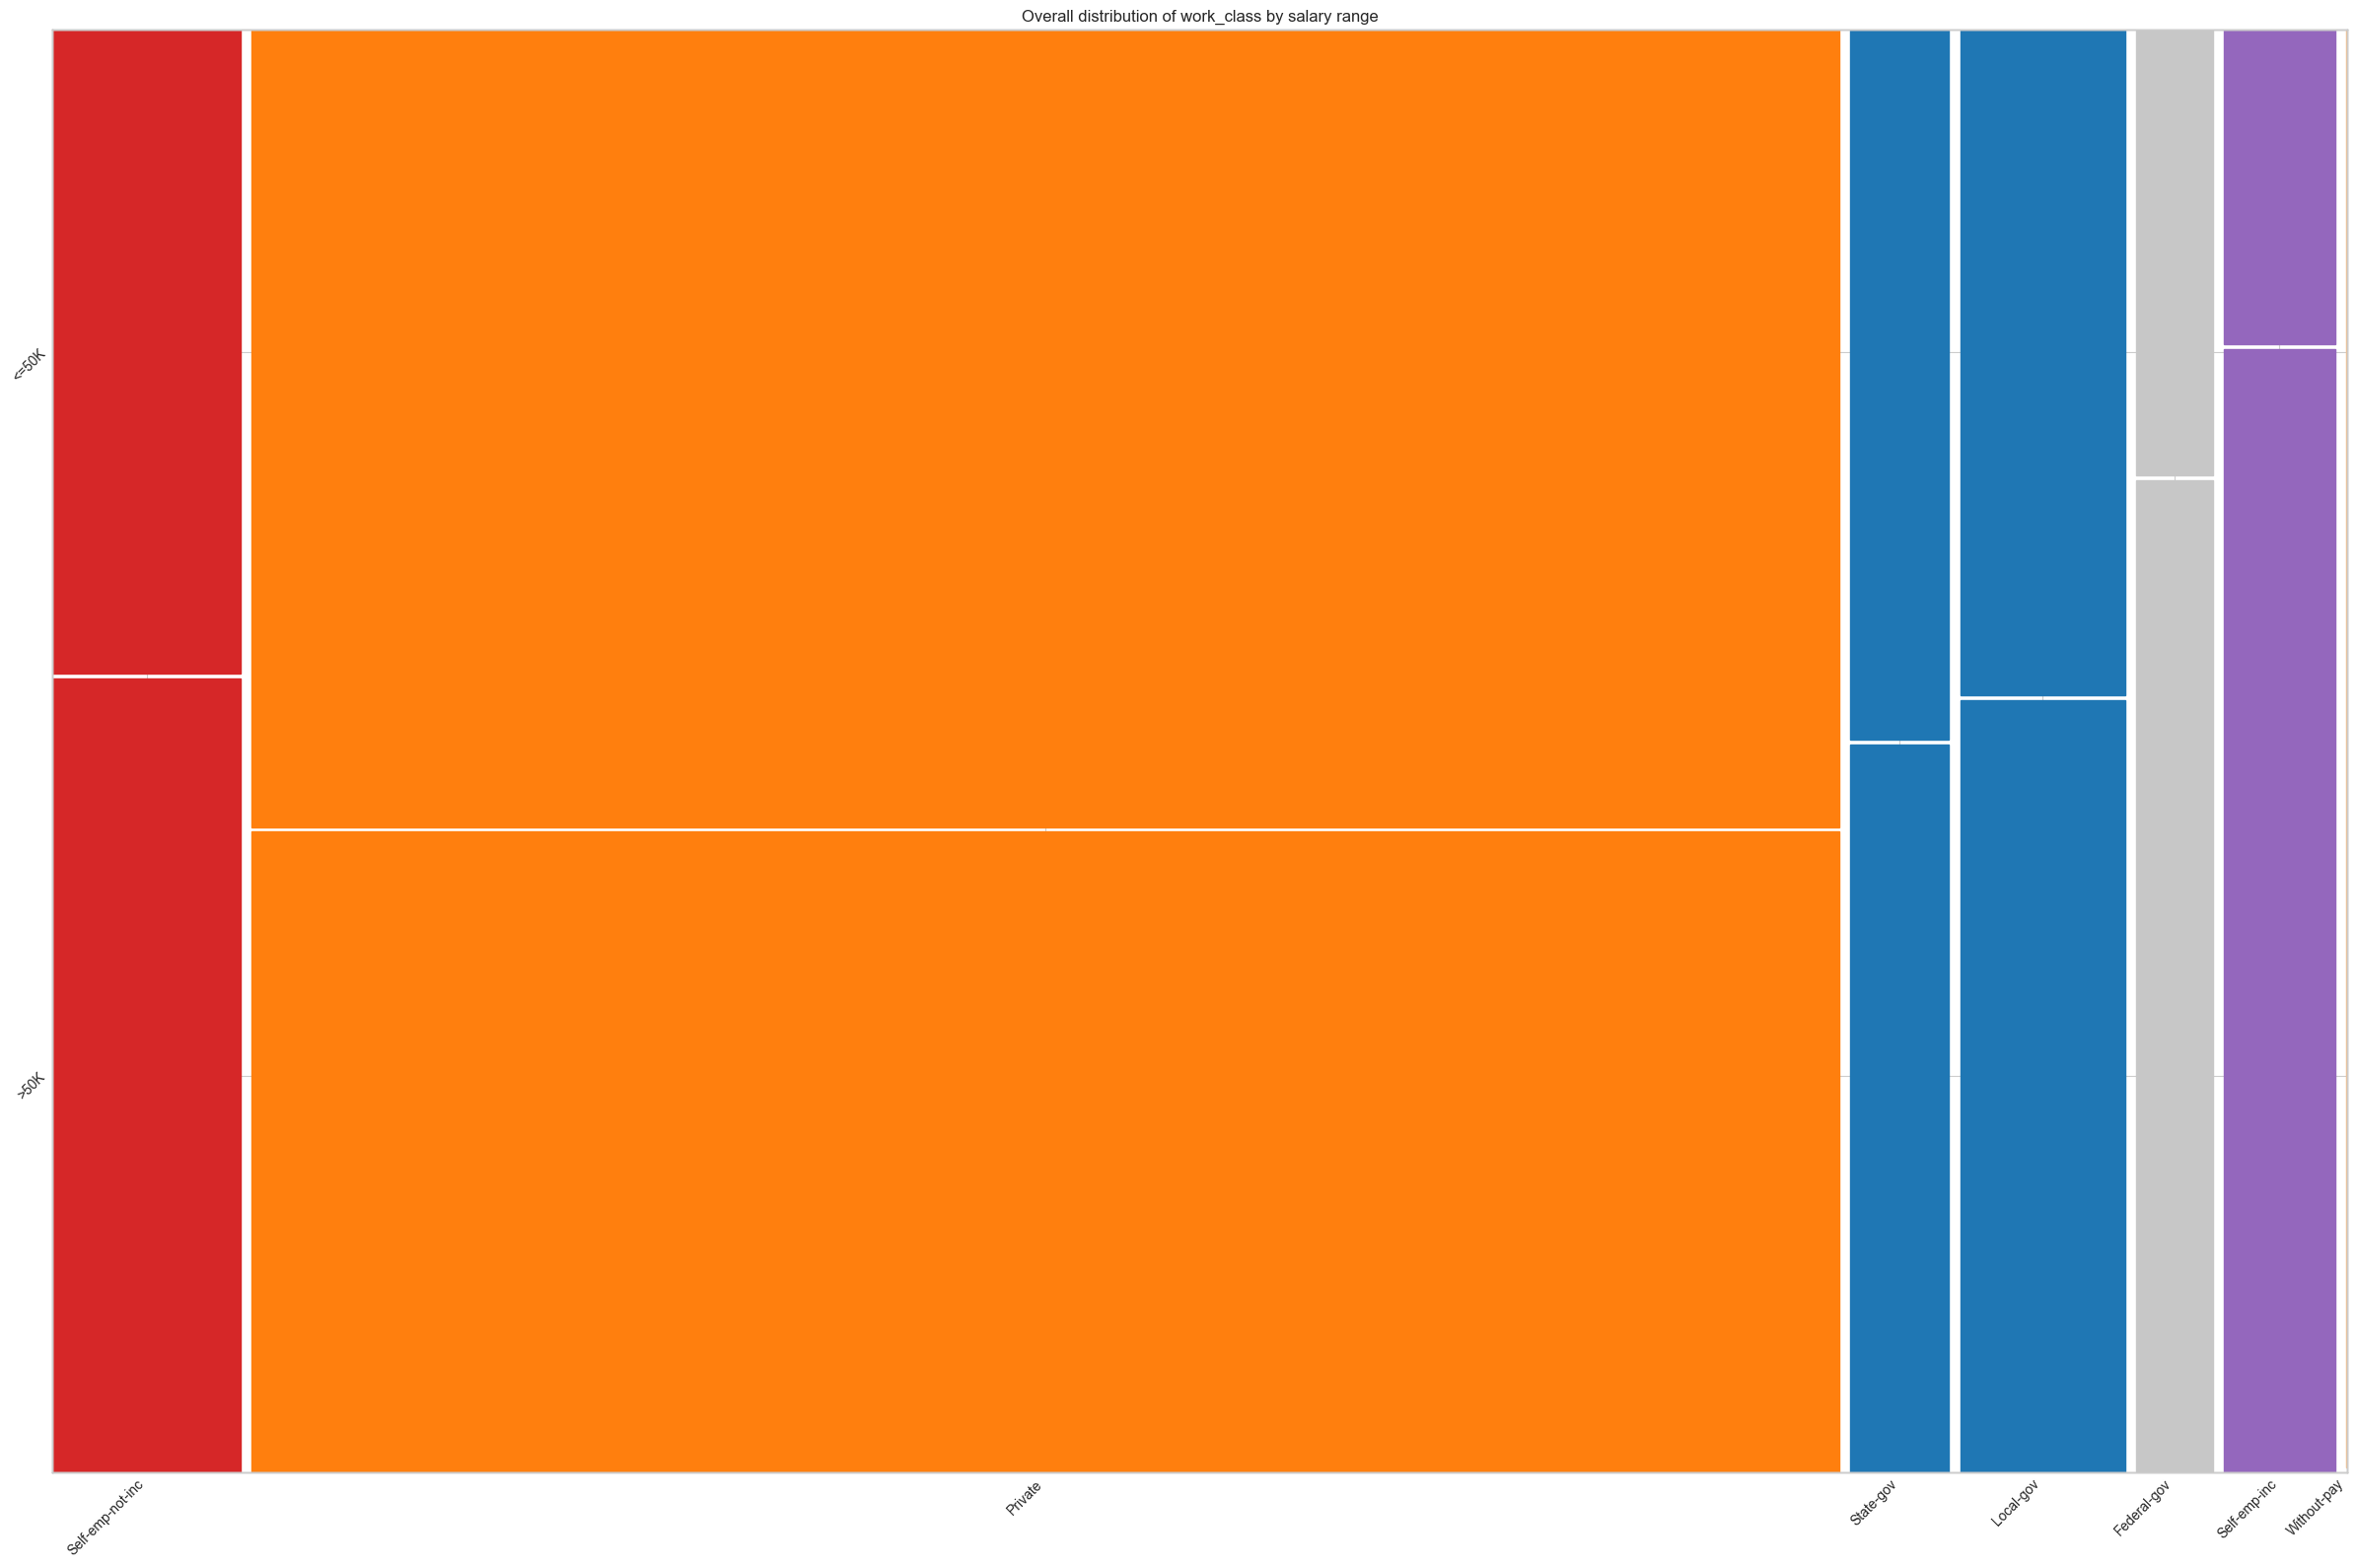

In [49]:
plot_mosaic_class(data_frame, 'education', 'marital_status', 'occupation', 'work_class')